<a href="https://colab.research.google.com/github/laggyperson/URAP-Colab-ML-Notebooks/blob/main/Traffic_Prediction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments

In [ ]:
# # Test
# ds_range = tf.data.Dataset.range(100)
# ds_2_range = tf.data.Dataset.range(0, -100, -1)
# ds_fin = tf.data.Dataset.zip((ds_range, ds_2_range))

# ds_fin_batch = ds_fin.batch(32)
# for a, b in ds_fin_batch.take(10):
#   print(a.numpy(), "=>", b.numpy(), end="\n\n")

# print("New")
# ds_fin_shuff_batch = ds_fin.batch(32).shuffle(50)
# for a, b in ds_fin_shuff_batch.take(10):
#   print(a.numpy(), "=>", b.numpy())

In [ ]:
# # Experiment
# # Will split the inputs and labels of the features based on initial parameters
# def split_window(features):
#   inputs = features[:, slice(0, 7), :]
#   labels = features[:, slice(8, 10), :]

#   # Slicing doesn't preserve static shape information, so set the shapes
#   # manually. This way the `tf.data.Datasets` are easier to inspect.
#   inputs.set_shape([None, 7, None])
#   labels.set_shape([None, 2, None])

#   return (inputs, labels)

# data = []
# count = 1
# for _ in range(50):
#   data.append(np.array([count]))
#   count += 1

# data = np.array(data)

# ds = keras.utils.timeseries_dataset_from_array(
#         data=data,
#         targets=None,
#         sequence_length=10,
#         sequence_stride=5,
#         shuffle=False,)

# for feature in ds.take(1):
#   print(np.array(feature))

# ds = ds.map(split_window)

# # for feature, label in ds.take(1):
# #   print(np.array(feature), "=>", np.array(label))

In [ ]:
import signal
from contextlib import contextmanager

class TimeoutException(Exception): pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

# Preprocessing Head

Since I have 550 time series data, there will be 550 numeric preprocessing heads because every times series has their own mean and standard deviation.

In [ ]:
# Creating inputs
inputs = {}
categorical_vars = ["Traffic Light State", "Destination Edge", "Destination Reached"] # Last one is binary, but is "y" and "n", so will convert it

for label in all_xarr["Data Labels"].data:
  dtype = tf.float32
  if label in categorical_vars:
    dtype = tf.string
  inputs[label] = keras.Input(shape=(1, ), name=label, dtype=dtype)

NameError: ignored

In [ ]:
# Checking this time series
single_ts.data.shape

In [ ]:
# Handling numerical columns
# Putting together numeric input layers
numeric_inputs = {label:input for label, input in inputs.items() if input.dtype==tf.float32}

# Concatenating the layers
temp = layers.Concatenate()(list(numeric_inputs.values()))

norm = layers.Normalization()
norm.adapt(single_ts.sel({"Data Labels": list(numeric_inputs.keys())}).data.astype(float))

In [ ]:
all_numeric_inputs = norm(temp)

In [ ]:
# Categorical variables
cat_vars = [] # (# of categorical vars)
for label in categorical_vars:
  # Will only need to use one time series for creating this: more efficient (I believe)
  lookup = layers.StringLookup(vocabulary=np.unique(all_xarr.sel({"Data Labels":label}).data))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())
  reshape = layers.Concatenate()

  tmp = lookup(inputs[label])
  tmp = one_hot(tmp)
  cat_vars.append(tmp)

In [ ]:
# Creating the processing heads
preprocessing_list = [all_numeric_inputs] + cat_vars
preprocessing_cat = layers.Concatenate()(preprocessing_list)
preprocessing_head = keras.Model(inputs, preprocessing_cat)

# Printing one out to check structure
tf.keras.utils.plot_model(model=preprocessing_head, rankdir="LR", dpi=108, show_shapes=True)

In [ ]:
# Saving the model
preprocessing_head.save("/content/drive/MyDrive/Colab Notebooks/preprocessing_head.keras")

# About
These are the models/experiments I will be running on the Sumo collected data.

Idea on Data:
* https://stats.stackexchange.com/questions/305863/how-to-train-lstm-model-on-multiple-time-series-data
* https://datascience.stackexchange.com/questions/67171/can-i-use-lstm-models-to-evaluate-multiple-independent-time-series
* https://medium.com/@kavyamalla/extending-tensorflows-window-generator-for-multiple-time-series-8b15eba57858

## Idea 1:
Seems like I batch together multiple vehicles and train it through the entire series. Then to test within the cycle, run a partial window through new vehicles and check the labels??

## Idea 2:
I am collecting data into `(# of vehicles across all simulations, # of time steps, data)`. I originally was normalizing according to each vehicle, but I don't think I should do that since the relative amount of traffic should be learned by normalizing across all simulation data.

I will then create the normal preprocessing head and then combine that into a model with a compile function. There will be no processing beforehand.

To further organize the data, I will split the data into 70% training, 20% validation, and 10% test. This means the first 70% of the time series data is used, so on so forth.

The way the data is organized is as follows:
Say each vehicle in each simulation has a time series that looks like
$[f_0, ..., f_{2401}]$ where $f_i$ is a vector of all the features at a certain time step.

Say that my window is 50 time steps total, split into 25 inputs and 25 labels.
$$[0, ..., 24] \rightarrow [25, ...,49]$$
If I take a stride of 25 and batch 32 sequences together, the data will look as follows:

**Batch 1:**

$[f_0, ..., f_{24}] \rightarrow [f_{25}, ..., f_{49}]$

$[f_{25}, ..., f_{49}] \rightarrow [f_{50}, ..., f_{74}]$

$\qquad \qquad \qquad \vdots$

$[f_{775}, ..., f_{799}] \rightarrow [f_{800}, ..., f_{824}]$

**Batch 2:**

$[f_{800}, ..., f_{824}] \rightarrow [f_{825}, ..., f_{849}]$

$\qquad\qquad\qquad \vdots$

**Batch 3:**

$\vdots$

After shuffling, each `input, label` pair will be shuffled around. The state of the LSTM will be reset after each batch.

This data will be normalized all together, so there is a sense of relative amounts of traffic that differs in every simulation

##Issue:
An issue that needs to be addressed is the changing destinations. It is possible that the LSTM will become confused when in the middle of an input the car suddenly switches a destination, meaning the model suddenly has to disregard the previous destination and its associated values.

### Idea 1:
Split the vehicle time series data into separate sequences that end when the vehicle reaches the destination. This would lead to variable window and input lengths that will not be padded because the lengths may vary a lot.

### Idea 2:
Batch the data the same way as before, but remove any inputs where the destination changes. Filtering the data seems to be possible.

## Improvement Ideas
* Activation Functions:
  * https://stats.stackexchange.com/questions/444923/activation-function-between-lstm-layers#:~:text=Given%20that%20ReLUs%20can%20have,inappropriate%20for%20use%20with%20LSTMs.
  * https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers

# Loading the Data

In [ ]:
g16_100v_noLC_shortTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_100v_noLC.nc")
g16_100v_noLC_shortTL_arr = g16_100v_noLC_shortTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_100v_LC_shortTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_100v_LC.nc")
g16_100v_LC_shortTL_arr = g16_100v_LC_shortTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_100v_LC_longTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_100v_LC_longTL.nc")
g16_100v_LC_longTL_arr = g16_100v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_50v_LC_longTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_50v_LC_longTL.nc")
g16_50v_LC_longTL_arr = g16_50v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_200v_LC_longTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_200v_LC_longTL.nc")
g16_200v_LC_longTL_arr = g16_200v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

# List of all arrays
arrs = [g16_100v_noLC_shortTL_arr, g16_100v_LC_shortTL_arr, g16_100v_LC_longTL_arr, g16_50v_LC_longTL_arr, g16_200v_LC_longTL_arr]

In [ ]:
# Concatenating
all_xarr = xr.concat(arrs, dim="Veh IDs")

In [ ]:
# Offloading RAM since arrs not needed anymore
del g16_100v_noLC_shortTL_ds
del g16_100v_noLC_shortTL_arr
del g16_100v_LC_shortTL_ds
del g16_100v_LC_shortTL_arr

del g16_100v_LC_longTL_ds
del g16_100v_LC_longTL_arr

del g16_50v_LC_longTL_ds
del g16_50v_LC_longTL_arr

del g16_200v_LC_longTL_ds
del g16_200v_LC_longTL_arr

del arrs

# Preprocessing
Faster than preprocessing head

In [ ]:
categorical_vars = ["Traffic Light State", "Destination Edge", "Destination Reached"] # Last one is binary, but is "y" and "n", so will convert it
numeric_vars = [label for label in all_xarr["Data Labels"].data if label not in categorical_vars]

In [ ]:
# New label order
labels = numeric_vars + categorical_vars
print(len(labels))

22


In [ ]:
for i in range(len(labels)):
  print(i, labels[i])

0 Speed
1 Max Speed
2 Acceleration
3 Traffic Light Distance
4 Traffic Light Time to Switch
5 Number of Vehicles to Traffic Light
6 Number of Leading Vehicles
7 Leading Vehicles Average Gap
8 Leading Vehicles Average Speed
9 Leading Vehicles Average Acceleration
10 Number of Right Lane Vehicles
11 Right Lane Average Gap
12 Right Lane Average Speed
13 Right Lane Average Acceleration
14 Number of Left Lane Vehicles
15 Left Lane Average Gap
16 Left Lane Average Speed
17 Left Lane Average Acceleration
18 Distance to Edge
19 Traffic Light State
20 Destination Edge
21 Destination Reached


In [ ]:
# Getting numerical data into correct shape
single_ts = all_xarr.sel({"Data Labels": numeric_vars}).data.astype(float)
single_ts = np.concatenate(single_ts)

# Data to Normalize
numerical_data = all_xarr.sel({"Data Labels": numeric_vars}).data.astype(float)

In [ ]:
# Getting rid of bad values from Distance to Edge
temp = single_ts[:, -1]
temp[temp < 0] = 0

temp = numerical_data[:, :, -1]
temp[temp < 0] = 0

In [ ]:
# Preprocessing manually
num_mean = np.mean(single_ts, axis=0)
num_std = np.std(single_ts, axis=0)
numerical_data = (numerical_data - num_mean) / num_std

In [ ]:
# Loading all categorical data into separate arrays
categorical_data_TL_state = all_xarr.sel({"Data Labels": "Traffic Light State"}).data
categorical_data_dest = all_xarr.sel({"Data Labels": "Destination Edge"}).data
categorical_data_reached = all_xarr.sel({"Data Labels": "Destination Reached"}).data

cat_dict = {
    "Traffic Light State": categorical_data_TL_state,
    "Destination Edge": categorical_data_dest,
    "Destination Reached": categorical_data_reached
}

In [ ]:
# Encoding all the data
for label in categorical_vars:
  curr_arr = cat_dict[label]
  vocab = np.unique(curr_arr)
  encode = layers.StringLookup(vocabulary=vocab, output_mode="one_hot")
  encodings = encode(vocab).numpy()
  trans_dict = {vocab[i]: encodings[i] for i in range(len(vocab))}

  new_arr = []
  for ts in curr_arr:
    new_arr.append(np.array([trans_dict[w] for w in ts]))
  cat_dict[label] = np.array(new_arr)

In [ ]:
print(cat_dict["Traffic Light State"].shape)

(550, 2401, 5)


In [ ]:
# Recombining all categorical data data
categorical_data = np.concatenate(list(cat_dict.values()), axis=-1)
categorical_data.shape # The final dimension will be (TL State, Destination Edge, Destination Reached)

(550, 2401, 25)

In [ ]:
# Recombining all data into a single numpy array
all_data = np.concatenate((numerical_data, categorical_data), axis=-1)
all_data.shape # CHecking proper shape

(550, 2401, 44)

In [ ]:
# Splitting the Data into training and test sets
# Distribution: 70% training, 20% validation, 10% test

steps = len(all_data[0])
# Slices
train_slice = slice(0, int(0.7 * steps))
validate_slice = slice(int(0.7 * steps), int(0.9 * steps))
test_slice = slice(int(0.9 * steps), None)
# Splitting each individual set
slice_func = lambda data, s: data[s]
train_ts = all_data[:, train_slice, :]
validate_ts = all_data[:, validate_slice, :]
test_ts = all_data[:, test_slice, :]

In [ ]:
print(train_ts.shape, validate_ts.shape, test_ts.shape)

(550, 1680, 44) (550, 480, 44) (550, 241, 44)


In [ ]:
# # Clearing RAM
# del categorical_data_TL_state
# del categorical_data_reached
# del categorical_data_dest
# del cat_dict
# del all_xarr
# del curr_arr
# del encode
# del encodings
# del label
# del new_arr
# del num_mean
# del num_std
# del numerical_data
# del categorical_data
# del ts
# del vocab
# del single_ts
# del all_data
# del categorical_vars
# del numeric_vars
# del steps

# Windowing + Batching

In [ ]:
# Creating a Window class

class WindowGenerator():
  def __init__(self, input_width, label_width, shift, stride,
               train_data, val_data, test_data, all_labels, input_columns=None, label_columns=None):
    # Windows intialized with data
    self.train_data = train_data
    self.val_data = val_data
    self.test_data = test_data

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.stride = stride


    self.all_labels = all_labels
    self.column_indices = {all_labels[i]: slice(i, i + 1) for i in range(len(all_labels))}
    self.column_indices["Traffic Light State"] = slice(self.column_indices["Traffic Light State"].start, self.column_indices["Traffic Light State"].start + 5)
    self.column_indices["Destination Edge"] = slice(self.column_indices["Traffic Light State"].start + 1, self.column_indices["Traffic Light State"].start + 20)
    self.column_indices["Destination Reached"] = slice(len(all_labels) - 1, None)

    if input_columns is not None:
      self.input_columns = input_columns
      self.input_columns_indices = {column: self.column_indices[column] for column in input_columns}

      i = 1
      tmp_keys = list(self.input_columns_indices.keys())
      while i < len(tmp_keys):
        diff = self.input_columns_indices[tmp_keys[i]].start - self.input_columns_indices[tmp_keys[i - 1]].stop # Finding if there is a gap greather than 1 to shrink
        if diff > 0:
          self.input_columns_indices[tmp_keys[i]] = slice(self.input_columns_indices[tmp_keys[i]].start - diff, self.input_columns_indices[tmp_keys[i]].stop - diff)
        i += 1

    else:
      self.input_columns = all_labels
      self.input_columns_indices = self.column_indices

    if label_columns is not None:
      self.label_columns_indices = {column: self.column_indices[column] for column in label_columns}
      i = 1
      tmp_keys = list(self.label_columns_indices.keys())
      while i < len(tmp_keys):
        diff = self.label_columns_indices[tmp_keys[i]].start - self.label_columns_indices[tmp_keys[i - 1]].stop # Finding if there is a gap greather than 1 to shrink
        if diff > 0:
          self.label_columns_indices[tmp_keys[i]] = slice(self.label_columns_indices[tmp_keys[i]].start - diff, self.label_columns_indices[tmp_keys[i]].stop - diff)
        i += 1

    self.label_columns = label_columns

    self.total_window_size = input_width + label_width # Assuming that shift is always size of input

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    self.count = 0

  def make_window(self, time_series):
    # Input Shape: (2401, 44) = (# of time steps, # of features)
    # Output Shape: (# of windows, # of time steps per window, # of features)
    w_start, w_end = 0, self.total_window_size
    stride = self.stride

    res = []
    while w_end < len(time_series):
      window = time_series[w_start: w_end]
      if 1 not in window[:, -1]:
        res.append(window)
      w_start += stride
      w_end += stride

    return res

  def make_dataset(self, data):
    # The data is in the shape (550, 2401, 44) = (# of veh series, # of time steps, preprocessed features)
    # The returned dataset should be in the shape:
    # (_, 2) = (# of batches, dimension of each example)
    # Each example: ((32, 40, 44), (32, 40, 2)) = (features, labels)
    # = ((# of examples per batch, # of time steps in input, # of features in input), (# of examples per batch, # of time steps in labels, # of features in labels))

    # Window each time series
    # Output Shape: (550, # of windows, # of time steps per window, # of features=44)
    # Issue: Non homogenous 2nd dimension (each time series may have different amount of filtered windows): can't use numpy
    data = [self.make_window(ts) for ts in data]

    # Stacking all windows together
    # Shape: (# of windows, # of time stps per window, # of features=44)
    data = np.array([win for ts in data for win in ts])

    # Get the features
    # (# of windows, # of time steps, # of features)
    feature_examples = data[:, self.input_slice, :]
    feature_examples = np.concatenate([feature_examples[:, :, self.column_indices[label]] for label in self.input_columns], -1)

    # Get the labels
    label_examples = data[:, self.labels_slice, :]
    if self.label_columns is not None:
      label_examples = np.concatenate([label_examples[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Make the dataset
    ds = tf.data.Dataset.from_tensor_slices((feature_examples, label_examples))
    ds = ds.batch(32).shuffle(100)
    return ds

  def plot(self, data, model=None, plot_col='Distance to Edge', max_subplots=3):
    plt.figure(figsize=(12, 3 * max_subplots)) # Setting size: will dynamically resize based on the number of subplots
    plot_col_index = self.input_columns_indices[plot_col] # Index of which feature to plot

    # Plotting each subplot
    plot_num = 1 # Keep track of which plot is current
    for input, label in data.take(max_subplots): # Grabbing feature and data
      plt.subplot(max_subplots, 1, plot_num) # Specify which one currently plotting

      plt.ylabel(f'{plot_col} [normed]') # Label y axis

      plt.plot(self.input_indices, input.numpy()[plot_num, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)  # Plot the blue line that represents the input

      # Finding feature index to extract from the returned labels (since it may differ in shape than the input)
      if self.label_columns:
        label_col_index = self.label_columns_indices[plot_col]
      else:
        label_col_index = plot_col_index

      if label_col_index is None: # If it isn't found
        continue

      plt.scatter(self.label_indices, label.numpy()[plot_num, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64) # Plot the expected labels as green dots
      if model is not None: # Using model to make predictions
        predictions = model(input) # Calling model on inputs
        plt.scatter(self.label_indices, predictions[plot_num, :, label_col_index], # Plotting predictions, extracting the label wanted
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if plot_num == 1: # First plot we want to plot the legend
        plt.legend()

      plot_num += 1

    plt.xlabel('Time (s)') # Label x-axis


  @property
  def train(self):
    return self.make_dataset(self.train_data)

  @property
  def val(self):
    return self.make_dataset(self.val_data)

  @property
  def test(self):
    return self.make_dataset(self.test_data)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.test))
      # And cache it for next time
      self._example = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
# Removing all Traffic Light Data
input_labels = [label for label in labels if label not in ["Number of Vehicles to Traffic Light", "Destination Edge", "Destination Reached", ]]
output_labels = [label for label in input_labels if label not in ["Traffic Light Distance", "Traffic Light State", "Traffic Light Time to Switch"]]

In [ ]:
# Sparse labels
input_labels = ["Speed", "Acceleration", "Traffic Light Distance", "Traffic Light Time to Switch", "Leading Vehicles Average Speed", "Leading Vehicles Average Acceleration", "Traffic Light State", "Distance to Edge"]
output_labels = [label for label in input_labels if label not in ["Traffic Light Distance", "Traffic Light State", "Traffic Light Time to Switch"]]

In [ ]:
input_labels = ["Speed", "Acceleration", "Leading Vehicles Average Speed", "Leading Vehicles Average Acceleration", "Distance to Edge"]
output_labels = input_labels

In [ ]:
# Testing windows + batching
w0 = WindowGenerator(40, 40, 40, 5, train_ts, validate_ts, test_ts, labels, input_labels, output_labels)

In [ ]:
# # Verifying Correct indices
# for label in input_labels:
#   print(label, w0.input_columns_indices[label])

# print('\n\n')
# for label in output_labels:
#   print(label, w0.label_columns_indices[label])

In [ ]:
test_ds = w0.test
train_ds = w0.train
val_ds = w0.val

In [ ]:
print(train_ds)

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 40, 23), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10, 16), dtype=tf.float64, name=None))>


In [ ]:
# for feature, label in test_ds.take(10):
#   plt.figure(figsize=(10, 2))
#   plt.plot(np.arange(40), feature.numpy()[0, :, 18])
#   plt.plot(np.arange(40,80), label.numpy()[0, :, 1])
#   plt.show()

# Model Template

In [ ]:
MAX_EPOCHS = 5

def compile_and_fit(model, train, validate, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(train, epochs=MAX_EPOCHS,
                      validation_data=validate,
                      callbacks=[early_stopping])
  return history

In [ ]:
OUTPUT_STEPS = 80
num_features = 16

# More Rigorous Model Training

## Finding best Neurons

Conclusion: Although more neurons did produce better training results, validation errors show that large number of neurons is prone to overfitting.

The best network seems to be 92 neurons (4 times the number of input features)

In [ ]:
num_neurons_lstm = keras.Sequential([
    layers.LSTM(138, return_sequences=False),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(num_neurons_lstm, train_ds, val_ds, patience=5)

Epoch 1/5
825/825 [==============================] - 160s 183ms/step - loss: 0.5657 - mean_absolute_error: 0.4369 - val_loss: 0.5200 - val_mean_absolute_error: 0.3747
Epoch 2/5
825/825 [==============================] - 141s 171ms/step - loss: 0.5177 - mean_absolute_error: 0.4012 - val_loss: 0.5085 - val_mean_absolute_error: 0.3629
Epoch 3/5
825/825 [==============================] - 143s 173ms/step - loss: 0.4988 - mean_absolute_error: 0.3905 - val_loss: 0.4937 - val_mean_absolute_error: 0.3564
Epoch 4/5
825/825 [==============================] - 142s 172ms/step - loss: 0.4861 - mean_absolute_error: 0.3829 - val_loss: 0.4877 - val_mean_absolute_error: 0.3533
Epoch 5/5
825/825 [==============================] - 153s 185ms/step - loss: 0.4768 - mean_absolute_error: 0.3776 - val_loss: 0.4967 - val_mean_absolute_error: 0.3574


In [ ]:
num_neurons_lstm.evaluate(test_ds)

56/56 [==============================] - 5s 86ms/step - loss: 0.4474 - mean_absolute_error: 0.3696


[0.4474288523197174, 0.36958134174346924]

In [ ]:
# Stupid code for comparison
training_losses = {
    23: [0.6220, 0.5618, 0.5455, 0.5376, 0.5306],
    46: [0.5907, 0.5402, 0.5246, 0.5155, 0.5086],
    92: [0.5713, 0.5241, 0.5065, 0.4970, 0.4874],
    138: [0.5657, 0.5177, 0.4988, 0.4861, 0.4768],
    184: [0.5569, 0.5102, 0.4934, 0.4773, 0.4773] # Last one not outputted
}
training_validation_losses = {
    23: [0.5706, 0.5379, 0.5254, 0.5192, 0.5220],
    46: [0.5487, 0.5277, 0.5191, 0.5086, 0.5082],
    92: [0.5213, 0.5087, 0.5023, 0.4915, 0.4868],
    138: [0.5200, 0.5085, 0.4937, 0.4877, 0.4967],
    184: [0.5153, 0.4876, 0.4972, 0.4905, 0.4905]
}
test_loss = {
    23: 0.4675,
    46: 0.4256,
    92: 0.4338,
    138: 0.4474,
    184: 0.4547
}

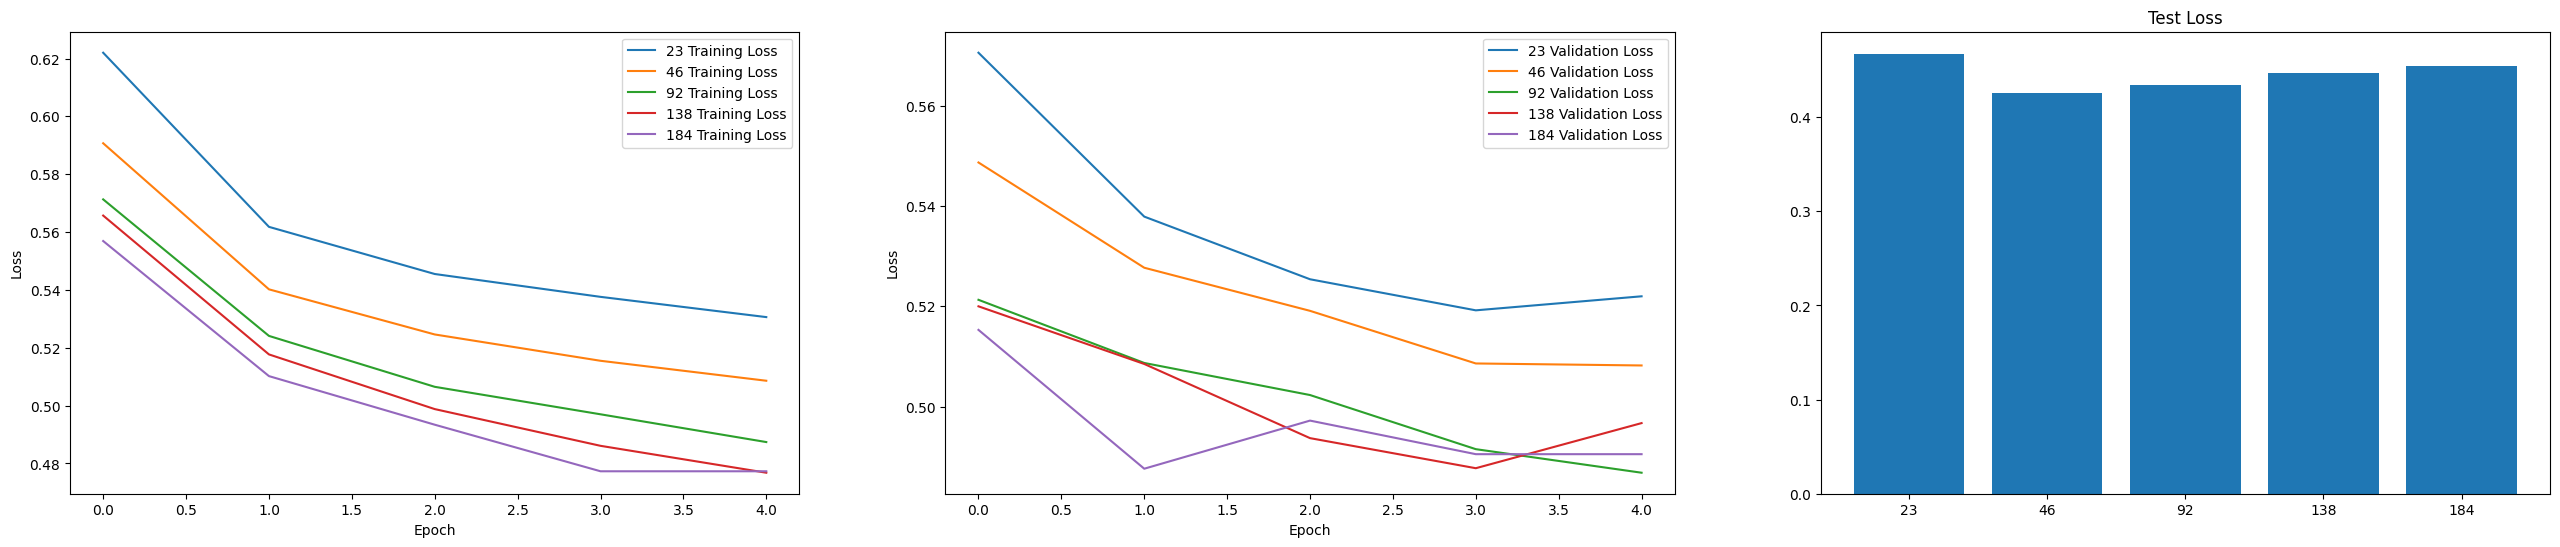

In [ ]:
# Plotting the stupidly collected data
plt.figure(figsize=(32, 6))
for neurons in training_losses.keys():
  # Training Losses
  plt.subplot(1, 3, 1)
  plt.plot(training_losses[neurons], label=f"{neurons}" + " Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  # Validation Losses
  plt.subplot(1, 3, 2)
  plt.plot(training_validation_losses[neurons], label=f"{neurons}" + " Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

# Test Losses
plt.subplot(1, 3, 3)
plt.title("Test Loss")
plt.bar(["23", "46", "92", "138", "184"], test_loss.values())

plt.show()

## Finding Best Window

### Finding Best Input/Output Length

Stride for all of these was 20.

Conclusion: In general, reducing the window size reduced the error. However, an asymmetric window seems to work even better, especially with a ratio of 4 : 1 (input : output).

The best window is 40 input steps, 10 output steps.

In [ ]:
w1 = WindowGenerator(40, 10, 40, 20, train_ts, validate_ts, test_ts, labels, input_labels, output_labels)

In [ ]:
test_ds = w1.test
train_ds = w1.train
val_ds = w1.val

In [ ]:
num_features = 16

In [ ]:
OUTPUT_STEPS = 10
# Simple model being used
wind_lstm = keras.Sequential([
    layers.LSTM(23, return_sequences=False),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(wind_lstm, train_ds, val_ds, patience=5)

Epoch 1/5
1233/1233 [==============================] - 37s 26ms/step - loss: 0.5185 - mean_absolute_error: 0.4073 - val_loss: 0.4183 - val_mean_absolute_error: 0.3199
Epoch 2/5
1233/1233 [==============================] - 32s 26ms/step - loss: 0.4012 - mean_absolute_error: 0.3208 - val_loss: 0.3824 - val_mean_absolute_error: 0.2902
Epoch 3/5
1233/1233 [==============================] - 33s 27ms/step - loss: 0.3849 - mean_absolute_error: 0.3060 - val_loss: 0.3697 - val_mean_absolute_error: 0.2826
Epoch 4/5
1233/1233 [==============================] - 33s 27ms/step - loss: 0.3771 - mean_absolute_error: 0.2995 - val_loss: 0.3622 - val_mean_absolute_error: 0.2773
Epoch 5/5
1233/1233 [==============================] - 30s 25ms/step - loss: 0.3721 - mean_absolute_error: 0.2954 - val_loss: 0.3538 - val_mean_absolute_error: 0.2735


In [ ]:
wind_lstm.evaluate(test_ds)

152/152 [==============================] - 1s 7ms/step - loss: 0.3723 - mean_absolute_error: 0.2837


[0.37233540415763855, 0.2836509346961975]

In [ ]:
# Stupid Comparison Code Continued
# Key is inputwindsize / outputwindsize
training_losses = {
    "80/80": [0.6183, 0.5611, 0.5449, 0.5355, 0.5292],
    "40/40": [0.6258, 0.5530, 0.5336, 0.5243, 0.5180],
    "20/20": [0.5778, 0.4884, 0.4735, 0.4648, 0.4599],
    "10/10": [0.5263, 0.4158, 0.4007, 0.3932, 0.3885],
    "20/40": [0.6331, 0.5645, 0.5484, 0.5401, 0.5347],
    "40/20": [0.5766, 0.4801, 0.4635, 0.4550, 0.4492],
    "80/40": [0.6059, 0.5303, 0.5114, 0.5019, 0.4959],
    "80/20": [0.5608, 0.4674, 0.4487, 0.4393, 0.4337],
    "40/10": [0.5185, 0.4012, 0.3849, 0.3771, 0.3721],
}

training_validation_losses = {
    "80/80": [0.5685, 0.5418, 0.5275, 0.5201, 0.5151],
    "40/40": [0.5712, 0.5431, 0.5283, 0.5212, 0.5131],
    "20/20": [0.5182, 0.4730, 0.4539, 0.4457, 0.4433],
    "10/10": [0.4329, 0.3966, 0.3821, 0.3721, 0.3647],
    "20/40": [0.5794, 0.5509, 0.5384, 0.5340, 0.5243],
    "40/20": [0.4962, 0.4599, 0.4450, 0.4376, 0.4332],
    "80/40": [0.5501, 0.5202, 0.5066, 0.5003, 0.4982],
    "80/20": [0.4960, 0.4486, 0.4288, 0.4193, 0.4144],
    "40/10": [0.4183, 0.3824, 0.3697, 0.3622, 0.3538],
}

test_loss = {
    "80/80": [0.4634],
    "40/40": [0.5299],
    "20/20": [0.4708],
    "10/10": [0.5607],
    "20/40": [0.5644],
    "40/20": [0.4543],
    "80/40": [0.4731],
    "80/20": [0.4096],
    "40/10": [0.3723]
}

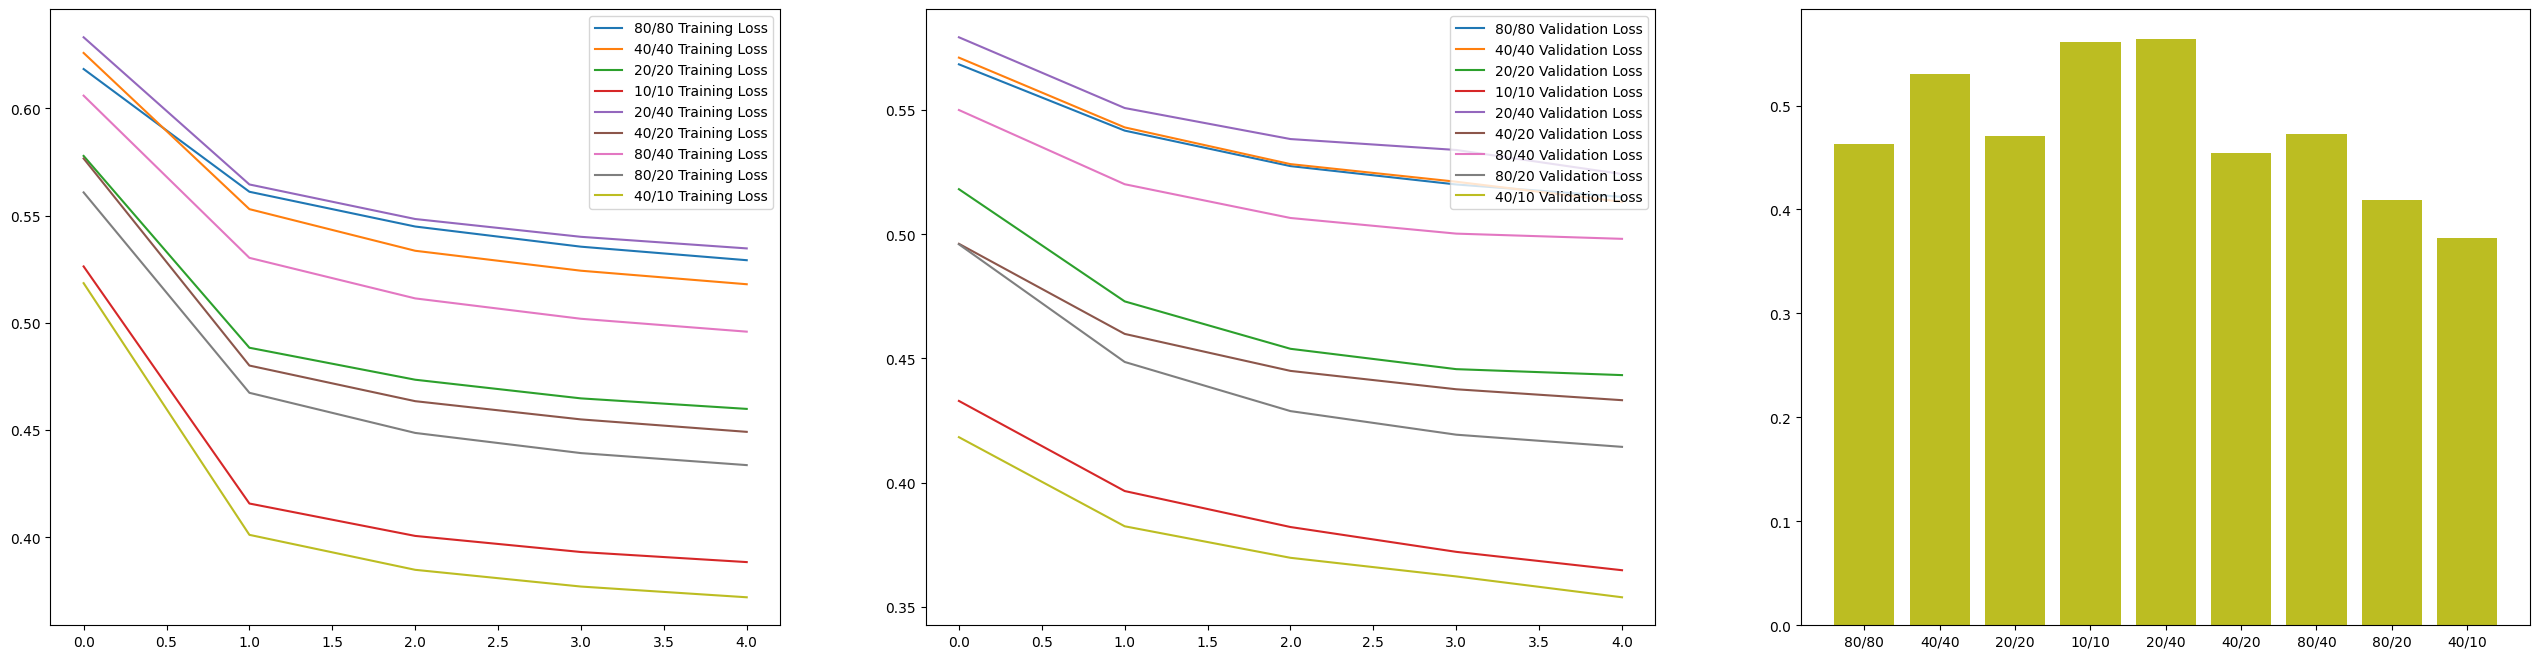

In [ ]:
# Plotting the stupidly collected data
plt.figure(figsize=(32, 8))
for wind_size in training_losses.keys():
  # Training Losses
  plt.subplot(1, 3, 1)
  plt.plot(training_losses[wind_size], label=wind_size + " Training Loss")
  plt.legend()

  # Validation Losses
  plt.subplot(1, 3, 2)
  plt.plot(training_validation_losses[wind_size], label=wind_size + " Validation Loss")
  plt.legend(loc="upper right")

  # Test Losses
  plt.subplot(1, 3, 3)
  plt.bar(test_loss.keys(), [val[0] for val in test_loss.values()])
plt.show()

### Finding Best Stride

Conclusion (fixed window in and out): It seems like the smaller the ratio of stride to window size is, the better (more training examples). However, at 4 : 1 (input : stride), there is overfitting, and the validation/test loss increase/stay the same.

Conclusion (asymmetric): Smaller = better (no overfitting; maybe I got lucky). Just a matter of how long it takes.

In [ ]:
w1 = WindowGenerator(40, 10, 40, 10, train_ts, validate_ts, test_ts, labels, input_labels, output_labels)
test_ds = w1.test
train_ds = w1.train
val_ds = w1.val

In [ ]:
num_features = 16
OUTPUT_STEPS = 10
# Simple model being used
stride_lstm = keras.Sequential([
    layers.LSTM(23, return_sequences=False),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(stride_lstm, train_ds, val_ds, patience=5)

Epoch 1/5
2449/2449 [==============================] - 68s 26ms/step - loss: 0.4658 - mean_absolute_error: 0.3679 - val_loss: 0.3971 - val_mean_absolute_error: 0.2991
Epoch 2/5
2449/2449 [==============================] - 63s 26ms/step - loss: 0.3801 - mean_absolute_error: 0.3030 - val_loss: 0.3733 - val_mean_absolute_error: 0.2804
Epoch 3/5
2449/2449 [==============================] - 63s 26ms/step - loss: 0.3691 - mean_absolute_error: 0.2942 - val_loss: 0.3631 - val_mean_absolute_error: 0.2757
Epoch 4/5
2449/2449 [==============================] - 63s 26ms/step - loss: 0.3633 - mean_absolute_error: 0.2901 - val_loss: 0.3551 - val_mean_absolute_error: 0.2717
Epoch 5/5
2449/2449 [==============================] - 63s 26ms/step - loss: 0.3599 - mean_absolute_error: 0.2875 - val_loss: 0.3511 - val_mean_absolute_error: 0.2675


In [ ]:
stride_lstm.evaluate(test_ds)

303/303 [==============================] - 3s 9ms/step - loss: 0.3643 - mean_absolute_error: 0.2766


[0.36425307393074036, 0.27663564682006836]

In [ ]:
# Stupid Comparison Code Continued
# Key is stride
training_losses = {
    "40": [0.6740, 0.5872, 0.5627, 0.5495, 0.5401],
    "30": [0.6483, 0.5703, 0.5463, 0.5354, 0.5293],
    "20": [0.6230, 0.5511, 0.5322, 0.5224, 0.5171],
    "10": [0.5901, 0.5342, 0.5202, 0.5130, 0.5084],
    "40, Asymmetric": [0.5869, 0.4345, 0.4000, 0.3870, 0.3796],
    "30, Asymmetric": [0.5609, 0.4190, 0.3957, 0.3861, 0.3804],
    "20, Asymmetric": [0.5217, 0.4031, 0.3863, 0.3781, 0.3724],
    "10, Asymmetric": [0.4658, 0.3801, 0.3691, 0.3633, 0.3599]
}

training_validation_losses = {
    "40": [0.6009, 0.5612, 0.5455, 0.5411, 0.5282],
    "30": [0.5911, 0.5601, 0.5530, 0.5399, 0.5243],
    "20": [0.5859, 0.5553, 0.5322, 0.5218, 0.5194],
    "10": [0.5606, 0.5352, 0.5279, 0.5261, 0.5246],
    "40, Asymmetric": [0.4874, 0.4151, 0.3878, 0.3738, 0.3651],
    "30, Asymmetric": [0.4597, 0.4002, 0.3796, 0.3696, 0.3618],
    "20, Asymmetric": [0.4291, 0.3857, 0.3686, 0.3604, 0.3547],
    "10, Asymmetric": [0.3971, 0.3733, 0.3631, 0.3551, 0.3511]
}

test_loss = {
    "40": 0.5628,
    "30": 0.5445,
    "20": 0.5426,
    "10": 0.5417,
    "40, Asymmetric": 0.3933,
    "30, Asymmetric": 0.3823,
    "20, Asymmetric": 0.3747,
    "10, Asymmetric": 0.3643
}

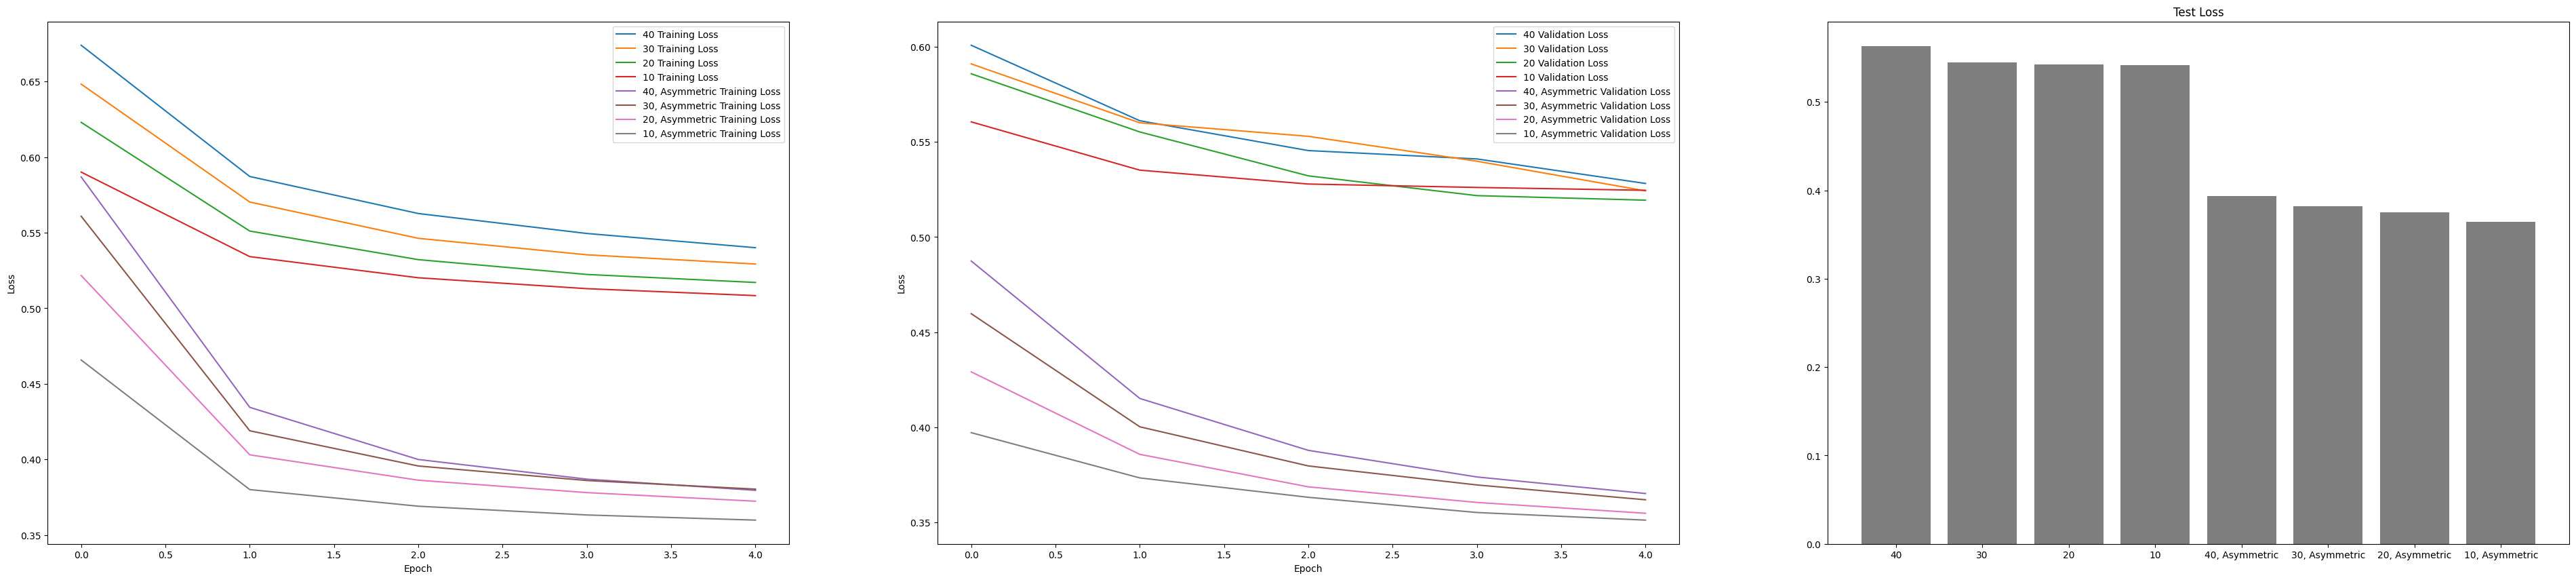

In [ ]:
# Plotting the stupidly collected data
plt.figure(figsize=(48, 10))
for stride in training_losses.keys():
  # Training Losses
  plt.subplot(1, 3, 1)
  plt.plot(training_losses[stride], label=stride + " Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  # Validation Losses
  plt.subplot(1, 3, 2)
  plt.plot(training_validation_losses[stride], label=stride + " Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

  # Test Losses
  plt.subplot(1, 3, 3)
  plt.title("Test Loss")
  plt.bar(test_loss.keys(), test_loss.values())
plt.show()

## Finding Best Dropouts

### Finding Best Dropout

Conclusion: I had 3 runs with a 23-neuron network before I used a 92-neuron network because I was getting worse and worse performance, possibly due to the fact that there so little neurons, it lacked descriptive power. However, even with a 92-neuron network, increasing the dropout rate increased the losses.

Going to stay away from this for now (unless I find multilayer LSTM's are better)

In [ ]:
w1 = WindowGenerator(40, 40, 40, 20, train_ts, validate_ts, test_ts, labels, input_labels, output_labels)
test_ds = w1.test
train_ds = w1.train
val_ds = w1.val

In [ ]:
num_features = 16
OUTPUT_STEPS = 40
# Simple model being used
dropout_lstm = keras.Sequential([
    layers.LSTM(92, return_sequences=False, dropout=0.5),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(dropout_lstm, train_ds, val_ds, patience=5)

Epoch 1/5
1104/1104 [==============================] - 57s 47ms/step - loss: 0.5840 - mean_absolute_error: 0.4446 - val_loss: 0.5485 - val_mean_absolute_error: 0.3801
Epoch 2/5
1104/1104 [==============================] - 48s 44ms/step - loss: 0.5337 - mean_absolute_error: 0.4109 - val_loss: 0.5355 - val_mean_absolute_error: 0.3701
Epoch 3/5
1104/1104 [==============================] - 51s 46ms/step - loss: 0.5171 - mean_absolute_error: 0.3994 - val_loss: 0.5332 - val_mean_absolute_error: 0.3731
Epoch 4/5
1104/1104 [==============================] - 49s 45ms/step - loss: 0.5068 - mean_absolute_error: 0.3928 - val_loss: 0.5321 - val_mean_absolute_error: 0.3704
Epoch 5/5
1104/1104 [==============================] - 52s 47ms/step - loss: 0.4983 - mean_absolute_error: 0.3872 - val_loss: 0.5146 - val_mean_absolute_error: 0.3629


In [ ]:
dropout_lstm.evaluate(test_ds)

126/126 [==============================] - 2s 16ms/step - loss: 0.5346 - mean_absolute_error: 0.3801


[0.5346241593360901, 0.38012561202049255]

In [ ]:
# Stupid Comparison Code Continued
# Key is dropout rate
training_losses = {
    "0.0": [0.5639, 0.5077, 0.4893, 0.4778, 0.4692],
    "0.2": [0.5698, 0.5174, 0.4997, 0.4883, 0.4797],
    "0.3": [0.5754, 0.5235, 0.5060, 0.4945, 0.4862],
    "0.4": [0.5807, 0.5291, 0.5118, 0.5008, 0.4918],
    "0.5": [0.5840, 0.5337, 0.5171, 0.5068, 0.4983]
}

training_validation_losses = {
    "0.0": [0.5245, 0.5013, 0.4902, 0.4823, 0.4733],
    "0.2": [0.5271, 0.5077, 0.4936, 0.4948, 0.4782],
    "0.3": [0.5419, 0.5141, 0.5108, 0.5014, 0.5029],
    "0.4": [0.5424, 0.5302, 0.5122, 0.5074, 0.5018],
    "0.5": [0.5485, 0.5355, 0.5332, 0.5321, 0.5146]
}

test_loss = {
    "0.0": 0.4944,
    "0.2": 0.50, # Didn't catch
    "0.3": 0.5174,
    "0.4": 0.5244,
    "0.5": 0.5346
}

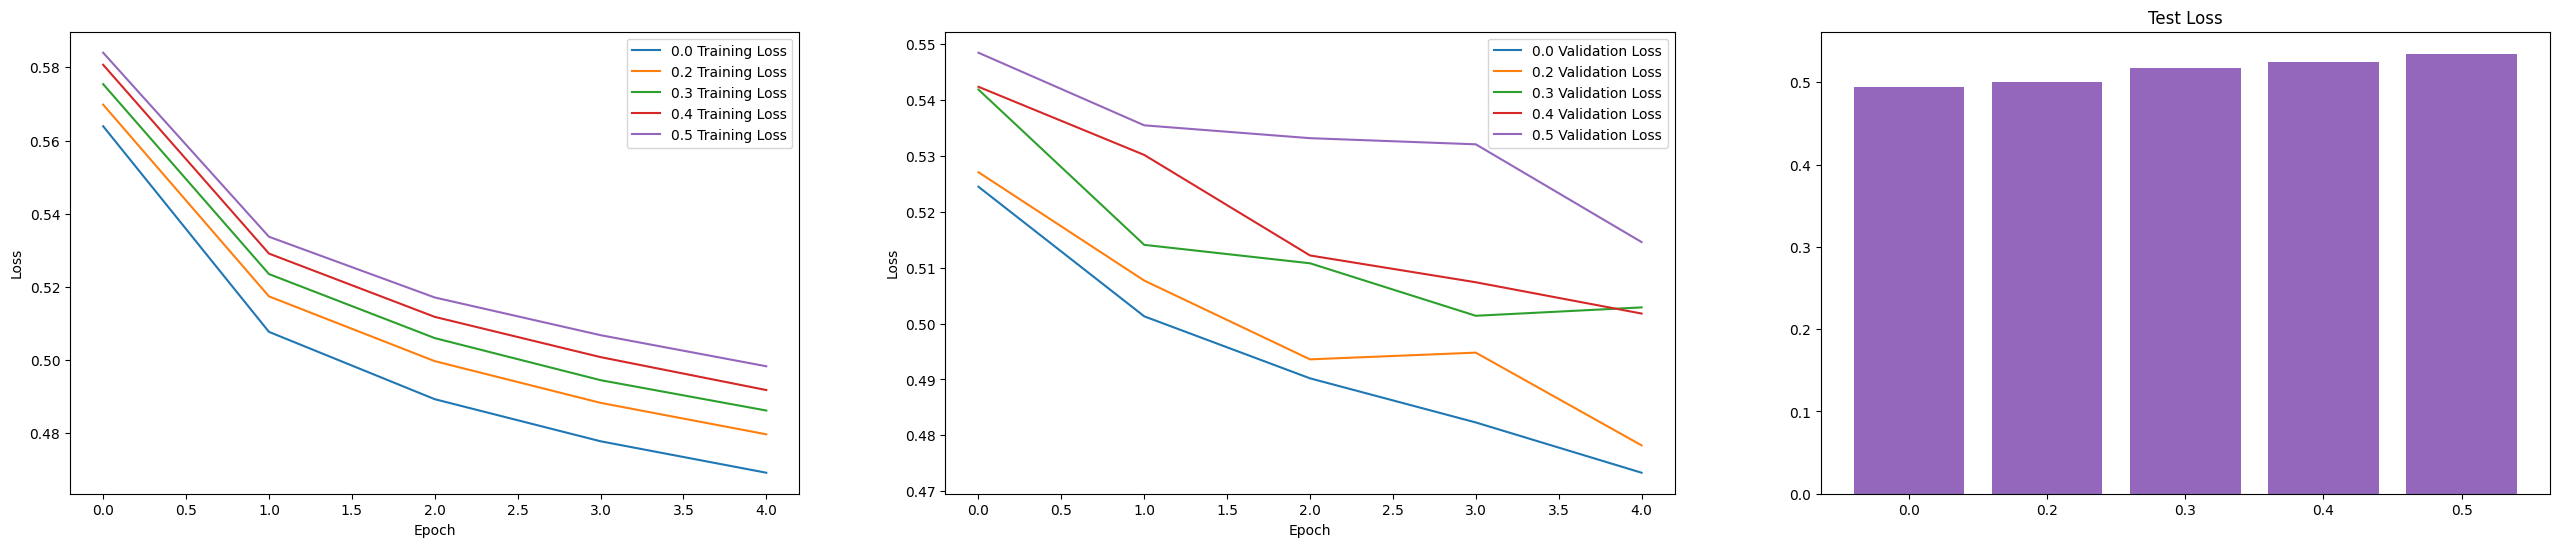

In [ ]:
# Plotting the stupidly collected data
plt.figure(figsize=(32, 6))
for stride in training_losses.keys():
  # Training Losses
  plt.subplot(1, 3, 1)
  plt.plot(training_losses[stride], label=stride + " Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  # Validation Losses
  plt.subplot(1, 3, 2)
  plt.plot(training_validation_losses[stride], label=stride + " Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

  # Test Losses
  plt.subplot(1, 3, 3)
  plt.title("Test Loss")
  plt.bar(test_loss.keys(), test_loss.values())
plt.show()

### Finding Best Recurrent Dropout

Conclusion: Didn't finish testing all possible, but the general trend is that it is getting worse. Will need to test on a higher layer neural network if more layers is better.

Sticking with no dropout for now.

In [ ]:
w1 = WindowGenerator(40, 40, 40, 20, train_ts, validate_ts, test_ts, labels, input_labels, output_labels)
test_ds = w1.test
train_ds = w1.train
val_ds = w1.val

In [ ]:
num_features = 16
OUTPUT_STEPS = 40
# Simple model being used
dropout_lstm = keras.Sequential([
    layers.LSTM(46, return_sequences=False, recurrent_dropout=0.3),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(dropout_lstm, train_ds, val_ds, patience=5)

Epoch 1/5
1104/1104 [==============================] - 73s 61ms/step - loss: 0.5904 - mean_absolute_error: 0.4485 - val_loss: 0.5379 - val_mean_absolute_error: 0.3818
Epoch 2/5
1104/1104 [==============================] - 69s 63ms/step - loss: 0.5294 - mean_absolute_error: 0.4049 - val_loss: 0.5156 - val_mean_absolute_error: 0.3656
Epoch 3/5
1104/1104 [==============================] - 66s 60ms/step - loss: 0.5138 - mean_absolute_error: 0.3942 - val_loss: 0.5058 - val_mean_absolute_error: 0.3621
Epoch 4/5
1104/1104 [==============================] - 66s 59ms/step - loss: 0.5060 - mean_absolute_error: 0.3895 - val_loss: 0.5025 - val_mean_absolute_error: 0.3586
Epoch 5/5
1104/1104 [==============================] - 66s 59ms/step - loss: 0.5002 - mean_absolute_error: 0.3863 - val_loss: 0.4999 - val_mean_absolute_error: 0.3578


In [ ]:
dropout_lstm.evaluate(test_ds)

126/126 [==============================] - 2s 15ms/step - loss: 0.5200 - mean_absolute_error: 0.3766


[0.5199556946754456, 0.37661677598953247]

In [ ]:
# Stupid Comparison Code Continued
# Key is dropout rate
training_losses = {
    "0.0": [0.5899, 0.5254, 0.5084, 0.4994, 0.4927],
    "0.2": [0.5891, 0.5283, 0.5117, 0.5032, 0.4968],
    "0.3": [0.5904, 0.5294, 0.5138, 0.5060, 0.5002],
    "0.4": [],
    "0.5": []
}

training_validation_losses = {
    "0.0": [0.5494, 0.5197, 0.5036, 0.4981, 0.4886],
    "0.2": [0.5492, 0.5215, 0.5150, 0.5093, 0.5054],
    "0.3": [0.5379, 0.5156, 0.5058, 0.5025, 0.4999],
    "0.4": [],
    "0.5": []
}

test_loss = {
    "0.0": 0.5092,
    "0.2": 0.5288,
    "0.3": 0.5200,
    "0.4": 0,
    "0.5": 0
}

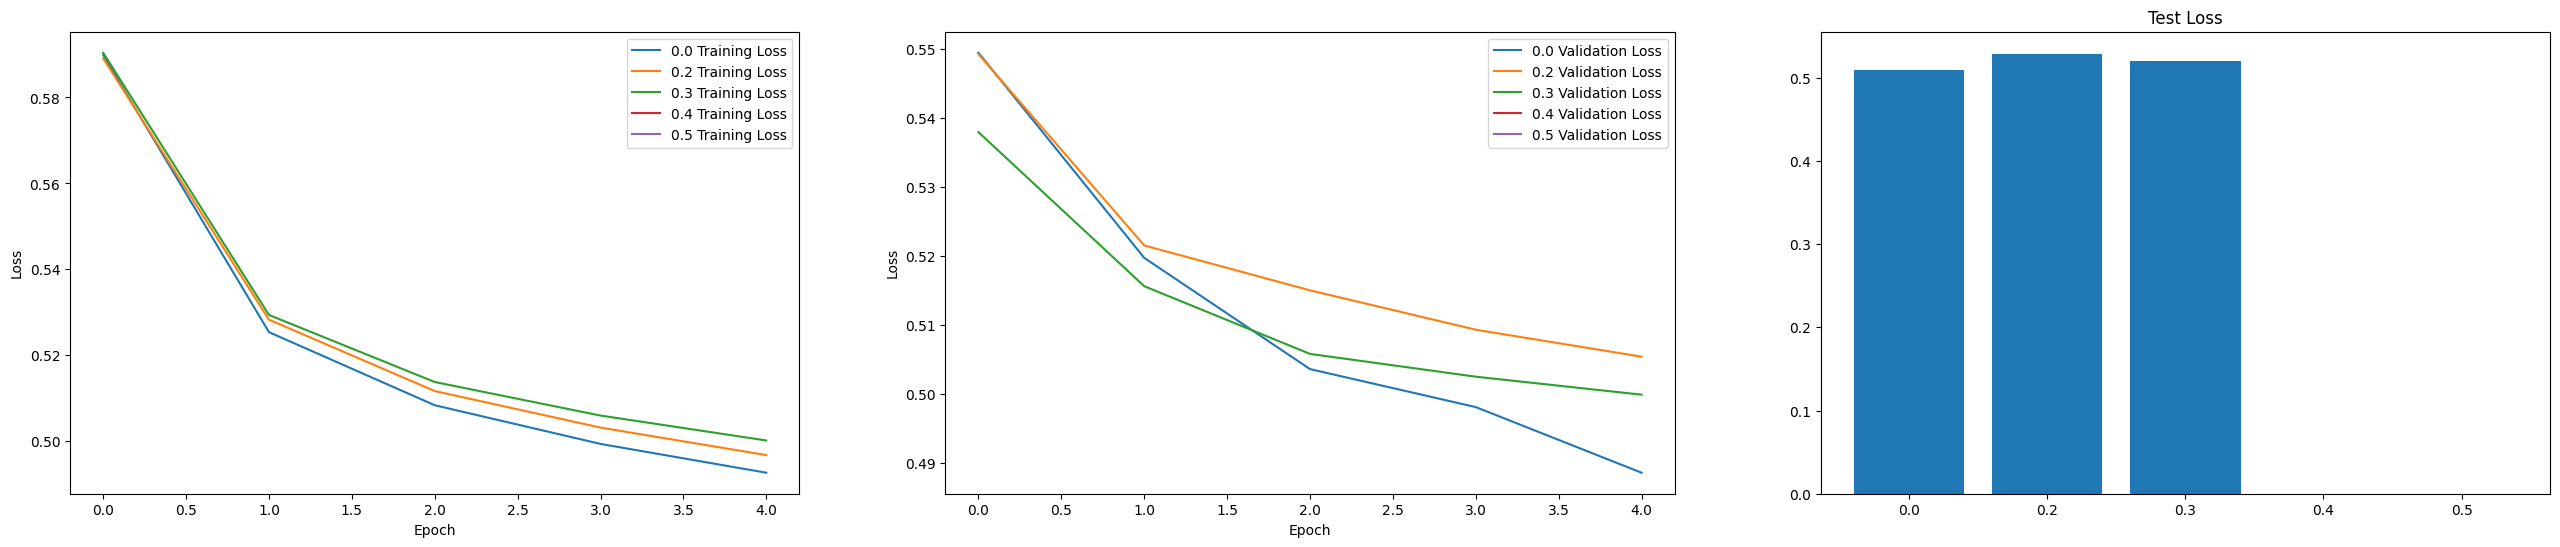

In [ ]:
# Plotting the stupidly collected data
plt.figure(figsize=(32, 6))
for stride in training_losses.keys():
  # Training Losses
  plt.subplot(1, 3, 1)
  plt.plot(training_losses[stride], label=stride + " Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  # Validation Losses
  plt.subplot(1, 3, 2)
  plt.plot(training_validation_losses[stride], label=stride + " Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

# Test Losses
plt.subplot(1, 3, 3)
plt.title("Test Loss")
plt.bar(test_loss.keys(), test_loss.values())
plt.show()

## Finding Best Activation Function

Conclusion: Seems like the original setup is already good, but relu as `recurrent_activation` could be helpful because it has the lowest validation loss.

Will stick with tanh/sigmoid, but open to try sigmoid/relu, then tanh/relu

In [ ]:
w0 = WindowGenerator(40, 40, 40, 20, train_ts, validate_ts, test_ts, labels, input_labels, output_labels)
test_ds = w0.test
val_ds = w0.val
train_ds = w0.train

In [ ]:
num_features = 16
OUTPUT_STEPS = 40
# Simple model being used
activation_lstm = keras.Sequential([
    layers.LSTM(23, return_sequences=False, activation="tanh", recurrent_activation="relu"),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(activation_lstm, train_ds, val_ds, patience=5)

Epoch 1/5
1104/1104 [==============================] - 32s 26ms/step - loss: 0.6704 - mean_absolute_error: 0.5067 - val_loss: 0.6011 - val_mean_absolute_error: 0.4340
Epoch 2/5
1104/1104 [==============================] - 26s 24ms/step - loss: 0.5914 - mean_absolute_error: 0.4512 - val_loss: 0.5465 - val_mean_absolute_error: 0.4060
Epoch 3/5
1104/1104 [==============================] - 29s 27ms/step - loss: 0.5658 - mean_absolute_error: 0.4298 - val_loss: 0.5261 - val_mean_absolute_error: 0.3860
Epoch 4/5
1104/1104 [==============================] - 27s 24ms/step - loss: 0.5564 - mean_absolute_error: 0.4219 - val_loss: 0.5243 - val_mean_absolute_error: 0.3790
Epoch 5/5
1104/1104 [==============================] - 28s 25ms/step - loss: 0.5518 - mean_absolute_error: 0.4179 - val_loss: 0.5184 - val_mean_absolute_error: 0.3846


In [ ]:
activation_lstm.evaluate(test_ds)

126/126 [==============================] - 1s 7ms/step - loss: 0.5314 - mean_absolute_error: 0.3984


[0.5314033627510071, 0.3983853757381439]

In [ ]:
# Stupid Comparison Code Continued
# Key is Activation / Recurrent Activation
training_losses = {
    "TanH/Sigmoid": [0.6260, 0.5535, 0.5355, 0.5256, 0.5201], # Default
    "Sigmoid/Sigmoid": [0.6985, 0.6057, 0.5705, 0.5577, 0.5496],
    "TanH/TanH": [0.6274, 0.5544, 0.5384, 0.5302, 0.5255],
    #"ReLU/Sigmoid": [1.2, 1.1007, 1.0294, 0.9486, 0.9528 ], # Actual starting loss was 74.6448, but that would ruin the graphs
    "Sigmoid/ReLU": [0.6192, 0.5661, 0.5550, 0.5471, 0.5460],
    #"ReLU/TanH": [0.8647, 1.1204, 0.8805, 0.8667, 2.1722],
    "TanH/ReLU": [0.6704, 0.5914, 0.5658, 0.5564, 0.5518]
}

training_validation_losses = {
    "TanH/Sigmoid": [0.5733, 0.5393, 0.5314, 0.5196, 0.5183], # Default
    "Sigmoid/Sigmoid": [0.6412, 0.5809, 0.5561, 0.5432, 0.5353],
    "TanH/TanH": [0.5825, 0.5528, 0.5367, 0.5250, 0.5273],
    #"ReLU/Sigmoid": [1.1443, 1.0699, 1.0098, 1.1905, 0.9728],
    "Sigmoid/ReLU": [0.5546, 0.5351, 0.5226, 0.5177, 0.5137],
    #"ReLU/TanH": [0.8778, 0.8818, 1.1650, 1.1652, 0.9737],
    "TanH/ReLU": [0.6011, 0.5465, 0.5261, 0.5243, 0.5184]
}

test_loss = {
    "TanH/Sigmoid": 0.5352, # Default
    "Sigmoid/Sigmoid": 0.5547,
    "TanH/TanH": 0.5577,
    #"ReLU/Sigmoid": 1.0070,
    "Sigmoid/ReLU": 0.5371,
    #"ReLU/TanH": 1.0825,
    "TanH/ReLU": 0.5314
}

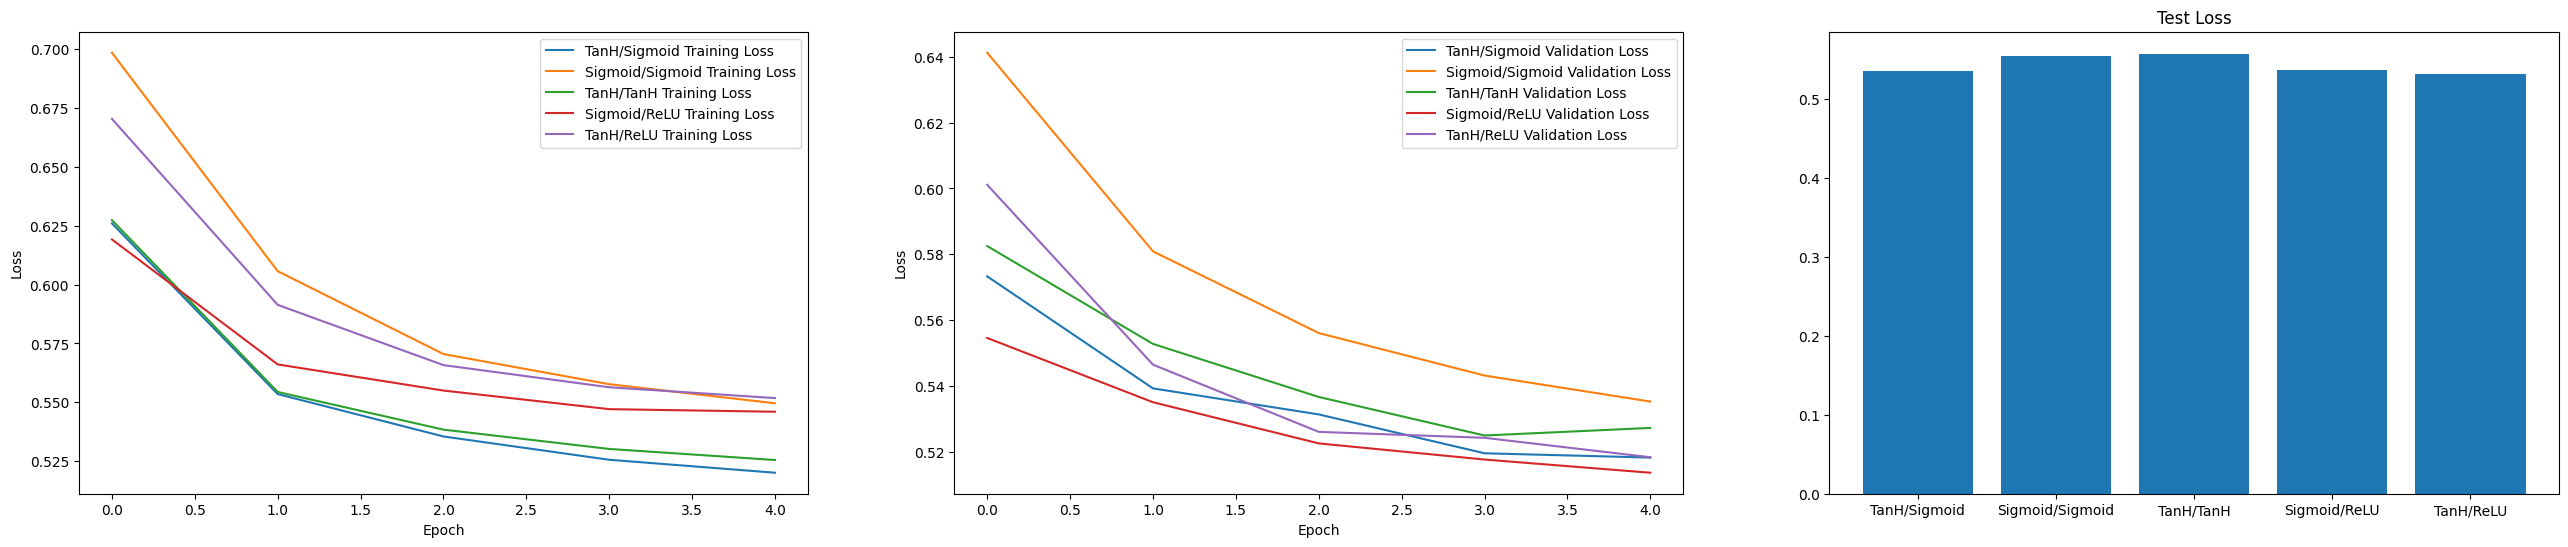

In [ ]:
# Plotting the stupidly collected data
plt.figure(figsize=(32, 6))
for stride in training_losses.keys():
  # Training Losses
  plt.subplot(1, 3, 1)
  plt.plot(training_losses[stride], label=stride + " Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  # Validation Losses
  plt.subplot(1, 3, 2)
  plt.plot(training_validation_losses[stride], label=stride + " Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

# Test Losses
plt.subplot(1, 3, 3)
plt.title("Test Loss")
plt.bar(test_loss.keys(), test_loss.values())

plt.show()

## Finding Best Optimizer Setup

### Finding Best Weight Decay rate

Conclusion: Although the loss increases as we increase weight decay, a weight decay of 0.0004 has a sharper decay in loss than no weight decay, so it may be worth exploring.

** Accidentally using Tanh and Relu for the activation + recurrent activation respectively. Probably shouldn't change results too much.

In [ ]:
MAX_EPOCHS = 5

def compile_and_fit(model, train, validate, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(weight_decay=0.005),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(train, epochs=MAX_EPOCHS,
                      validation_data=validate,
                      callbacks=[early_stopping])
  return history

In [ ]:
num_features = 16
OUTPUT_STEPS = 40
# Simple model being used
weight_decay_lstm = keras.Sequential([
    layers.LSTM(23, return_sequences=False, activation="tanh", recurrent_activation="relu"),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(weight_decay_lstm, train_ds, val_ds, patience=5)

Epoch 1/5
1104/1104 [==============================] - 34s 26ms/step - loss: 0.6710 - mean_absolute_error: 0.5090 - val_loss: 0.6681 - val_mean_absolute_error: 0.4575
Epoch 2/5
1104/1104 [==============================] - 27s 25ms/step - loss: 0.6034 - mean_absolute_error: 0.4630 - val_loss: 0.6203 - val_mean_absolute_error: 0.4205
Epoch 3/5
1104/1104 [==============================] - 31s 28ms/step - loss: 0.5781 - mean_absolute_error: 0.4402 - val_loss: 0.5646 - val_mean_absolute_error: 0.4017
Epoch 4/5
1104/1104 [==============================] - 29s 27ms/step - loss: 0.5649 - mean_absolute_error: 0.4286 - val_loss: 0.5514 - val_mean_absolute_error: 0.3889
Epoch 5/5
1104/1104 [==============================] - 28s 25ms/step - loss: 0.5549 - mean_absolute_error: 0.4209 - val_loss: 0.5370 - val_mean_absolute_error: 0.3877


In [ ]:
weight_decay_lstm.evaluate(test_ds)

126/126 [==============================] - 1s 8ms/step - loss: 0.6005 - mean_absolute_error: 0.4142


[0.6005100011825562, 0.4141939580440521]

In [ ]:
# Stupid Comparison Code Continued
# Key is Weight Decay
training_losses = {
    "0": [0.6691, 0.5781, 0.5598, 0.5532, 0.5481],
    "0.0001": [0.6822, 0.5976, 0.5739, 0.5636, 0.5563],
    "0.0004": [0.6712, 0.5917, 0.5701, 0.5588, 0.5514],
    "0.001": [0.6684, 0.5889, 0.5664, 0.5584, 0.5506],
    "0.005": [0.6710, 0.6034, 0.5781, 0.5649, 0.5549]
}

training_validation_losses = {
    "0": [0.5844, 0.5481, 0.5357, 0.5247, 0.5166],
    "0.0001": [0.6153, 0.5579, 0.5380, 0.5348, 0.5313],
    "0.0004": [0.6181, 0.5767, 0.5574, 0.5355, 0.5253],
    "0.001": [0.6354, 0.5745, 0.5622, 0.5358, 0.5317],
    "0.005": [0.6681, 0.6203, 0.5646, 0.5514, 0.5370]
}

test_loss = {
    "0": 0.5301,
    "0.0001": 0.5498,
    "0.0004": 0.5521,
    "0.001": 0.5740,
    "0.005": 0.6005
}

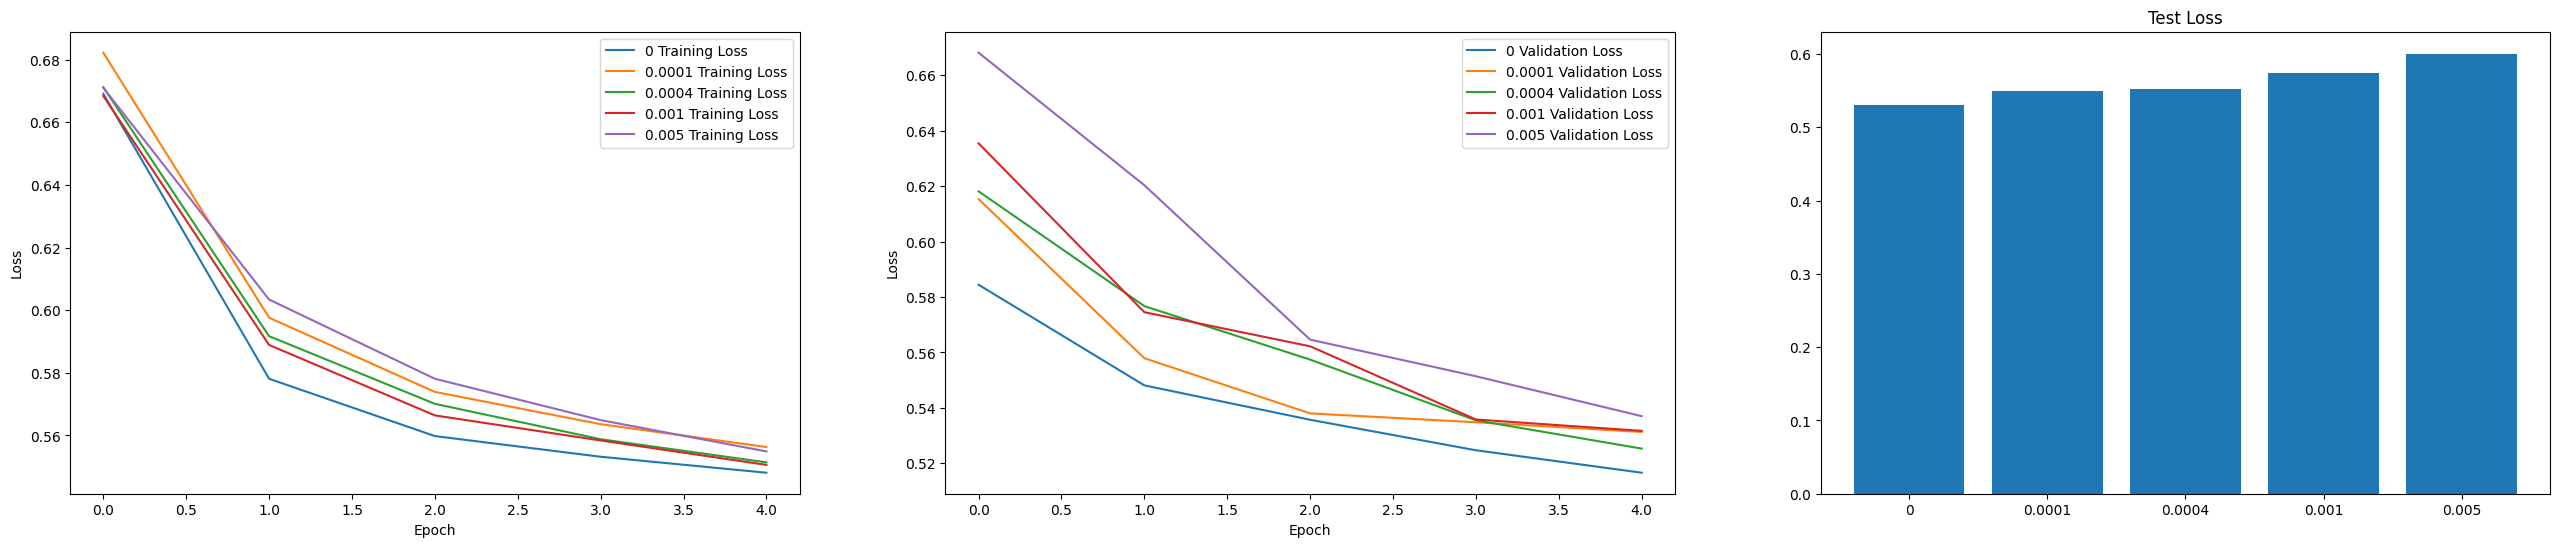

In [ ]:
# Plotting the stupidly collected data
plt.figure(figsize=(32, 6))
for stride in training_losses.keys():
  # Training Losses
  plt.subplot(1, 3, 1)
  plt.plot(training_losses[stride], label=stride + " Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  # Validation Losses
  plt.subplot(1, 3, 2)
  plt.plot(training_validation_losses[stride], label=stride + " Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

# Test Losses
plt.subplot(1, 3, 3)
plt.title("Test Loss")
plt.bar(test_loss.keys(), test_loss.values())

plt.show()

### Finding Best Learning Rate

Conclusion: Surprisingly, the higher learning rates do better, but risk causing nan to show up.

I will use 0.005 for now, but if the number of epochs somehow causes the error to become nan, I will use a learning rate scheduler (seems pretty flexible for tensorflow, just write a function and add it to the callback: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler)

** Accidentally using Tanh and Relu for the activation + recurrent activation respectively. Probably shouldn't change results too much.

In [ ]:
MAX_EPOCHS = 5

def compile_and_fit(model, train, validate, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(train, epochs=MAX_EPOCHS,
                      validation_data=validate,
                      callbacks=[early_stopping])
  return history

In [ ]:
num_features = 16
OUTPUT_STEPS = 40
# Simple model being used
lr_lstm = keras.Sequential([
    layers.LSTM(23, return_sequences=False, activation="tanh", recurrent_activation="relu"),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(lr_lstm, train_ds, val_ds, patience=5)

Epoch 1/5
1104/1104 [==============================] - 32s 25ms/step - loss: 0.6187 - mean_absolute_error: 0.4724 - val_loss: 0.5570 - val_mean_absolute_error: 0.4097
Epoch 2/5
1104/1104 [==============================] - 29s 26ms/step - loss: 0.5720 - mean_absolute_error: 0.4357 - val_loss: 0.5243 - val_mean_absolute_error: 0.3839
Epoch 3/5
1104/1104 [==============================] - 28s 25ms/step - loss: 0.5549 - mean_absolute_error: 0.4221 - val_loss: 0.5170 - val_mean_absolute_error: 0.3862
Epoch 4/5
1104/1104 [==============================] - 27s 25ms/step - loss: 0.5511 - mean_absolute_error: 0.4194 - val_loss: 0.5208 - val_mean_absolute_error: 0.3870
Epoch 5/5
1104/1104 [==============================] - 29s 27ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan


In [ ]:
lr_lstm.evaluate(test_ds)

126/126 [==============================] - 1s 7ms/step - loss: nan - mean_absolute_error: nan


[nan, nan]

In [ ]:
# Stupid Comparison Code Continued
# Key is Learning Rate
training_losses = {
    "0.0001": [0.8407, 0.7588, 0.7154, 0.6973, 0.6846],
    "0.001": [0.6633, 0.5859, 0.5646, 0.5543, 0.5467],
    "0.005": [0.6156, 0.5621, 0.5489, 0.5444, 0.5415],
    "0.01": [0.6187, 0.5720, 0.5549, 0.5511] # Last one was not a number
}

training_validation_losses = {
    "0.0001": [0.8056, 0.7357, 0.7036, 0.6853, 0.6688],
    "0.001": [0.5844, 0.5481, 0.5357, 0.5247, 0.5166],
    "0.005": [0.5569, 0.5228, 0.5176, 0.5185, 0.5100],
    "0.01": [0.5570, 0.5243, 0.5170, 0.5208]
}

test_loss = {
    "0.0001": 0.6973,
    "0.001": 0.5231,
    "0.005": 0.5252,
    "0.01": 0 # Last one was not a number
}

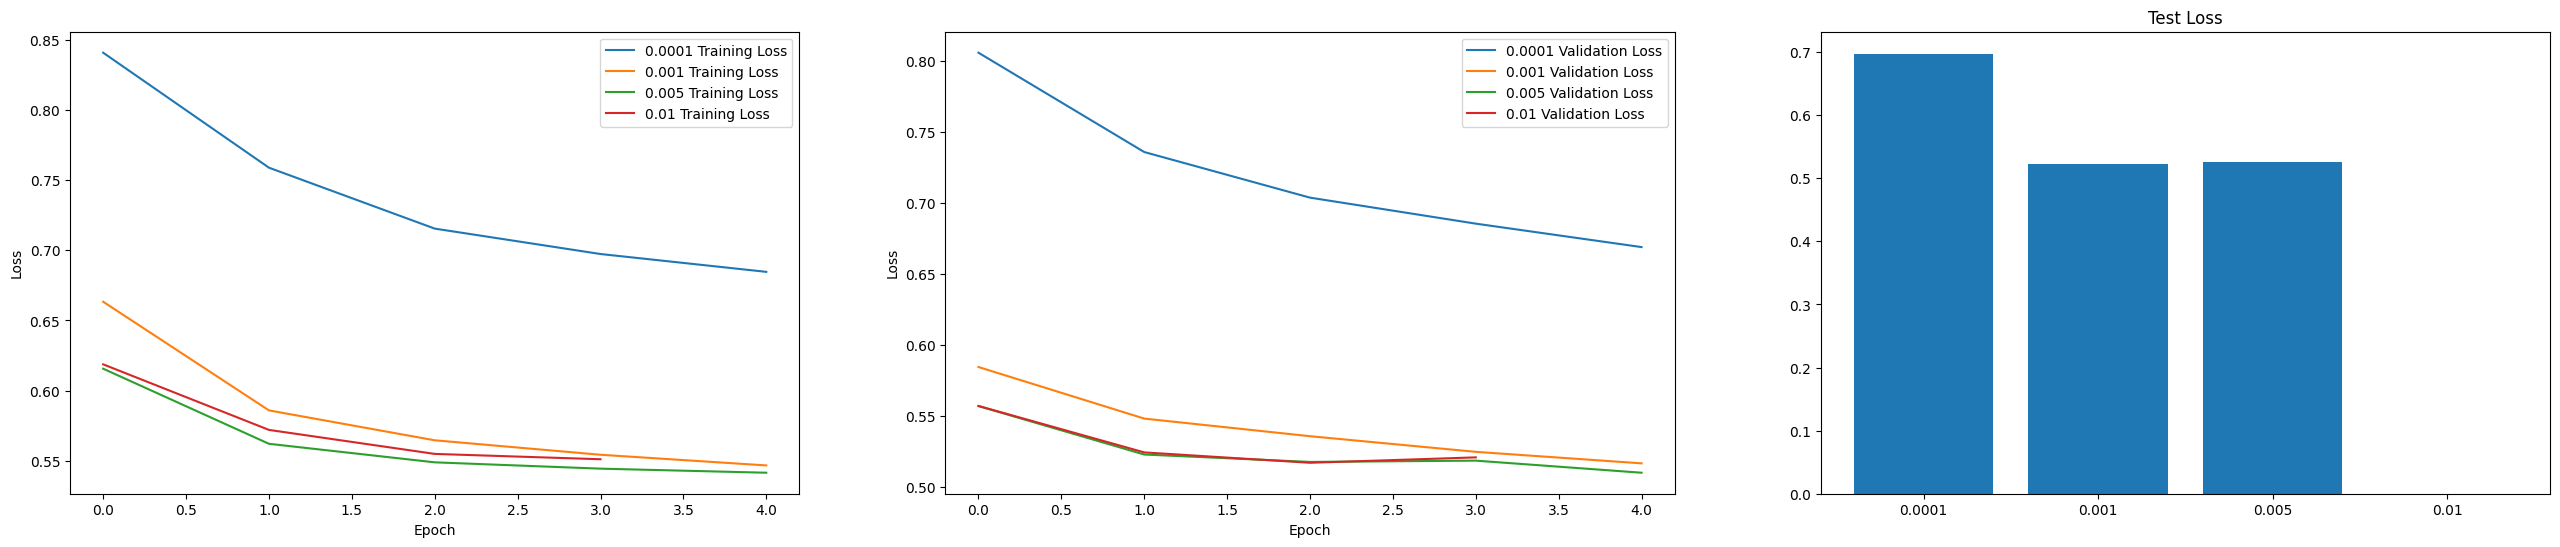

In [ ]:
# Plotting the stupidly collected data
plt.figure(figsize=(32, 6))
for stride in training_losses.keys():
  # Training Losses
  plt.subplot(1, 3, 1)
  plt.plot(training_losses[stride], label=stride + " Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  # Validation Losses
  plt.subplot(1, 3, 2)
  plt.plot(training_validation_losses[stride], label=stride + " Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

# Test Losses
plt.subplot(1, 3, 3)
plt.title("Test Loss")
plt.bar(test_loss.keys(), test_loss.values())

plt.show()

### Finding Best Momentum

Conclusion: Activating EMA is actually better, and it is optimal at 0.5 momentum.

In [ ]:
MAX_EPOCHS = 5

def compile_and_fit(model, train, validate, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(use_ema=True, ema_momentum=0.2),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(train, epochs=MAX_EPOCHS,
                      validation_data=validate,
                      callbacks=[early_stopping])
  return history

In [ ]:
num_features = 16
OUTPUT_STEPS = 40
# Simple model being used
mom_lstm = keras.Sequential([
    layers.LSTM(23, return_sequences=False),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(mom_lstm, train_ds, val_ds, patience=5)

Epoch 1/5
1104/1104 [==============================] - 37s 28ms/step - loss: 0.6228 - mean_absolute_error: 0.4697 - val_loss: 0.5667 - val_mean_absolute_error: 0.3975
Epoch 2/5
1104/1104 [==============================] - 32s 29ms/step - loss: 0.5515 - mean_absolute_error: 0.4182 - val_loss: 0.5362 - val_mean_absolute_error: 0.3824
Epoch 3/5
1104/1104 [==============================] - 29s 27ms/step - loss: 0.5337 - mean_absolute_error: 0.4053 - val_loss: 0.5262 - val_mean_absolute_error: 0.3740
Epoch 4/5
1104/1104 [==============================] - 32s 29ms/step - loss: 0.5247 - mean_absolute_error: 0.3989 - val_loss: 0.5156 - val_mean_absolute_error: 0.3673
Epoch 5/5
1104/1104 [==============================] - 32s 29ms/step - loss: 0.5191 - mean_absolute_error: 0.3946 - val_loss: 0.5133 - val_mean_absolute_error: 0.3664


In [ ]:
mom_lstm.evaluate(test_ds)

126/126 [==============================] - 1s 7ms/step - loss: 0.5336 - mean_absolute_error: 0.3825


[0.5336235165596008, 0.3824760913848877]

In [ ]:
# Stupid Comparison Code Continued
# Key is EMA momentum
training_losses = {
    "1": [0.6242, 0.5533, 0.5348, 0.5248, 0.5181], # Default, no EMA
    "0.99": [0.6252, 0.5501, 0.5331, 0.5247, 0.5184],
    "0.8": [0.6274, 0.5525, 0.5340, 0.5254, 0.5193],
    "0.5": [0.6249, 0.5515, 0.5338, 0.5241, 0.5181],
    "0.2": [0.6228, 0.5515, 0.5337, 0.5247, 0.5191]
}

training_validation_losses = {
    "1": [0.5733, 0.5440, 0.5276, 0.5212, 0.5223], # Default, no EMA
    "0.99": [0.5730, 0.5442, 0.5417, 0.5342, 0.5308],
    "0.8": [0.5788, 0.5425, 0.5261, 0.5192, 0.5156],
    "0.5": [0.5670, 0.5327, 0.5203, 0.5132, 0.5098],
    "0.2": [0.5667, 0.5362, 0.5262, 0.5156, 0.5133]
}

test_loss = {
    "1": 0.5478, # Default, no EMA
    "0.99": 0.5454,
    "0.8": 0.5337,
    "0.5": 0.5316,
    "0.2": 0.5336
}

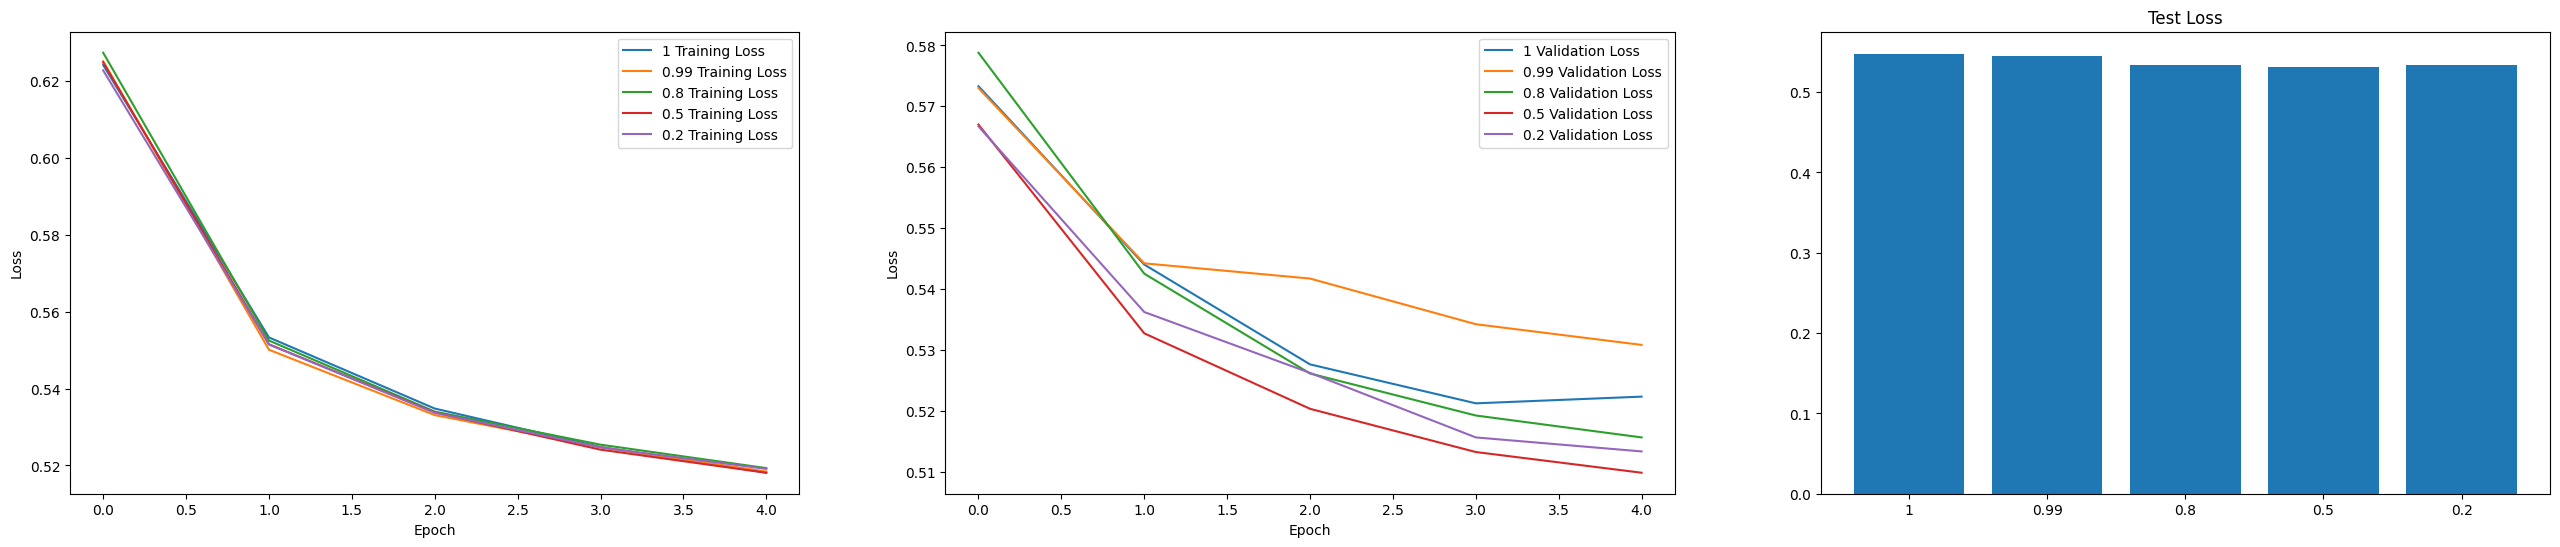

In [ ]:
# Plotting the stupidly collected data
plt.figure(figsize=(32, 6))
for stride in training_losses.keys():
  # Training Losses
  plt.subplot(1, 3, 1)
  plt.plot(training_losses[stride], label=stride + " Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  # Validation Losses
  plt.subplot(1, 3, 2)
  plt.plot(training_validation_losses[stride], label=stride + " Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

# Test Losses
plt.subplot(1, 3, 3)
plt.title("Test Loss")
plt.bar(test_loss.keys(), test_loss.values())

plt.show()

### Regularizer

Conclusion: Like loss, adding a regularizer makes the training, validation, and test loss worse, but for recurrent regularization using L2 regularization, it isn't far off, and in fact can perform better on the test loss.

Since our model may be big and trained for many epochs, I will use an L2 regularizer with the 0.05 parameter.

In [ ]:
num_features = 16
OUTPUT_STEPS = 40
# Simple model being used
reg_lstm = keras.Sequential([
    keras.layers.Bidirectional(layers.LSTM(92, return_sequences=False)),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(reg_lstm, train_ds, val_ds, patience=5)

Epoch 1/5
1104/1104 [==============================] - 105s 84ms/step - loss: 0.5489 - mean_absolute_error: 0.4183 - val_loss: 0.5101 - val_mean_absolute_error: 0.3689
Epoch 2/5
1104/1104 [==============================] - 89s 81ms/step - loss: 0.4962 - mean_absolute_error: 0.3830 - val_loss: 0.4921 - val_mean_absolute_error: 0.3631
Epoch 3/5
1104/1104 [==============================] - 89s 80ms/step - loss: 0.4788 - mean_absolute_error: 0.3728 - val_loss: 0.4827 - val_mean_absolute_error: 0.3521
Epoch 4/5
1104/1104 [==============================] - 96s 87ms/step - loss: 0.4664 - mean_absolute_error: 0.3664 - val_loss: 0.4713 - val_mean_absolute_error: 0.3462
Epoch 5/5
1104/1104 [==============================] - 89s 81ms/step - loss: 0.4580 - mean_absolute_error: 0.3616 - val_loss: 0.4795 - val_mean_absolute_error: 0.3516


In [ ]:
reg_lstm.evaluate(test_ds)

126/126 [==============================] - 3s 22ms/step - loss: 0.5001 - mean_absolute_error: 0.3725


[0.500106930732727, 0.3724637031555176]

In [ ]:
# Stupid Comparison Code Continued
# Key is <where regularizer is applied>/<type>/<lambda>
training_losses = {
    "None": [0.6242, 0.5533, 0.5348, 0.5248, 0.5181],
    #"Kernel/L1/0.01": [0.8648, 0.6432, 0.6227, 0.6093, 0.6007],
    "Kernel/L2/0.01": [0.6754, 0.5819, 0.5627, 0.5512, 0.5448],
    "Recurrent/L1/0.01": [0.7314, 0.5611, 0.5478, 0.5404, 0.5353],
    "Recurrent/L2/0.01": [0.6370, 0.5571, 0.5415, 0.5334, 0.5290],
    #"Both/L1/0.01": [0.9962, 0.6364, 0.6187, 0.6101, 0.6032],
    #"Both/L2/0.01": [0.6856, 0.5801, 0.5652, 0.5579, 0.5542],
    #"Both/L1+L2/0.01": [0.8985, 0.6449, 0.6220, 0.6083, 0.5977],
    #"Both/L2+L1/0.01": [0.7806, 0.5866, 0.5747, 0.5678, 0.5644],
    #"Recurrent/L1/0.05": [1.1621, 0.5715, 0.5579, 0.5506, 0.5452],
    "Recurrent/L2/0.05": [0.6888, 0.5577, 0.5434, 0.5359, 0.5302],
}

training_validation_losses = {
    "None": [0.5733, 0.5440, 0.5276, 0.5212, 0.5223],
    #"Kernel/L1/0.01": [0.6845, 0.6406, 0.6255, 0.6105, 0.5973],
    "Kernel/L2/0.01": [0.6023, 0.5723, 0.5699, 0.5400, 0.5373],
    "Recurrent/L1/0.01": [0.5744, 0.5485, 0.5399, 0.5372, 0.5282],
    "Recurrent/L2/0.01": [0.5670, 0.5408, 0.5318, 0.5274, 0.5217],
    #"Both/L1/0.01": [0.6604, 0.6195, 0.6115, 0.5996, 0.5944],
    #"Both/L2/0.01": [0.5888, 0.5633, 0.5553, 0.5418, 0.5485],
    #"Both/L1+L2/0.01": [0.6819, 0.6383, 0.6289, 0.6160, 0.5923],
    #"Both/L2+L1/0.01": [0.5871, 0.5679, 0.5556, 0.5479, 0.5420],
    #"Recurrent/L1/0.05": [0.5862, 0.5581, 0.5513, 0.5431, 0.5395],
    "Recurrent/L2/0.05": [0.5778, 0.5512, 0.5356, 0.5279, 0.5220],
}

test_loss = {
    "None": 0.5478,
    #"Kernel/L1/0.01": 0.6154,
    "Kernel/L2/0.01": 0.5557,
    "Recurrent/L1/0.01": 0.5510,
    "Recurrent/L2/0.01": 0.5451,
    #"Both/L1/0.01": 0.6113,
    #"Both/L2/0.01": 0.5671,
    #"Both/L1+L2/0.01": 0.6107,
    #"Both/L2+L1/0.01": 0.5601,
    #"Recurrent/L1/0.05": 0.5588,
    "Recurrent/L2/0.05": 0.5405,
}

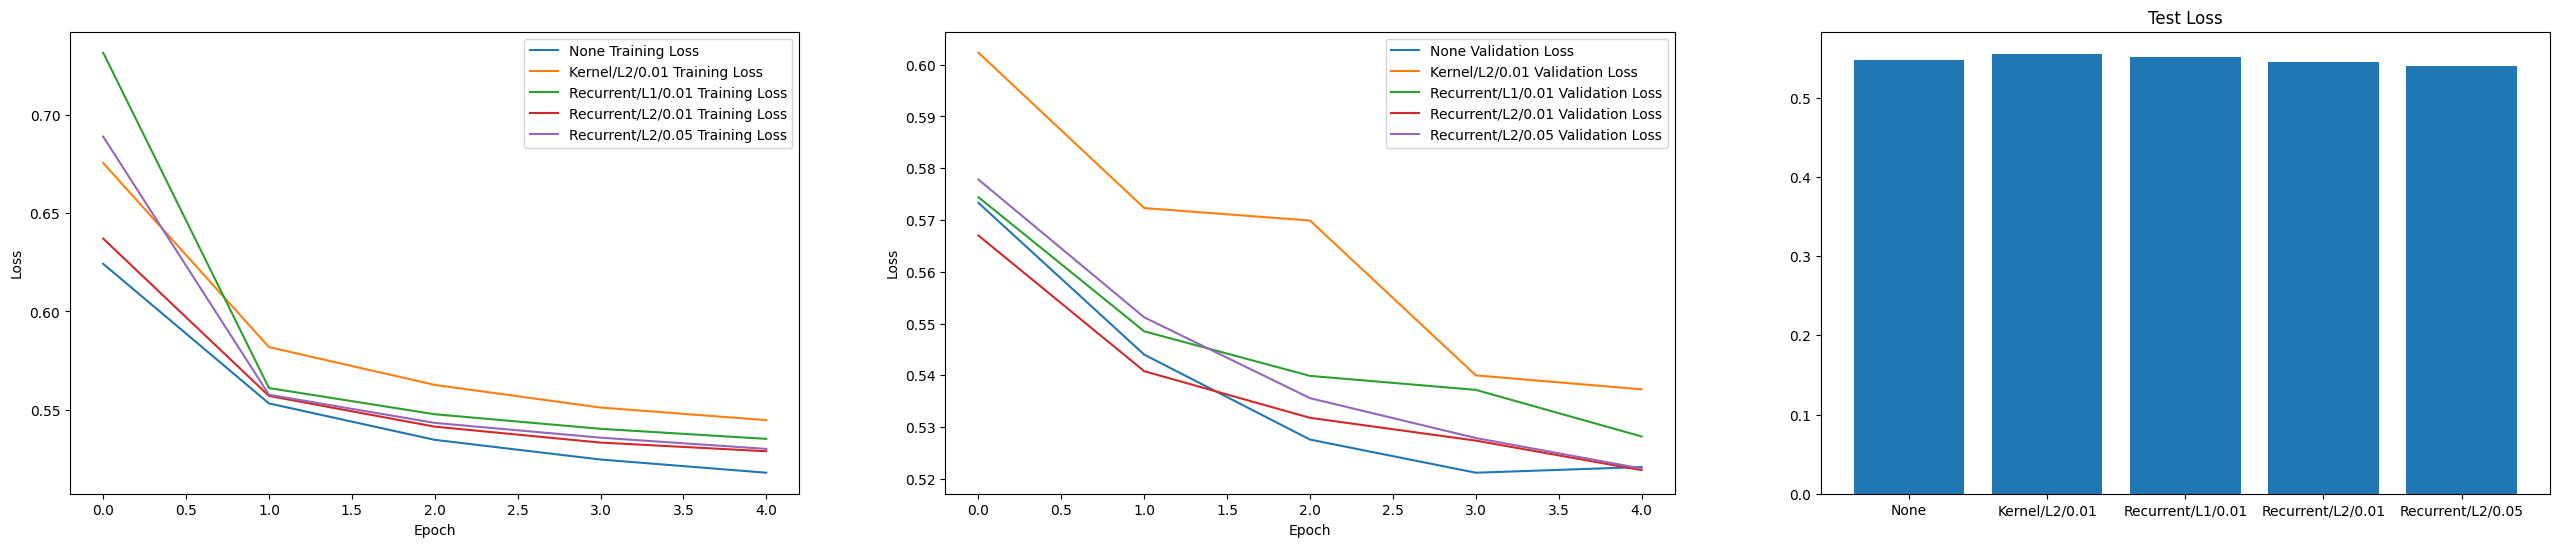

In [ ]:
# Plotting the stupidly collected data
plt.figure(figsize=(32, 6))
for stride in training_losses.keys():
  # Training Losses
  plt.subplot(1, 3, 1)
  plt.plot(training_losses[stride], label=stride + " Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  # Validation Losses
  plt.subplot(1, 3, 2)
  plt.plot(training_validation_losses[stride], label=stride + " Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

# Test Losses
plt.subplot(1, 3, 3)
plt.title("Test Loss")
plt.bar(test_loss.keys(), test_loss.values())

plt.show()

## Other Interesting Models

### Bidirectional

Conclusion: Higher nodes are better.

Note: A research paper shows that Bidirectional layers perform slighty worse

In [ ]:
num_features = 16
OUTPUT_STEPS = 40
# Simple model being used
bidirectional_lstm = keras.Sequential([
    keras.layers.Bidirectional(layers.LSTM(138, return_sequences=False)),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(bidirectional_lstm, train_ds, val_ds, patience=5)

Epoch 1/5
1104/1104 [==============================] - 187s 164ms/step - loss: 0.5403 - mean_absolute_error: 0.4133 - val_loss: 0.4942 - val_mean_absolute_error: 0.3584
Epoch 2/5
1104/1104 [==============================] - 173s 157ms/step - loss: 0.4878 - mean_absolute_error: 0.3786 - val_loss: 0.4825 - val_mean_absolute_error: 0.3532
Epoch 3/5
1104/1104 [==============================] - 169s 153ms/step - loss: 0.4676 - mean_absolute_error: 0.3667 - val_loss: 0.4648 - val_mean_absolute_error: 0.3439
Epoch 4/5
1104/1104 [==============================] - 179s 162ms/step - loss: 0.4550 - mean_absolute_error: 0.3601 - val_loss: 0.4544 - val_mean_absolute_error: 0.3400
Epoch 5/5
1104/1104 [==============================] - 182s 165ms/step - loss: 0.4451 - mean_absolute_error: 0.3548 - val_loss: 0.4577 - val_mean_absolute_error: 0.3402


In [ ]:
bidirectional_lstm.evaluate(test_ds)

126/126 [==============================] - 9s 73ms/step - loss: 0.4752 - mean_absolute_error: 0.3608


[0.47517481446266174, 0.3607582449913025]

In [ ]:
# Stupid Comparison Code Continued
# Key is number of nodes in bidirectional layer
training_losses = {
    "23, No Bi": [0.6228, 0.5527, 0.5350, 0.5255, 0.5196],
    "23": [0.5987, 0.5352, 0.5190, 0.5101, 0.5043],
    "46": [0.5681, 0.5114, 0.4954, 0.4855, 0.4787],
    "92": [0.5489, 0.4962, 0.4788, 0.4664, 0.4580],
    "138": [0.5403, 0.4878, 0.4676, 0.4550, 0.4451]
}

training_validation_losses = {
    "23, No Bi": [0.5703, 0.5240, 0.5308, 0.5260, 0.5213],
    "23": [0.5514, 0.5148, 0.5018, 0.4957, 0.4945],
    "46": [0.5233, 0.4994, 0.4867, 0.4810, 0.4776],
    "92": [0.5101, 0.4921, 0.4827, 0.4713, 0.4795],
    "138": [0.4942, 0.4825, 0.4648, 0.4544, 0.4577]
}

test_loss = {
    "23, No Bi": 0.5399,
    "23": 0.5149,
    "46": 0.4968,
    "92": 0.5001,
    "138": 0.4752
}

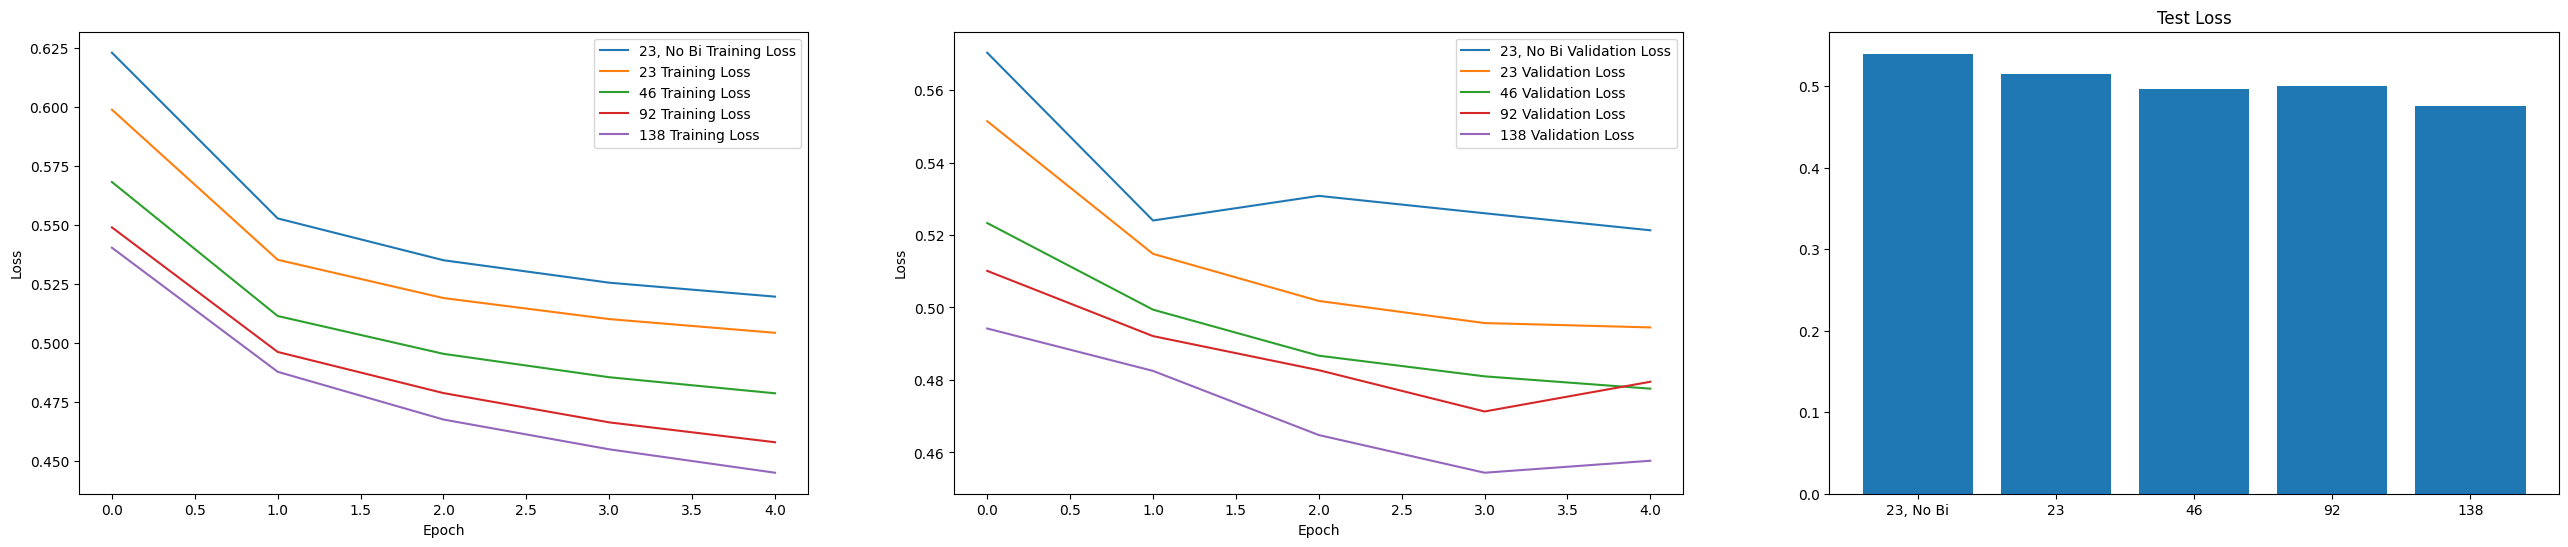

In [ ]:
# Plotting the stupidly collected data
plt.figure(figsize=(32, 6))
for stride in training_losses.keys():
  # Training Losses
  plt.subplot(1, 3, 1)
  plt.plot(training_losses[stride], label=stride + " Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  # Validation Losses
  plt.subplot(1, 3, 2)
  plt.plot(training_validation_losses[stride], label=stride + " Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

# Test Losses
plt.subplot(1, 3, 3)
plt.title("Test Loss")
plt.bar(test_loss.keys(), test_loss.values())

plt.show()

### Hidden Layers

#### Batch Normalization

#### LSTM Layers

### Convolutional LSTM

In [ ]:
num_features = 16
OUTPUT_STEPS = 40
# Simple model being used
bidirectional_lstm = keras.Sequential([
    keras.layers.Bidirectional(layers.LSTM(138, return_sequences=False)),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
# Stupid Comparison Code Continued
# Key is number of nodes in bidirectional layer
training_losses = {
    "23, No Bi": [0.6228, 0.5527, 0.5350, 0.5255, 0.5196],
    "23": [0.5987, 0.5352, 0.5190, 0.5101, 0.5043],
    "46": [0.5681, 0.5114, 0.4954, 0.4855, 0.4787],
    "92": [0.5489, 0.4962, 0.4788, 0.4664, 0.4580],
    "138": [0.5403, 0.4878, 0.4676, 0.4550, 0.4451]
}

training_validation_losses = {
    "23, No Bi": [0.5703, 0.5240, 0.5308, 0.5260, 0.5213],
    "23": [0.5514, 0.5148, 0.5018, 0.4957, 0.4945],
    "46": [0.5233, 0.4994, 0.4867, 0.4810, 0.4776],
    "92": [0.5101, 0.4921, 0.4827, 0.4713, 0.4795],
    "138": [0.4942, 0.4825, 0.4648, 0.4544, 0.4577]
}

test_loss = {
    "23, No Bi": 0.5399,
    "23": 0.5149,
    "46": 0.4968,
    "92": 0.5001,
    "138": 0.4752
}

In [ ]:
# Plotting the stupidly collected data
plt.figure(figsize=(32, 6))
for stride in training_losses.keys():
  # Training Losses
  plt.subplot(1, 3, 1)
  plt.plot(training_losses[stride], label=stride + " Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  # Validation Losses
  plt.subplot(1, 3, 2)
  plt.plot(training_validation_losses[stride], label=stride + " Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

# Test Losses
plt.subplot(1, 3, 3)
plt.title("Test Loss")
plt.bar(test_loss.keys(), test_loss.values())

plt.show()

## Loss Function
Goal: Penalize "jumping"

Resuolts: Doesn't help. Training for a really really long time, the first few times steps do become more accurate, but there are still jumps. What is worse is that as the errors are larger later in the time series prediction, it makes the overall model worse when autoregressively used and it also sometimes causes the curve to go upwards.

In [ ]:
class JumpLoss(keras.losses.Loss):
  def __init__(self):
    super().__init__()
    self.mse = keras.losses.MeanSquaredError()

  def call(self, y_true, y_pred):
    # # Does mean squared error loss, but place more penalty on errors in the beginning
    # error = tf.reduce_mean(tf.square(y_true - y_pred), axis=2) # Averaging errors over all features
    # error = tf.cast(error, dtype=tf.float32) # casting to float

    # # Create bias vector that weighs earlier losses more
    # # bias = tf.range(start=error.shape[1] + 1, limit=1, delta=-1, dtype=tf.float32)
    # bias = tf.constant(([10] + [1] * (len(y_pred[0]) - 1)), dtype=tf.float32)
    # # bias = tf.divide(bias, (tf.reduce_sum(bias)))# Normalize the bias
    # # Stack the bias into correct shape
    # final_bias = tf.stack([bias for _ in range(error.numpy().shape[0])])
    # return tf.reduce_mean(tf.multiply(final_bias, error)) # Take the mean of the scaled squared errors
    sample_weight = np.stack([[1.5] * 10 + [0.5] * 30 for _ in range(len(y_true))], axis=0)
    return self.mse(y_true, y_pred, sample_weight=sample_weight)

In [ ]:
y_pred = np.random.random(size=(32, 80, 16))
y_true = y_pred.copy()
y_true[:, 0] += 1
# print(y_true[:, 0] - y_pred[:, 0])
print(JumpLoss()(y_true, y_pred))
print(JumpLoss().mse(y_true, y_pred))

y_true[:, 0] -= 1
y_true[:, 1] += 1
print(JumpLoss()(y_true, y_pred))
print(JumpLoss().mse(y_true, y_pred))

# Just making a model for now

Bidirectional, Uneven Window: 0.3193 train loss, 0.3165 val loss, 0.3297 test loss; 80.96 second prediction error

Bidirectional (23, 46, 46): 0.3199 train loss, 0.3270 val loss 0.3241 test loss; 68.76 second prediction error

In [ ]:
MAX_EPOCHS = 5

def compile_and_fit(model, train, validate, loss=keras.losses.MeanSquaredError(), patience=2, epochs=MAX_EPOCHS):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(weight_decay=0.004, learning_rate=0.005, use_ema=True, ema_momentum=0.5),
                metrics=[tf.keras.metrics.MeanAbsoluteError()],
                run_eagerly=True)

  history = model.fit(train, epochs=epochs,
                      validation_data=validate,
                      callbacks=[early_stopping])
  return history

In [ ]:
OUTPUT_STEPS = 40
num_features = 5

In [ ]:
# test model
test_lstm = keras.Sequential([
    layers.LSTM(46, return_sequences=False, recurrent_regularizer=keras.regularizers.L2(0.05)),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(test_lstm, train_ds, val_ds, loss=JumpLoss(), patience=5, epochs=15)

Epoch 1/15
4416/4416 [==============================] - 999s 225ms/step - loss: 0.3261 - mean_absolute_error: 0.4093 - val_loss: 0.2799 - val_mean_absolute_error: 0.3480
Epoch 2/15
4416/4416 [==============================] - 963s 218ms/step - loss: 0.3008 - mean_absolute_error: 0.3878 - val_loss: 0.2745 - val_mean_absolute_error: 0.3487
Epoch 3/15
4416/4416 [==============================] - 1019s 231ms/step - loss: 0.2949 - mean_absolute_error: 0.3811 - val_loss: 0.2744 - val_mean_absolute_error: 0.3466
Epoch 4/15
4416/4416 [==============================] - 995s 225ms/step - loss: 0.2918 - mean_absolute_error: 0.3782 - val_loss: 0.2682 - val_mean_absolute_error: 0.3408
Epoch 5/15
4416/4416 [==============================] - 1024s 232ms/step - loss: 0.2897 - mean_absolute_error: 0.3763 - val_loss: 0.2730 - val_mean_absolute_error: 0.3471
Epoch 6/15
4416/4416 [==============================] - 950s 215ms/step - loss: 0.2882 - mean_absolute_error: 0.3749 - val_loss: 0.2665 - val_mean_a

In [ ]:
test_lstm.evaluate(test_ds)

460/460 [==============================] - 44s 95ms/step - loss: 0.2723 - mean_absolute_error: 0.3489


[0.27227020263671875, 0.348871648311615]

In [ ]:
test_lstm.save('/content/drive/MyDrive/Colab Notebooks/model/customLoss_46LSTM_2.5Stride.keras')

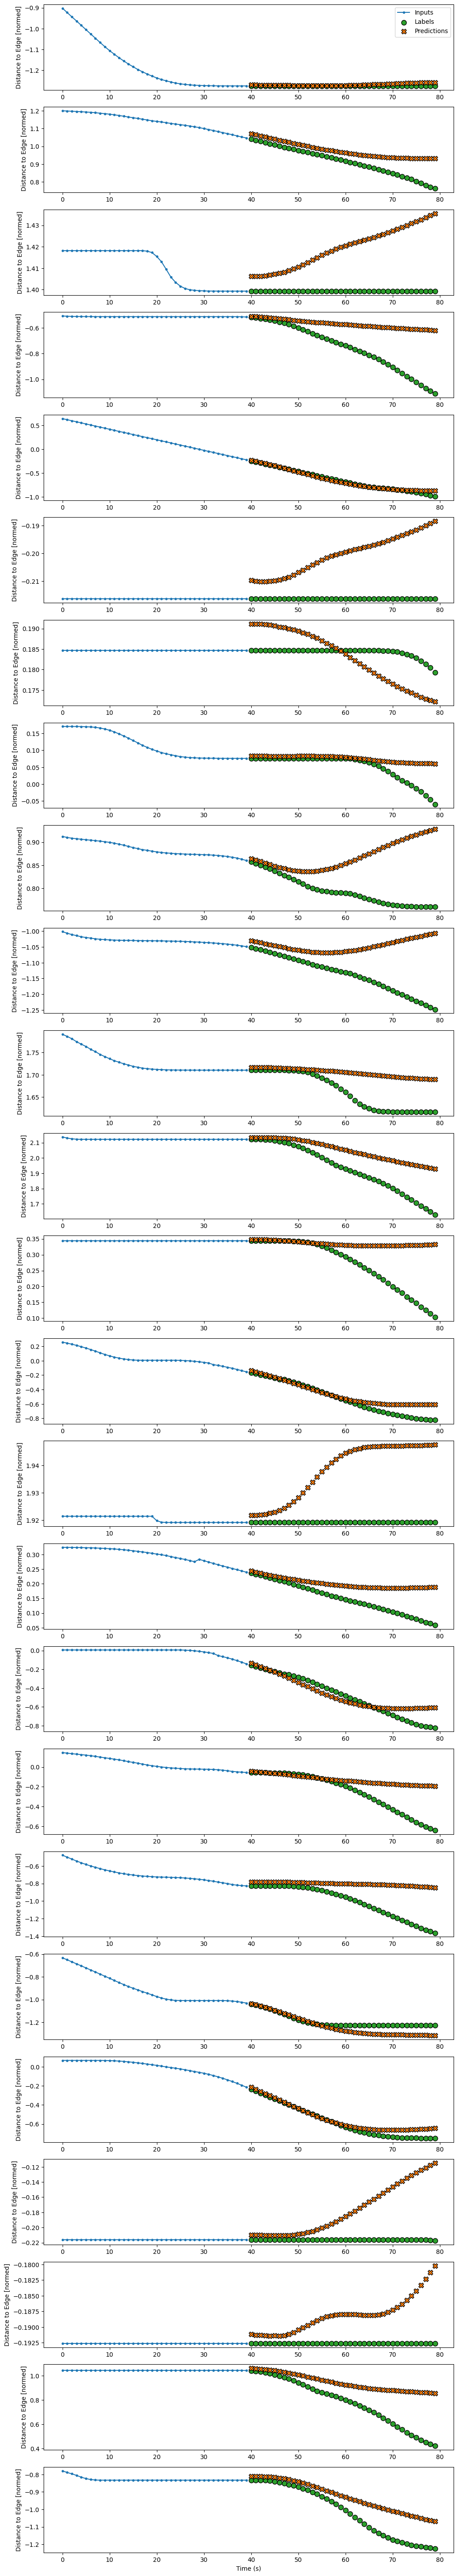

In [ ]:
w0.plot(train_ds, test_lstm, max_subplots=25)

# Model #1: Simple LSTM, Single-Shot Prediction

In [ ]:
simple_lstm = keras.Sequential([
    layers.LSTM(32, return_sequences=False),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
# Adding preprocessing head
history = compile_and_fit(simple_lstm, train_ds, val_ds)

Epoch 1/40
1104/1104 [==============================] - 31s 25ms/step - loss: 0.2896 - mean_absolute_error: 0.2739 - val_loss: 0.2695 - val_mean_absolute_error: 0.2537
Epoch 2/40
1104/1104 [==============================] - 27s 24ms/step - loss: 0.2481 - mean_absolute_error: 0.2450 - val_loss: 0.2483 - val_mean_absolute_error: 0.2382
Epoch 3/40
1104/1104 [==============================] - 27s 25ms/step - loss: 0.2366 - mean_absolute_error: 0.2343 - val_loss: 0.2403 - val_mean_absolute_error: 0.2314
Epoch 4/40
1104/1104 [==============================] - 28s 25ms/step - loss: 0.2312 - mean_absolute_error: 0.2277 - val_loss: 0.2373 - val_mean_absolute_error: 0.2249
Epoch 5/40
1104/1104 [==============================] - 29s 26ms/step - loss: 0.2280 - mean_absolute_error: 0.2237 - val_loss: 0.2342 - val_mean_absolute_error: 0.2206
Epoch 6/40
1104/1104 [==============================] - 29s 27ms/step - loss: 0.2259 - mean_absolute_error: 0.2209 - val_loss: 0.2328 - val_mean_absolute_error:

In [ ]:
simple_lstm.evaluate(test_ds)

126/126 [==============================] - 1s 7ms/step - loss: 0.2322 - mean_absolute_error: 0.2193


[0.2321501076221466, 0.21933533251285553]

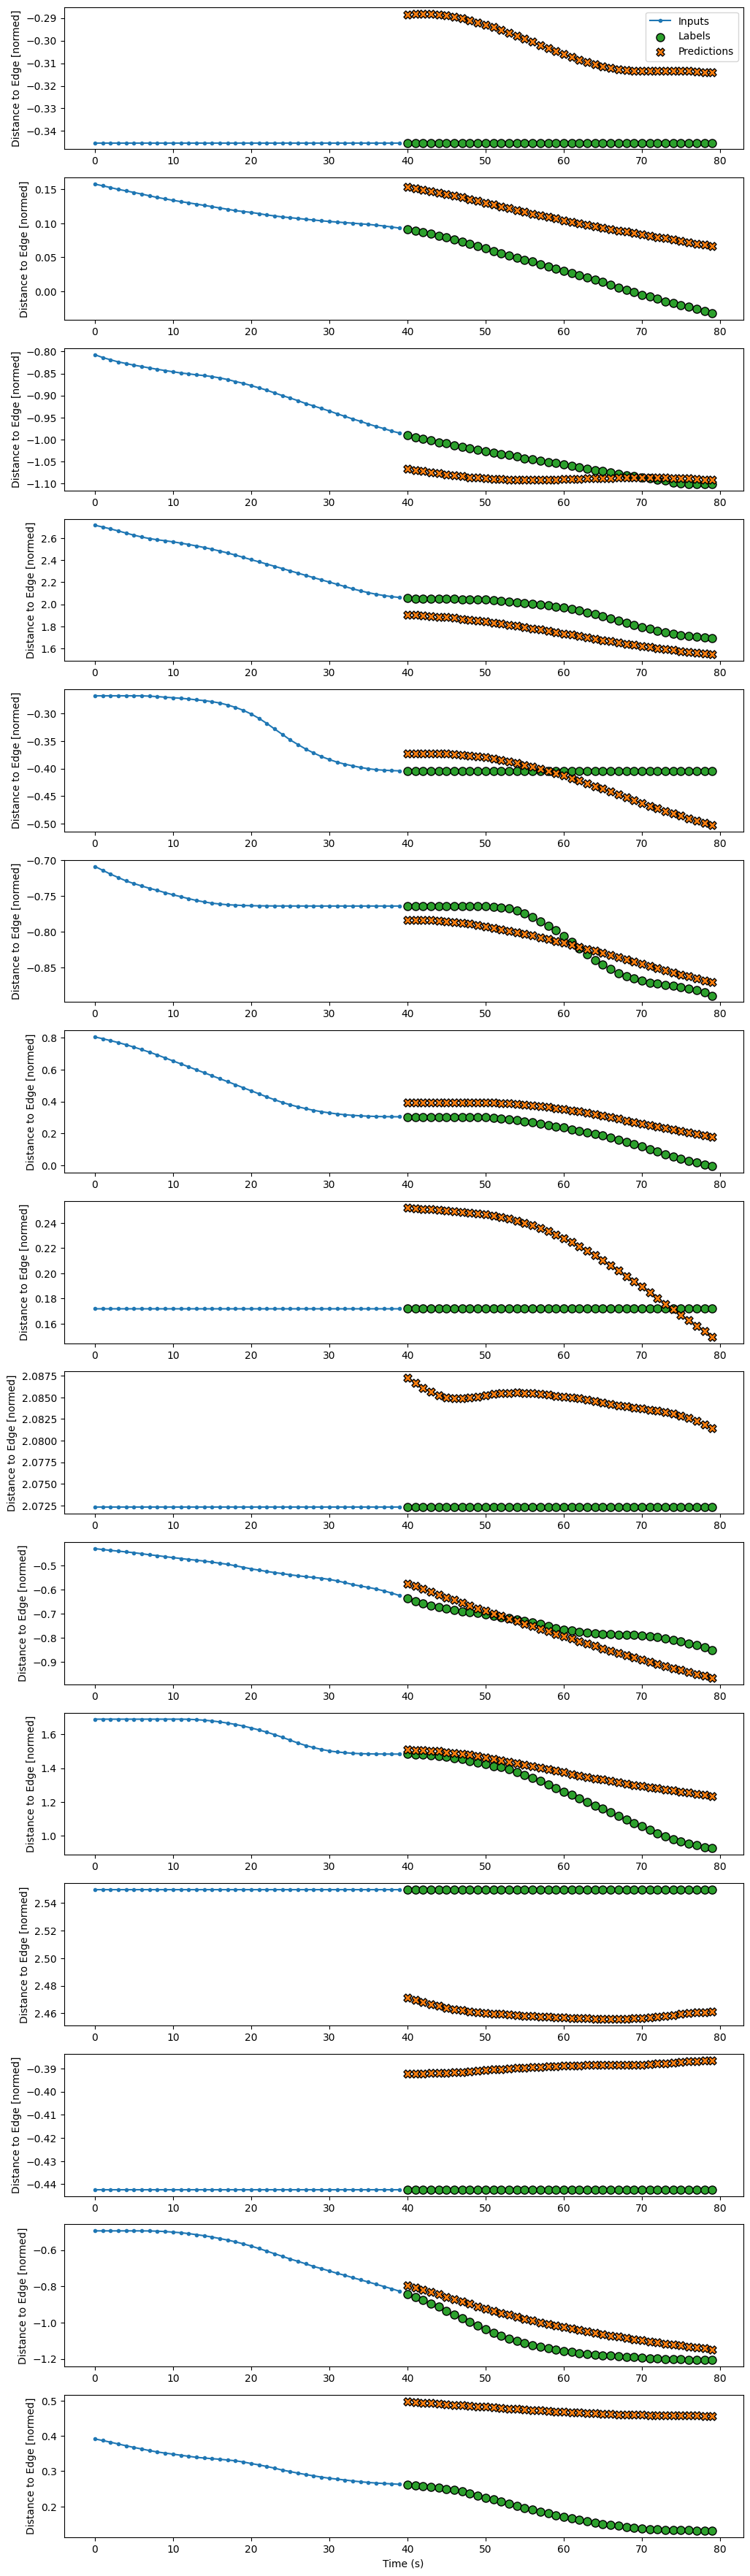

In [ ]:
w0.plot(test_ds, simple_lstm, max_subplots=15)

# Model #2: Simple LSTM, Autoregressive Prediction

## For hiding the model

In [ ]:
# Feedback model
class Feedback(keras.Model):
  def __init__(self, units, label_output_steps, num_pred_features):
    super().__init__()
    self.units = units
    self.label_output_steps = label_output_steps
    self.lstm_cell = layers.LSTMCell(units)
    self.lstm_rnn = layers.RNN(self.lstm_cell, return_state=True)
    self.dense = layers.Dense(num_pred_features) # Outputs 1 time step at a time

  # For making predictions, this will make the first prediction given the input
  # Will return the state for the model to use
  def warmup(self, input):
    prediction, *state = self.lstm_rnn(input)

    # Feed it through the dense model to get output
    prediction = self.dense(prediction)

    return prediction, state

  # Call model on inputs and make predictions
  # This method is for training
  def call(self, input, training=None):
    predictions = []
    # Warm up
    prediction, state = self.warmup(input)
    predictions.append(prediction)


    for _ in range(1, self.label_output_steps):
      tmp = prediction
      tmp, state = self.lstm_cell(tmp, states=state, training=training)

      prediction = self.dense(tmp)
      predictions.append(prediction)

    # (time, batch size, features)
    predictions = tf.stack(predictions)
    # (batch size, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])

    return predictions

  """
  Variable length output call to the model. Stops when destination predicted to be reached

  Params:
    Tensor input : input example
    float threshold : value to determine when to round a predicted value for "Destination Reached" or "Distance to Edge" label
  Ret:
    Tensor predictions : the resulting predictions (time steps, features)
  """
  def var_length_call(self, input, tolerance=-1.35):
    predictions = []

    # Warm up
    input = np.array([input[0]])
    prediction, state = self.warmup(input)

    # Keeps track of labels
    distance = prediction.numpy()[:, 18]
    predictions.append(distance)
    while distance > tolerance:
      tmp = prediction
      tmp, state = self.lstm_cell(tmp, states=state)

      prediction = self.dense(tmp)
      distance = prediction.numpy()[:, 18]

      predictions.append(distance)

    return predictions

In [ ]:
test_lstm_feedback.evaluate(test_ds_full)

In [ ]:
pred = []
for input, label in test_ds_full.take(1):
  pred = test_lstm_feedback.var_length_call(input)

print(len(pred))

111


In [ ]:
pred = np.array(pred)

In [ ]:
print(pred.shape)

(111, 1)


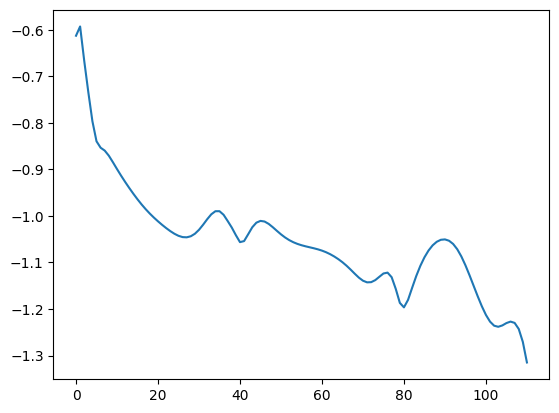

In [ ]:
plt.plot(pred)

## End hiding model

In [ ]:
w1 = WindowGenerator(80, 80, 80, 20, train_ts, validate_ts, test_ts, labels, output_labels, output_labels)

In [ ]:
train_ds_full = w1.train
val_ds_full = w1.val
test_ds_full = w1.test

In [ ]:
print(train_ds_full)

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 80, 16), dtype=tf.float64, name=None), TensorSpec(shape=(None, 80, 16), dtype=tf.float64, name=None))>


In [ ]:
# Making the model
simple_lstm_feedback = Feedback(64, OUTPUT_STEPS, num_features)

In [ ]:
history_1 = compile_and_fit(simple_lstm_feedback, train_ds_full, val_ds_full)

Epoch 1/20
825/825 [==============================] - 199s 174ms/step - loss: 0.6643 - mean_absolute_error: 0.5079 - val_loss: 0.6810 - val_mean_absolute_error: 0.4453
Epoch 2/20
825/825 [==============================] - 136s 165ms/step - loss: 0.6309 - mean_absolute_error: 0.4848 - val_loss: 0.6345 - val_mean_absolute_error: 0.4376
Epoch 3/20
825/825 [==============================] - 136s 164ms/step - loss: 0.6133 - mean_absolute_error: 0.4719 - val_loss: 0.6470 - val_mean_absolute_error: 0.4367
Epoch 4/20
825/825 [==============================] - 154s 187ms/step - loss: 0.6054 - mean_absolute_error: 0.4642 - val_loss: 0.6076 - val_mean_absolute_error: 0.4090
Epoch 5/20
825/825 [==============================] - 137s 166ms/step - loss: 0.5988 - mean_absolute_error: 0.4580 - val_loss: 0.5947 - val_mean_absolute_error: 0.4162
Epoch 6/20
825/825 [==============================] - 111s 134ms/step - loss: 0.5817 - mean_absolute_error: 0.4447 - val_loss: 0.5858 - val_mean_absolute_error:

In [ ]:
simple_lstm_feedback.save_weights("/content/drive/MyDrive/Colab Notebooks/model/biggerLSTM_80sWind_NoDestorReachedorTLData_AutoReg")

In [ ]:
simple_lstm_feedback.evaluate(test_ds_full)

56/56 [==============================] - 2s 30ms/step - loss: 0.3963 - mean_absolute_error: 0.3520


[0.39633920788764954, 0.35199251770973206]

In [ ]:
w1.plot(train_ds_full, simple_lstm_feedback, plot_col="Distance to Edge", max_subplots=10)

# Model #3: Bigger LSTM Layers, Single-Shot Prediction
Currently the best (0.45 loss)

More LSTM units, same amount of dense layers

In [ ]:
print(all_data[0, :, 3])

[-0.90115608 -0.90115608 -0.90115608 ...  1.16018057  1.11475079
  1.06629124]


In [ ]:
(-1 - num_mean[3])/num_std[3]

-0.9011560779756117

In [ ]:
num_mean[-1]

563.2819276780536

In [ ]:
num_std[-1]

397.64766012604633

In [ ]:
bigger_LSTM = keras.Sequential([
    layers.LSTM(64, return_sequences=False),

    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer = tf.initializers.zeros()),

    layers.Reshape((OUTPUT_STEPS, num_features))
])

In [ ]:
history = compile_and_fit(bigger_LSTM, train_ds, val_ds, patience=20)

Epoch 1/20
825/825 [==============================] - 53s 61ms/step - loss: 0.5821 - mean_absolute_error: 0.4483 - val_loss: 0.5373 - val_mean_absolute_error: 0.3741
Epoch 2/20
825/825 [==============================] - 51s 62ms/step - loss: 0.5315 - mean_absolute_error: 0.4109 - val_loss: 0.5232 - val_mean_absolute_error: 0.3640
Epoch 3/20
825/825 [==============================] - 49s 59ms/step - loss: 0.5156 - mean_absolute_error: 0.4001 - val_loss: 0.5097 - val_mean_absolute_error: 0.3618
Epoch 4/20
825/825 [==============================] - 51s 62ms/step - loss: 0.5051 - mean_absolute_error: 0.3932 - val_loss: 0.5001 - val_mean_absolute_error: 0.3520
Epoch 5/20
825/825 [==============================] - 51s 61ms/step - loss: 0.4978 - mean_absolute_error: 0.3891 - val_loss: 0.4976 - val_mean_absolute_error: 0.3513
Epoch 6/20
825/825 [==============================] - 52s 63ms/step - loss: 0.4925 - mean_absolute_error: 0.3861 - val_loss: 0.4928 - val_mean_absolute_error: 0.3546
Epoc

In [ ]:
# bigger_LSTM.save('/content/drive/MyDrive/Colab Notebooks/model/biggerLSTM_80sWind_NoCatVarsOrTLData.keras')

In [ ]:
bigger_LSTM = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/model/biggerLSTM_80sWind_NoCatVarsOrTLData.keras")

In [ ]:
bigger_LSTM.evaluate(test_ds)

56/56 [==============================] - 3s 24ms/step - loss: 0.4325 - mean_absolute_error: 0.3511


[0.43251511454582214, 0.3510524332523346]

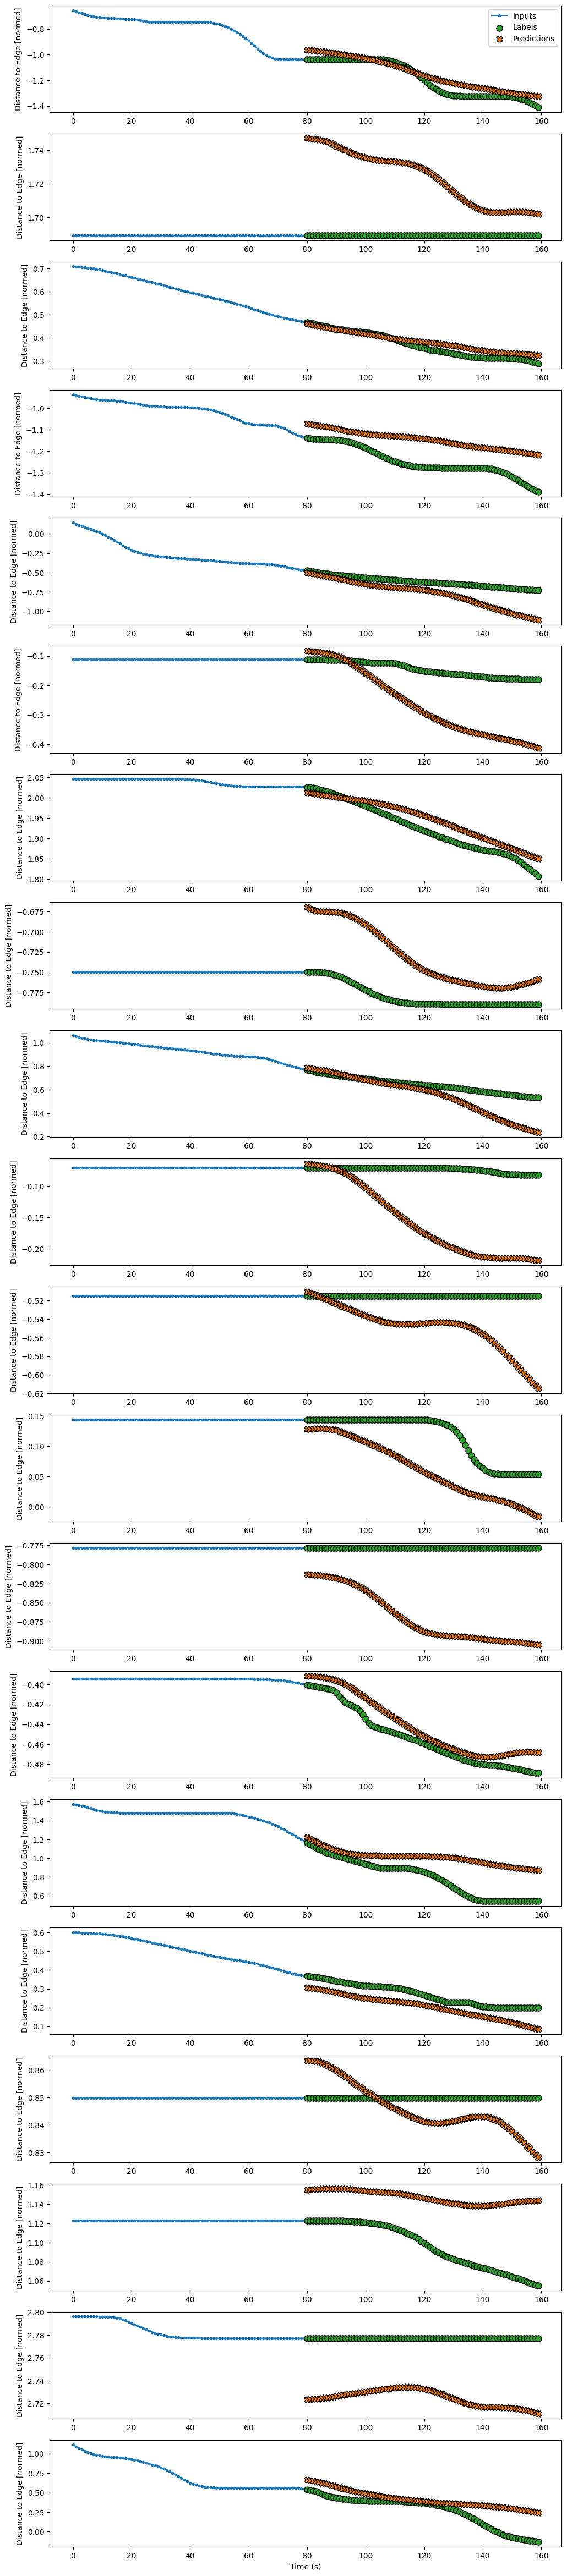

In [ ]:
w0.plot(test_ds, bigger_LSTM, plot_col="Distance to Edge", max_subplots=20)

# Model #3.5: Even Bigger LSTM, Single-Shot Prediction

In [ ]:
even_bigger_LSTM = keras.Sequential([
    layers.LSTM(128, return_sequences=False),

    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(even_bigger_LSTM, train_ds, val_ds)

Epoch 1/40
825/825 [==============================] - 151s 178ms/step - loss: 0.2633 - mean_absolute_error: 0.2538 - val_loss: 0.2405 - val_mean_absolute_error: 0.2244
Epoch 2/40
825/825 [==============================] - 143s 173ms/step - loss: 0.2270 - mean_absolute_error: 0.2180 - val_loss: 0.2383 - val_mean_absolute_error: 0.2142
Epoch 3/40
825/825 [==============================] - 154s 187ms/step - loss: 0.2163 - mean_absolute_error: 0.2069 - val_loss: 0.2302 - val_mean_absolute_error: 0.2071
Epoch 4/40
825/825 [==============================] - 158s 192ms/step - loss: 0.2083 - mean_absolute_error: 0.1992 - val_loss: 0.2215 - val_mean_absolute_error: 0.2010
Epoch 5/40
825/825 [==============================] - 148s 179ms/step - loss: 0.2031 - mean_absolute_error: 0.1944 - val_loss: 0.2192 - val_mean_absolute_error: 0.1977
Epoch 6/40
825/825 [==============================] - 188s 228ms/step - loss: 0.1993 - mean_absolute_error: 0.1911 - val_loss: 0.2184 - val_mean_absolute_error:

In [ ]:
even_bigger_LSTM.evaluate(test_ds)

56/56 [==============================] - 5s 81ms/step - loss: 0.1934 - mean_absolute_error: 0.1956


[0.19335927069187164, 0.19563882052898407]

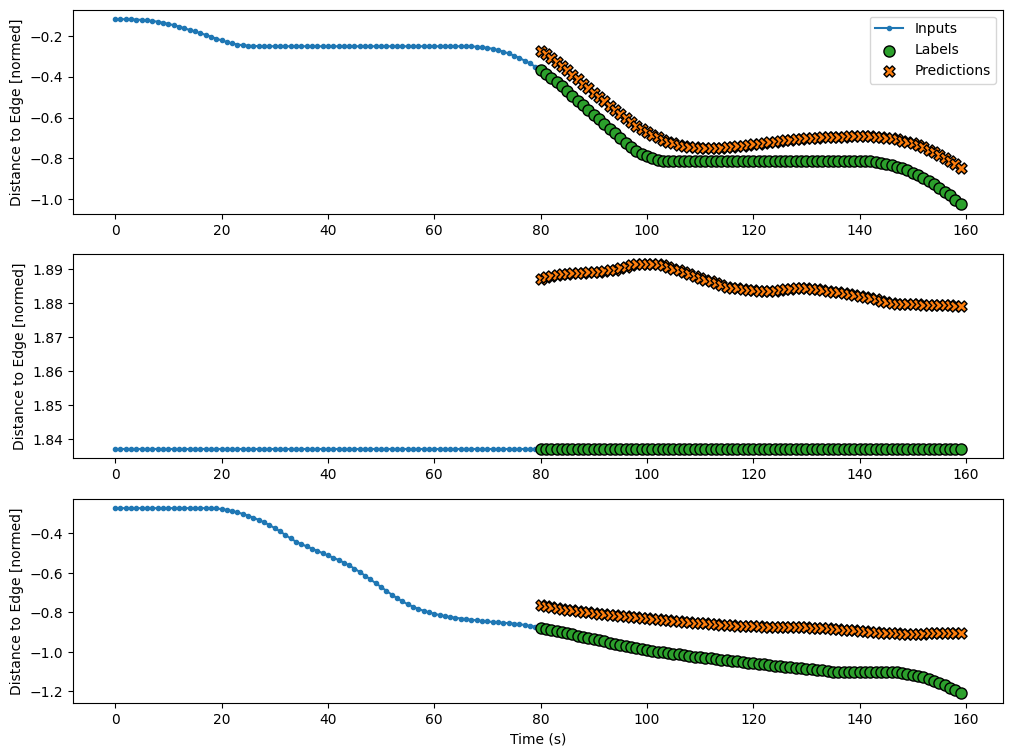

In [ ]:
w0.plot(test_ds, even_bigger_LSTM, plot_col="Distance to Edge")

In [ ]:
even_bigger_LSTM.save("/content/drive/MyDrive/Colab Notebooks/model/evenBiggerLSTM.keras")

# Model #4: Denser LSTM, Single-shot Prediction

Too lineaer of predictions

In [ ]:
denser_LSTM = keras.Sequential([
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32, return_sequences=False),

    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer = tf.initializers.zeros()),

    layers.Reshape((OUTPUT_STEPS, num_features))
])

In [ ]:
history = compile_and_fit(denser_LSTM, train_ds, val_ds)

Epoch 1/20
553/553 [==============================] - 77s 116ms/step - loss: 0.0938 - mean_absolute_error: 0.2070 - val_loss: 0.0474 - val_mean_absolute_error: 0.1722
Epoch 2/20
553/553 [==============================] - 61s 111ms/step - loss: 0.0161 - mean_absolute_error: 0.0937 - val_loss: 0.0151 - val_mean_absolute_error: 0.0910
Epoch 3/20
553/553 [==============================] - 60s 108ms/step - loss: 0.0121 - mean_absolute_error: 0.0822 - val_loss: 0.0117 - val_mean_absolute_error: 0.0742
Epoch 4/20
553/553 [==============================] - 58s 105ms/step - loss: 0.0166 - mean_absolute_error: 0.0903 - val_loss: 0.0278 - val_mean_absolute_error: 0.1254
Epoch 5/20
553/553 [==============================] - 60s 108ms/step - loss: 0.0103 - mean_absolute_error: 0.0744 - val_loss: 0.0105 - val_mean_absolute_error: 0.0715
Epoch 6/20
553/553 [==============================] - 58s 105ms/step - loss: 0.0107 - mean_absolute_error: 0.0736 - val_loss: 0.0237 - val_mean_absolute_error: 0.122

In [ ]:
denser_LSTM.evaluate(test_ds)

70/70 [==============================] - 4s 57ms/step - loss: 0.0480 - mean_absolute_error: 0.1406


[0.04803795740008354, 0.14057014882564545]

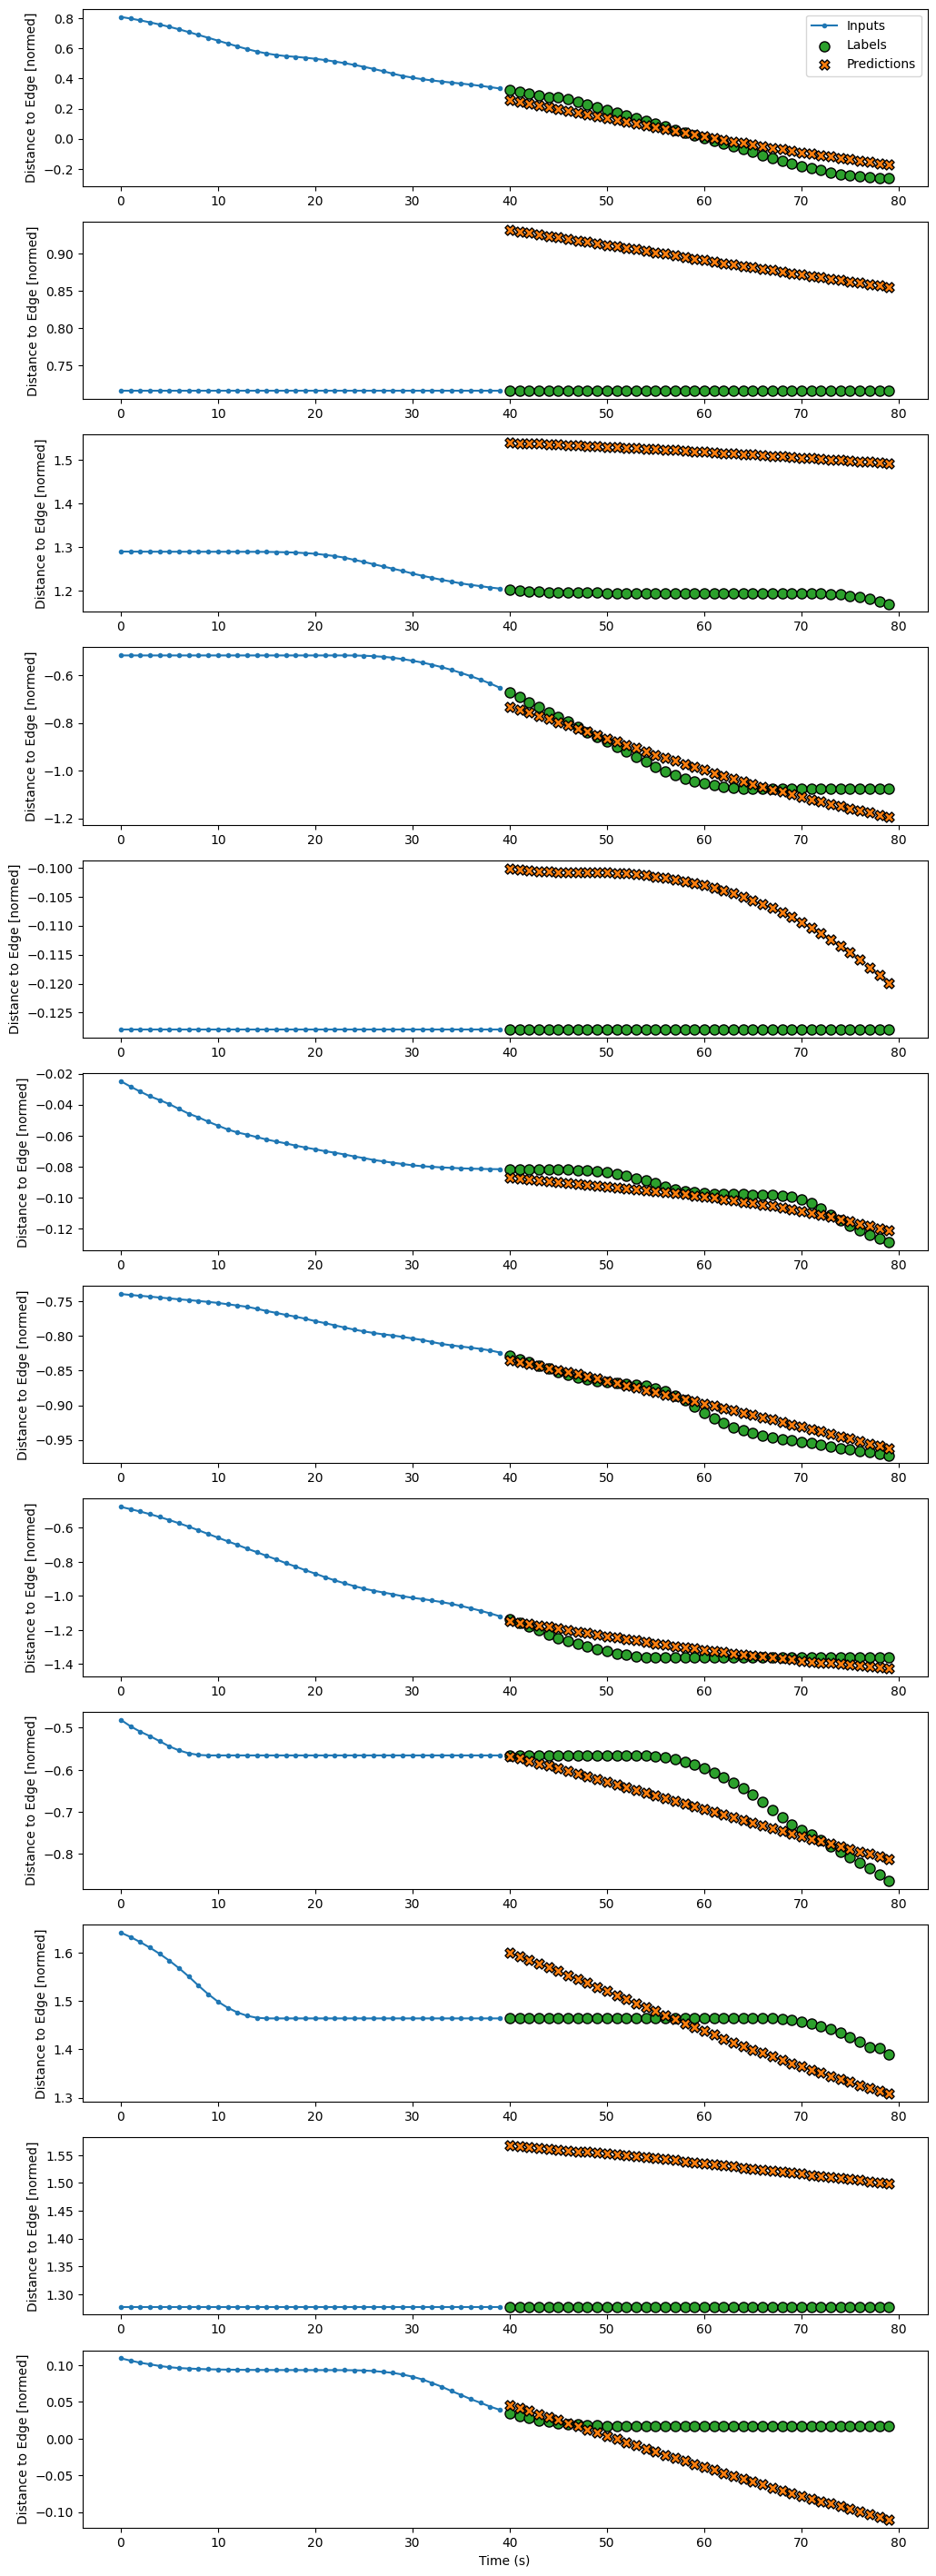

In [ ]:
w0.plot(val_ds, denser_LSTM, plot_col="Distance to Edge", max_subplots=12)

# Model #5: Bigger LSTM Layers, Autoregressive Prediction

In [ ]:
bigger_lstm_feedback = Feedback(128, OUTPUT_STEPS, 44)

In [ ]:
history = compile_and_fit(bigger_lstm_feedback, train_ds_full, val_ds_full)

Epoch 1/20
688/688 [==============================] - 122s 161ms/step - loss: 0.3385 - mean_absolute_error: 0.3097 - val_loss: 0.3232 - val_mean_absolute_error: 0.2864
Epoch 2/20
688/688 [==============================] - 108s 157ms/step - loss: 0.3021 - mean_absolute_error: 0.2819 - val_loss: 0.3004 - val_mean_absolute_error: 0.2725
Epoch 3/20
688/688 [==============================] - 107s 156ms/step - loss: 0.2809 - mean_absolute_error: 0.2652 - val_loss: 0.2884 - val_mean_absolute_error: 0.2617
Epoch 4/20
688/688 [==============================] - 107s 155ms/step - loss: 0.2687 - mean_absolute_error: 0.2563 - val_loss: 0.2829 - val_mean_absolute_error: 0.2593
Epoch 5/20
688/688 [==============================] - 107s 155ms/step - loss: 0.2595 - mean_absolute_error: 0.2498 - val_loss: 0.2684 - val_mean_absolute_error: 0.2519
Epoch 6/20
688/688 [==============================] - 107s 155ms/step - loss: 0.2510 - mean_absolute_error: 0.2440 - val_loss: 0.2632 - val_mean_absolute_error:

In [ ]:
bigger_lstm_feedback.evaluate(test_ds_full)

86/86 [==============================] - 9s 94ms/step - loss: 0.2635 - mean_absolute_error: 0.2330


[0.2634871006011963, 0.23295807838439941]

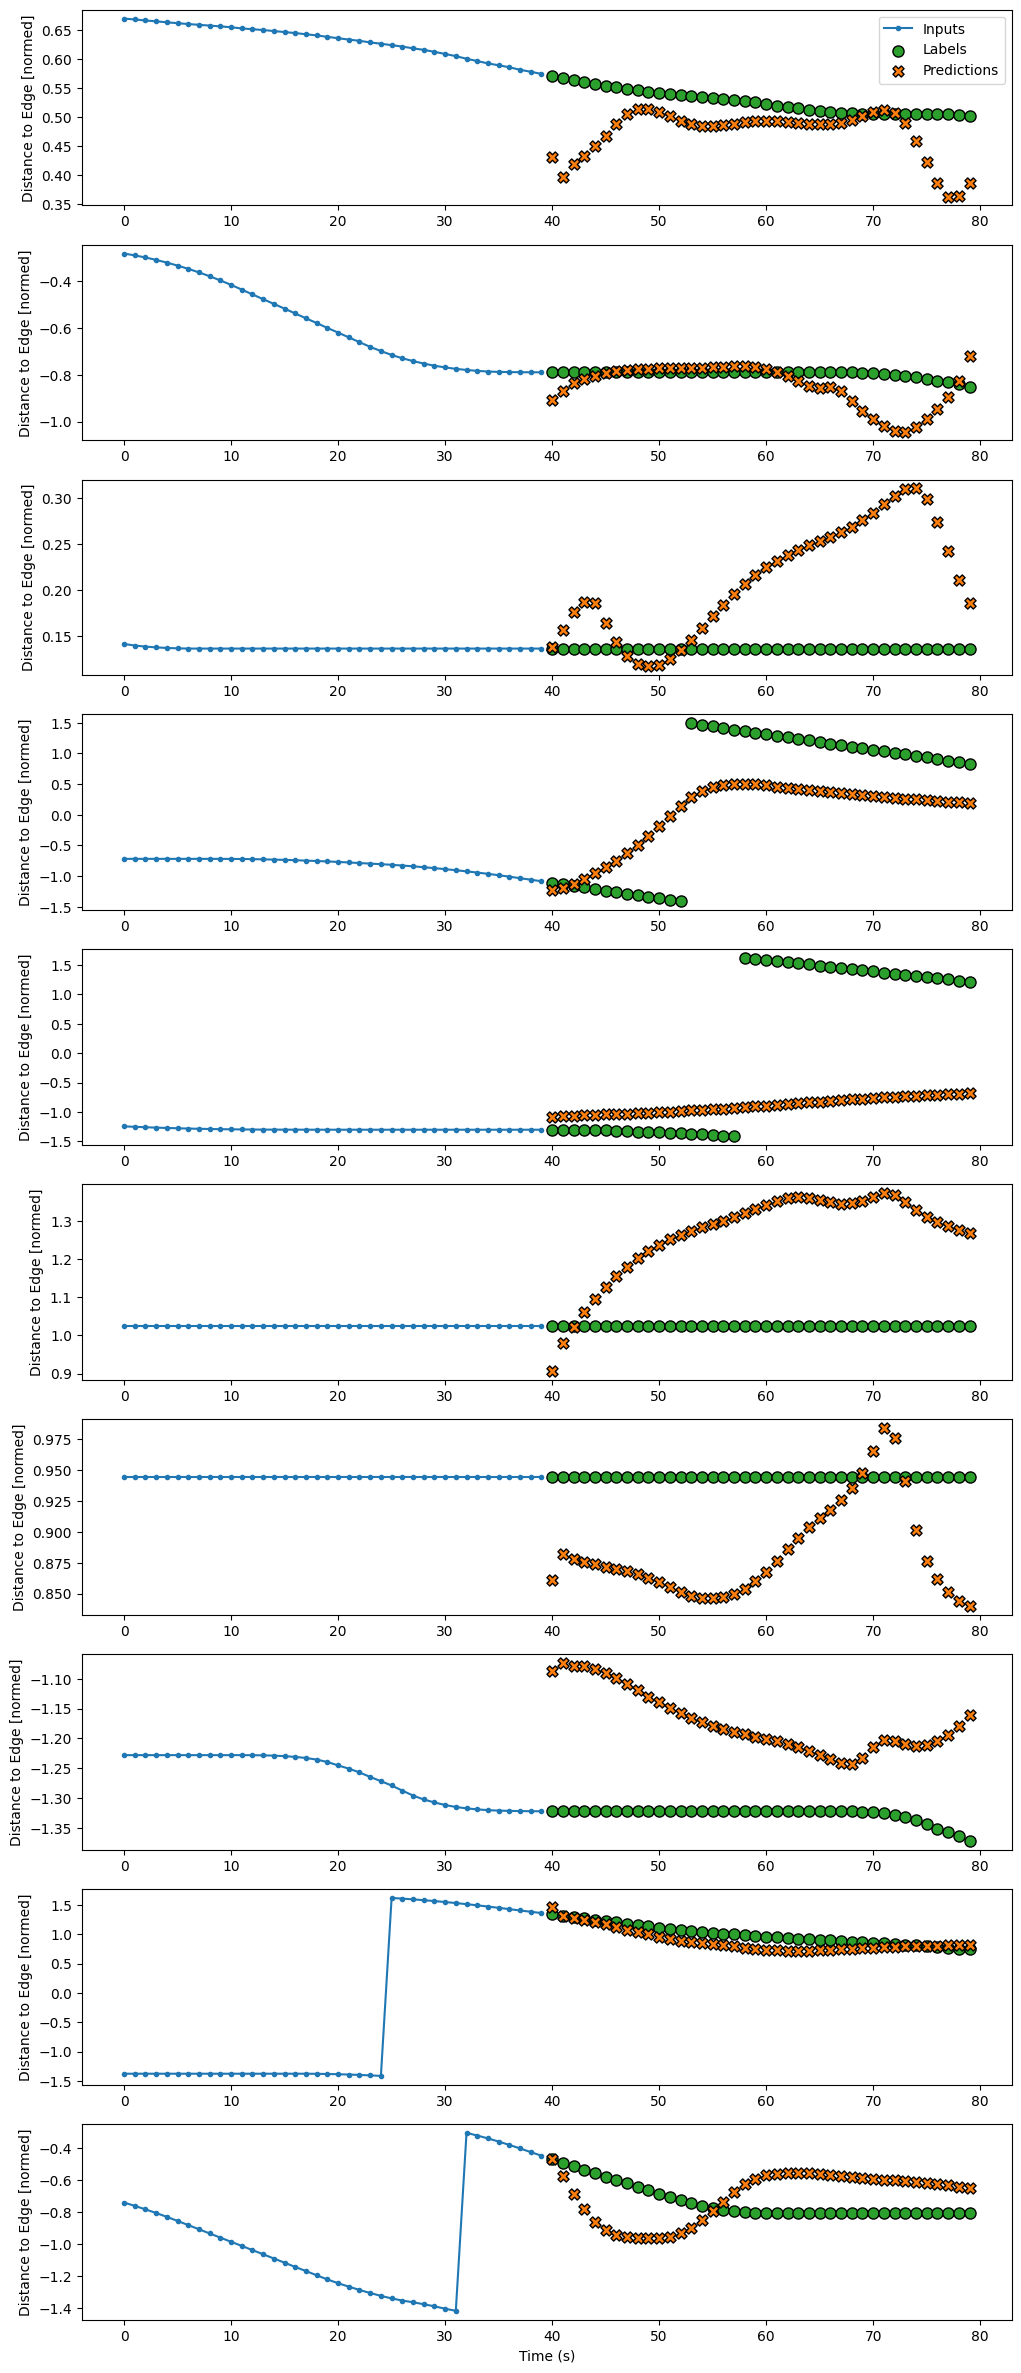

In [ ]:
w1.plot(test_ds_full, bigger_lstm_feedback, max_subplots=10)

# Model #6 Big LSTM layer, More Dense, More LSTM, Single-Shot Prediction

Doesn't work well: Dense layer seems to be messing it up

In [ ]:
complex_LSTM = keras.Sequential([
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(64),
    layers.Dense(OUTPUT_STEPS),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(complex_LSTM, train_ds, val_ds)

Epoch 1/20
553/553 [==============================] - 54s 81ms/step - loss: 0.0732 - mean_absolute_error: 0.1729 - val_loss: 0.0164 - val_mean_absolute_error: 0.0992
Epoch 2/20
553/553 [==============================] - 42s 76ms/step - loss: 0.0134 - mean_absolute_error: 0.0873 - val_loss: 0.0102 - val_mean_absolute_error: 0.0758
Epoch 3/20
553/553 [==============================] - 42s 75ms/step - loss: 0.0125 - mean_absolute_error: 0.0797 - val_loss: 0.0082 - val_mean_absolute_error: 0.0630
Epoch 4/20
553/553 [==============================] - 42s 76ms/step - loss: 0.0075 - mean_absolute_error: 0.0638 - val_loss: 0.0071 - val_mean_absolute_error: 0.0577
Epoch 5/20
553/553 [==============================] - 42s 76ms/step - loss: 0.0219 - mean_absolute_error: 0.0896 - val_loss: 0.0136 - val_mean_absolute_error: 0.0838
Epoch 6/20
553/553 [==============================] - 42s 75ms/step - loss: 0.0058 - mean_absolute_error: 0.0543 - val_loss: 0.0066 - val_mean_absolute_error: 0.0542
Epoc

In [ ]:
complex_LSTM.evaluate(test_ds)

70/70 [==============================] - 1s 18ms/step - loss: 0.0079 - mean_absolute_error: 0.0611


[0.007853025570511818, 0.06112741678953171]

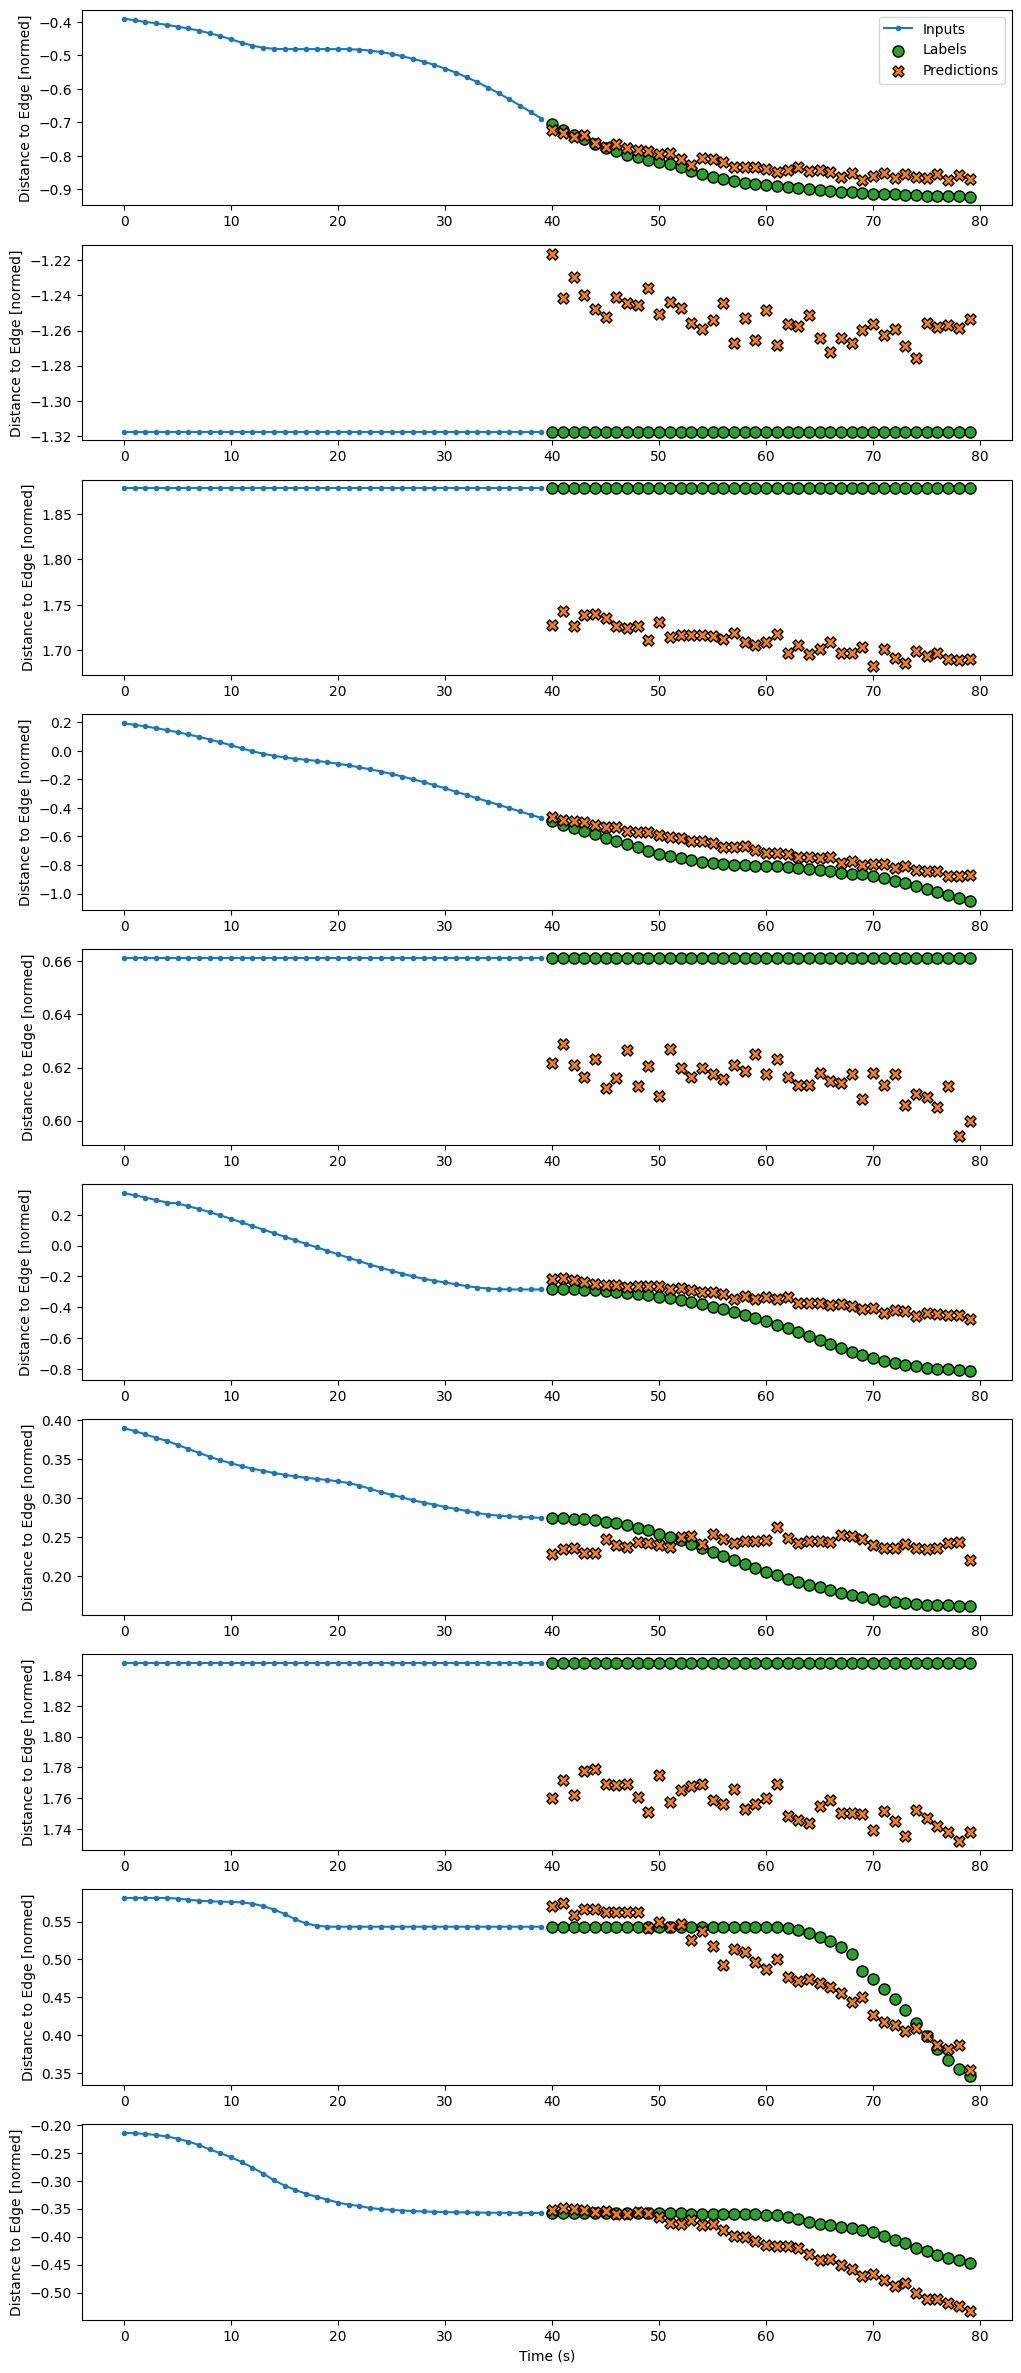

In [ ]:
w0.plot(test_ds, complex_LSTM, max_subplots=10)

# Model #7 Residual Network
Change from last input rather than generating a new output

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

CPU times: user 22 ms, sys: 1.03 ms, total: 23 ms
Wall time: 25 ms


In [ ]:
history = compile_and_fit(residual_lstm, train_ds, val_ds)

Epoch 1/20
553/553 [==============================] - 34s 50ms/step - loss: 0.5584 - mean_absolute_error: 0.4984 - val_loss: 0.4834 - val_mean_absolute_error: 0.4352
Epoch 2/20
553/553 [==============================] - 28s 50ms/step - loss: 0.4717 - mean_absolute_error: 0.4407 - val_loss: 0.4683 - val_mean_absolute_error: 0.4313
Epoch 3/20
553/553 [==============================] - 29s 52ms/step - loss: 0.4611 - mean_absolute_error: 0.4316 - val_loss: 0.4630 - val_mean_absolute_error: 0.4194
Epoch 4/20
553/553 [==============================] - 28s 51ms/step - loss: 0.4591 - mean_absolute_error: 0.4295 - val_loss: 0.4621 - val_mean_absolute_error: 0.4190
Epoch 5/20
553/553 [==============================] - 29s 52ms/step - loss: 0.4574 - mean_absolute_error: 0.4276 - val_loss: 0.4626 - val_mean_absolute_error: 0.4181
Epoch 6/20
553/553 [==============================] - 29s 52ms/step - loss: 0.4577 - mean_absolute_error: 0.4278 - val_loss: 0.4617 - val_mean_absolute_error: 0.4344
Epoc

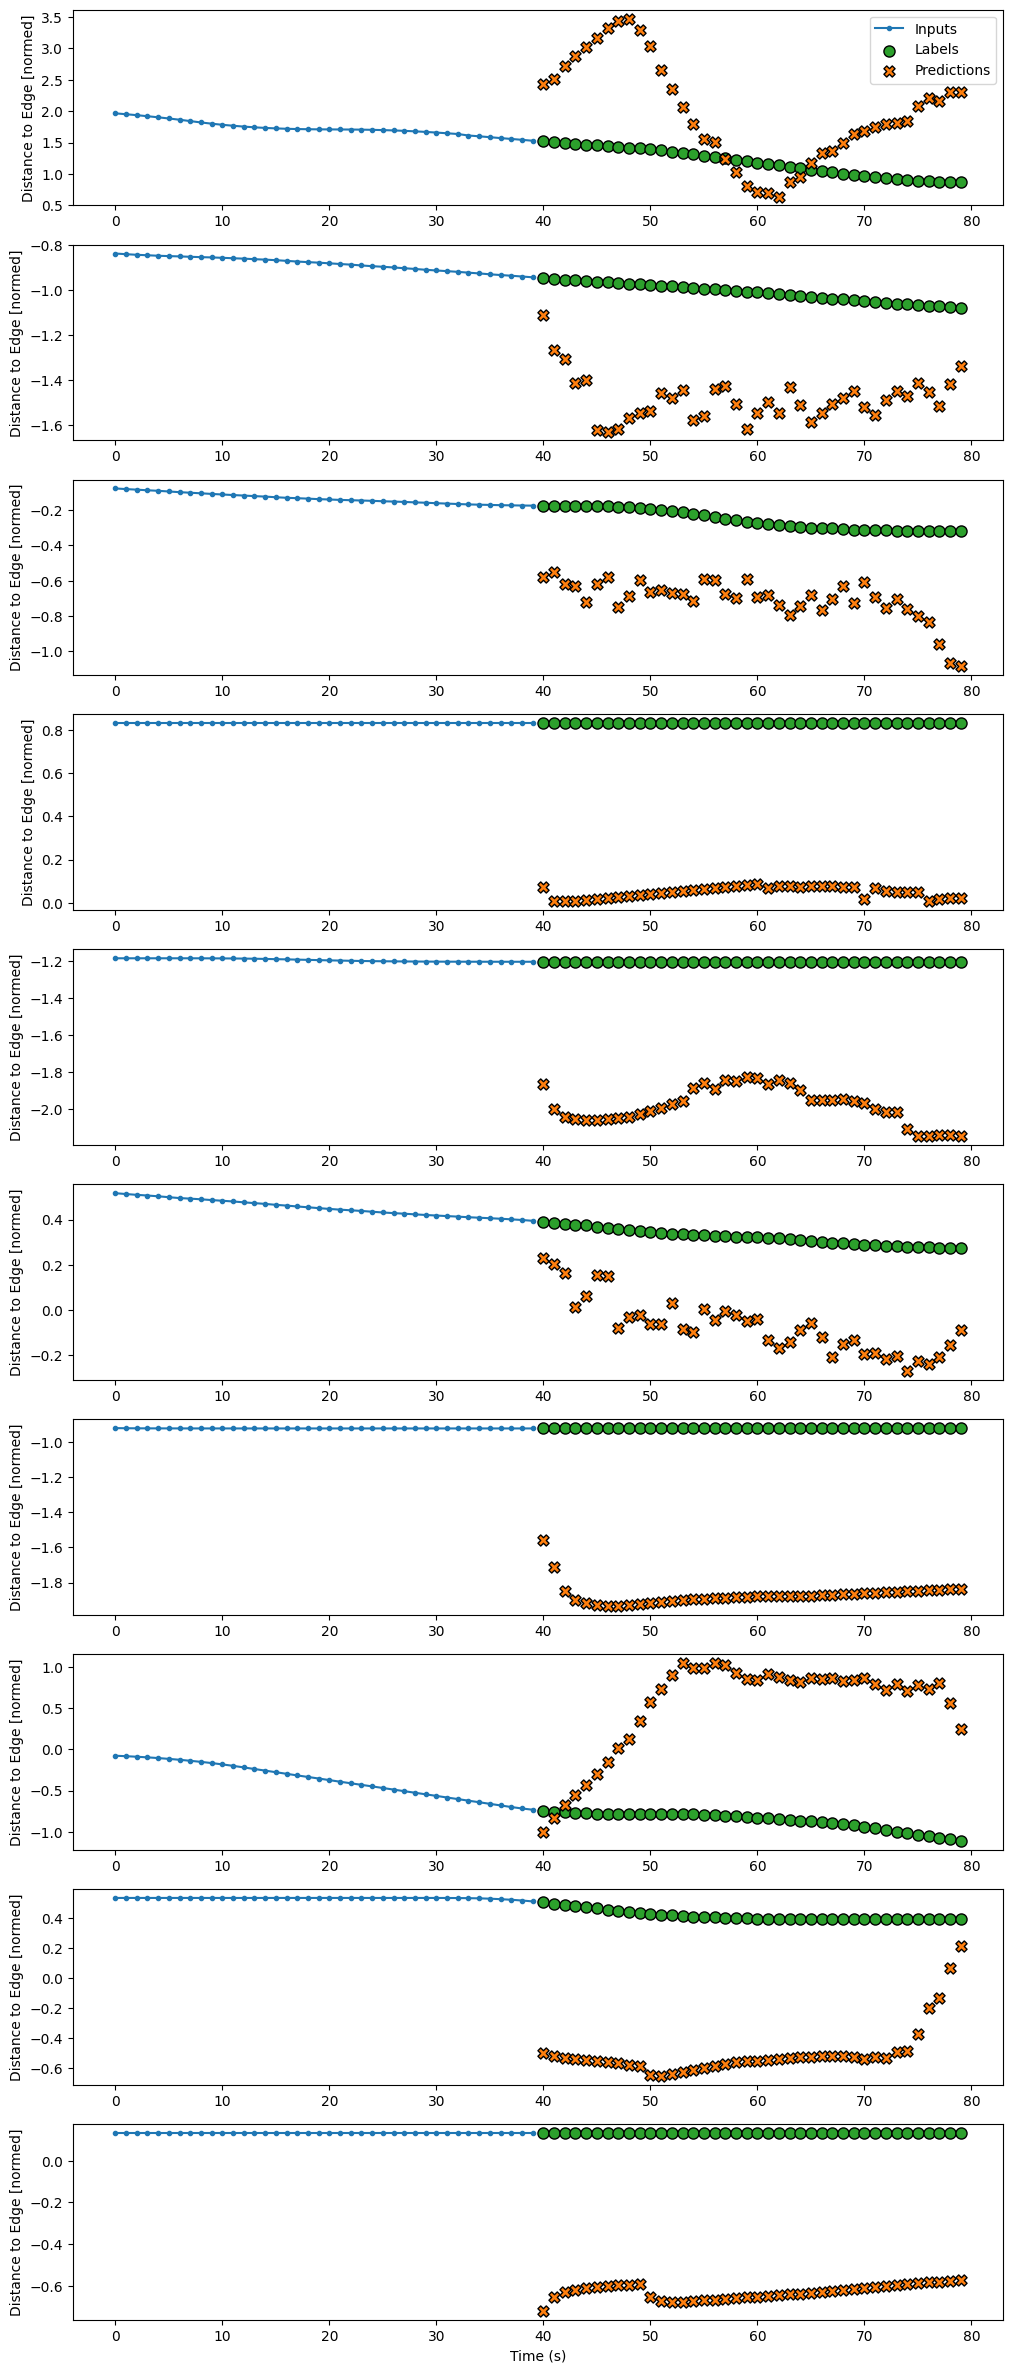

In [ ]:
w0.plot(test_ds, residual_lstm, max_subplots=10)

# Model #8: Big LSTM with Dropout
2 layers, both 64 cells, dropout layer in between
Adding dropout layer

In [ ]:
bigDenseDropLSTM = keras.Sequential([
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(64),

    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(bigDenseDropLSTM, train_ds, val_ds, patience=5)

Epoch 1/20
1578/1578 [==============================] - 83s 49ms/step - loss: 0.2669 - mean_absolute_error: 0.2566 - val_loss: 0.2521 - val_mean_absolute_error: 0.2362
Epoch 2/20
1578/1578 [==============================] - 88s 55ms/step - loss: 0.2224 - mean_absolute_error: 0.2241 - val_loss: 0.2283 - val_mean_absolute_error: 0.2157
Epoch 3/20
1578/1578 [==============================] - 78s 49ms/step - loss: 0.2084 - mean_absolute_error: 0.2077 - val_loss: 0.2212 - val_mean_absolute_error: 0.2048
Epoch 4/20
1578/1578 [==============================] - 83s 52ms/step - loss: 0.2006 - mean_absolute_error: 0.1985 - val_loss: 0.2166 - val_mean_absolute_error: 0.2005
Epoch 5/20
1578/1578 [==============================] - 77s 49ms/step - loss: 0.1953 - mean_absolute_error: 0.1921 - val_loss: 0.2117 - val_mean_absolute_error: 0.1952
Epoch 6/20
1578/1578 [==============================] - 79s 50ms/step - loss: 0.1915 - mean_absolute_error: 0.1876 - val_loss: 0.2068 - val_mean_absolute_error:

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


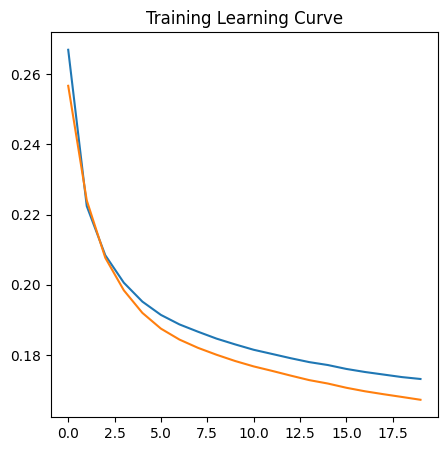

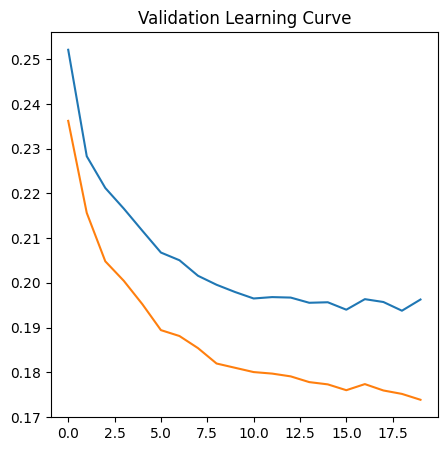

In [ ]:
# Plotting stats
plt.figure(figsize=(5, 5))
plt.title("Training Learning Curve")
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.show()

plt.figure(figsize=(5, 5))
plt.title("Validation Learning Curve")
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_mean_absolute_error'])
plt.show()

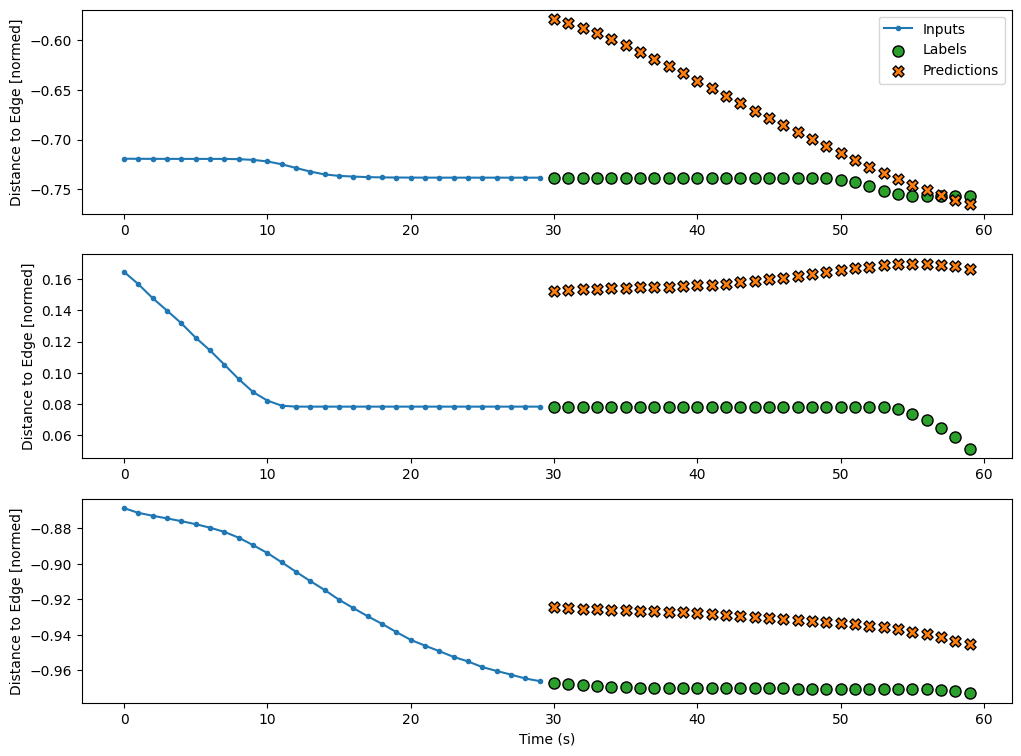

In [ ]:
w0.plot(test_ds, bigDenseDropLSTM)

In [ ]:
bigDenseDropLSTM.save("/content/drive/MyDrive/Colab Notebooks/model/bigDenseDropLSTM30Wind.keras")

# Findings

64 cell - Loss, Err, Eta (10) - 217s

64 cell LSTM, no Dest Reached - Loss = 0.209, Mean Abs Err = 0.211, Eta (50) - 369s

64 cell, no Dest Reached or edge - Loss = 0.359, Mean Abs Err = 0.336, Eta(10) - 493 s

64 cell no cat vars - Loss = 0.445, Mean Abs Err = 0.390, ETA(10) - 676 s

Optimized Even Window - Test Loss = 0.5, ETA(50) - 120 s

Baseline: LSTM with minimal features

# Evaluating Model's Time Prediction Ability

In [ ]:
# Creating dictionary to access numerical mean and STD
temp_var = zip(num_mean, num_std)
num_mean_std = dict(zip(numeric_vars, temp_var))
for s, v in num_mean_std.items():
  print(s, v)

Speed (4.290633907457762, 5.725632056301572)
Max Speed (17.652330020392256, 2.1732710104162685)
Acceleration (-0.002506161504373841, 1.2847512830822474)
Traffic Light Distance (125.77183518549955, 140.6768908115054)
Traffic Light Time to Switch (5.373623490212411, 5.010628226748153)
Number of Vehicles to Traffic Light (11.918963310741736, 16.70989617131847)
Number of Leading Vehicles (1.4774374313732914, 0.640549941836425)
Leading Vehicles Average Gap (15.898617622058202, 36.073191995941535)
Leading Vehicles Average Speed (3.5397465162255317, 5.262681390740491)
Leading Vehicles Average Acceleration (-0.07898357886992388, 1.1802174619775851)
Number of Right Lane Vehicles (1.0878845935405703, 1.9121991519234083)
Right Lane Average Gap (-0.2047572260314939, 2.264287563589679)
Right Lane Average Speed (0.7792631151193108, 4.223183867426405)
Right Lane Average Acceleration (-0.6778684086651459, 0.8013067591184447)
Number of Left Lane Vehicles (2.6072681837113323, 6.913413687279203)
Left Lan

In [ ]:
"""
Returns a chunk of a vehicle's time series that encapsulates when a vehicle sets off on a destination to when it reaches it, otherwise known as a trip

Params:
  List[list] ts : the time series of the vehicle to return a subset of
Ret:
  List[list] trip : a subset of the provided time series that represents a single trip of the vehicle
"""
def findTrip(ts):
  starts = []
  seenYes = False
  for i in range(len(ts)):
    el = ts[i]
    if el[-1] == 1 and seenYes == False:
      starts.append(i)
      seenYes = True
    elif el[-1] == 0 and seenYes == True:
      seenYes = False

  start = np.floor(np.random.rand(1) * (len(starts) - 2)).astype(int)[0]
  limit = len(starts) - 1
  while limit > 0 and starts[start + 1] - starts[start] < 160:
    start = np.floor(np.random.rand(1) * (len(starts) - 2)).astype(int)[0]
    limit -= 1

  if limit == 0:
    return -1

  try:
    return ts[starts[start]:starts[start + 1]]
  except IndexError:
    return -1


In [ ]:
"""
Removes features from a time series with all features

Params:
  np.ndarray ts : the time series to remove features from
  Dict{} column_indices : dictionary with the column names as keys and the values as the column index
  List[str] columns : a list of the column names we want to keep
Ret:
  np.ndarray filtered_ts : the time series without the features
"""
def removeFeatures(ts, column_indices, columns):
  filtered_ts = np.concatenate(
      [ts[:, column_indices[column]] for column in columns],
      axis = -1
  )

  return filtered_ts

In [ ]:
"""
Translates the one-hot encoding of a traffic light state to its string representation

Params:
  np.ndarray onehot : the one-hot encoding of the string we want to translate
Ret:
  str s: the string that represents the phase to translate
"""
def onehot_to_str(onehot):
  vocab = ['g', 'n', 'r', 'y']
  encode = layers.StringLookup(vocabulary=vocab, output_mode="one_hot")
  encodings = encode(vocab).numpy()
  translate = {vocab[i]: encodings[i] for i in range(len(vocab))} # Translates from the string vocabulary of phases to the one-hot encoding

  onehot = list(onehot)
  for s in vocab:
    curr = list(translate[s])
    if curr == onehot:
      return s

"""
Translates the string representation of a traffic light state to its one-hot encoding

Params:
  str s: the string that represents the phase to translate
Ret:
  np.ndarray onehot : the one-hot encoding of the string we want to translate
"""
def str_to_onehot(str_phase):
  vocab = ['g', 'n', 'r', 'y']
  encode = layers.StringLookup(vocabulary=vocab, output_mode="one_hot")
  encodings = encode(vocab).numpy()
  translate = {vocab[i]: encodings[i] for i in range(len(vocab))} # Translates from the string vocabulary of phases to the one-hot encoding

  return translate[str_phase]

In [ ]:
"""
Finds the TL phases given the entire time series of a vehicle

Params:
  List[List] ts : the entire time series of a vehicle
Ret:
  Dict{List:int} phase : keys hold the one-hot encoded state and the values hold the time the state lasts for
"""
def findTLPhases(ts):
  time_in_red = 0
  time_in_curr_tl = 0 # The amount of time spent observing current TL
  prev, curr = 0, 1
  while curr < len(ts):
    # Check if staying at the same traffic light
    prev_dist_to_tl, curr_dist_to_tl = ts[prev][3], ts[curr][3]

    # Edge Case: there is no traffic light
    # Also makes sure that there is no traffic light switch
    if (prev_dist_to_tl != -1 and curr_dist_to_tl != -1) and prev_dist_to_tl - curr_dist_to_tl >= 0:
      time_in_curr_tl += 1 # Have been observing this traffic light for 1 time step
      # Finding string corresponding to state
      state = onehot_to_str(ts[curr][19:24])

      if state == 'r':
        time_in_red += 1
        if time_in_red > 6:
          return {{'g': 15, 'y': 3, 'r': 20, 'n': -1}}
      else: # If the state is green, then most likely it is the shorter phase
        if time_in_red <= 6 and time_in_curr_tl > 6: # If we have been observing this TL for long enough
          return {'g': 10, 'y': 3, 'r': 3, 'n': -1}
        else:
          time_ind_red = 0 # Don't think this will happen, but putting it here anyways
    # If there is a switch in traffic lights, reset the count
    else:
      time_in_curr_tl = 0
      time_in_red = 0

    prev += 1
    curr += 1

  # Default return the shorter phases
  return {'g': 10, 'y': 3, 'r': 3, 'n': -1}

In [ ]:
"""
Returns all the traffic lights and the distance they are along the route, counting from the start of the route, in a given time series

Params:
  List[List] ts : the full time series of a vehicle starting and finishing a route
  Dict{str:int} indices : the dictionary mapping the label to the index of it in the time series
  Dict{List:int} phase : keys hold the one-hot encoded state and the values hold the time the state lasts for
Ret:
  Dict{float:List[]} tls: a dictionary where the keys are the distance from the destination from where the vehicle first detects the traffic light
    and the values are the phases and time left to switch that the traffic light starts at in the beginning of the time series
"""
def getTlSeries(ts, indices, phase):
  tls = {}

  # Finding all traffic lights
  prev, curr = 0, 1
  # # Temp fix
  # indices = indices.copy()
  # indices["Traffic Light Distance"] = slice(3, 4)
  # indices["Distance to Edge"] = slice(17, 18)
  # indices["Traffic Light Time to Switch"] = slice(4, 5)
  # indices["Traffic Light State"] = slice(18, 23)
  while curr < len(ts):
    prev_dist_to_tl, curr_dist_to_tl = ts[prev][indices["Traffic Light Distance"]], ts[curr][indices["Traffic Light Distance"]]

    # If there is no traffic light, the distance is -1, or -0.90 normalized
    if curr_dist_to_tl <= -0.90:
      dist_to_dest = ts[curr][indices["Distance to Edge"]][0]

      # The time left to switch will be -1 (will stored normalized)
      tls[dist_to_dest] = ['n', (-1 - num_mean_std["Traffic Light Time to Switch"][0]) / num_mean_std["Traffic Light Time to Switch"][1]]

      while curr < len(ts) and curr_dist_to_tl <= -0.9:
        curr_dist_to_tl = ts[curr][indices["Traffic Light Distance"]]
        prev += 1
        curr += 1

    # Check if there is a switch in traffic lights. If so, record it
    if curr_dist_to_tl > prev_dist_to_tl:
      dist_to_dest = ts[curr][indices["Distance to Edge"]][0]

      curr_TL_phase = ts[curr][indices["Traffic Light State"]] # One hot encoded version
      curr_TL_time_phase_switch = (ts[curr][indices["Traffic Light Time to Switch"]][0] * num_mean_std["Traffic Light Time to Switch"][1]) + num_mean_std["Traffic Light Time to Switch"][0]
      tlInfoStart = getInitialTLState(curr / 2, curr_TL_phase, curr_TL_time_phase_switch, phase) # Phase will be string

      tls[dist_to_dest] = tlInfoStart

    prev += 1
    curr += 1

  return tls

In [ ]:
"""
Given traffic light data we have when first encountered, extrapolate its phase and time left before phase switch at the start of the time series

Params:
  int tlTimeFound : the time step that the traffic light was found in, units of seconds
  List[] tlPhase : the one-hot encoded phase of the traffic light
  tlPhaseSwitchTime: the time left before the traffic light switches phase in units of seconds
  Dict{List:int} phase : keys hold the one-hot encoded state and the values hold the time the state lasts for in units of seconds
Ret:
  List[] tlInfoStart : a list holding first the phase of the traffic light at the start of the route and second the time left before the phase changes (units of seconds)
"""
def getInitialTLState(tlTimeFound, tlPhase, tlPhaseSwitchTime, phase):
  tlPhase = onehot_to_str(tlPhase)
  phaseOrder = list(phase.keys())
  # Remove phase 'n'
  phaseOrder.remove('n')
  currPhaseInd = phaseOrder.index(tlPhase)
  if tlPhase == 'n':
    return [tlPhase, -1]

  # Getting time to previous switch
  # <Previous Phase End/tlPhase Start> --- <tlPhaseSwitchTime> --- <End of tlPhase>
  #                                     ^
  #                           desired time interval
  tlPhaseSwitchTime = phase[tlPhase] - tlPhaseSwitchTime

  while tlTimeFound > 0:
    tlTimeFound -= tlPhaseSwitchTime
    if tlTimeFound < 0:
      break
    currPhaseInd = (currPhaseInd - 1) % 3 # Get the index of the current phase in the phaseOrder matrix
    tlPhase = phaseOrder[currPhaseInd] # Get the phase
    tlPhaseSwitchTime = phase[tlPhase] # Get the time left in this phase

  # The current time may be < 0, need to account for this
  tlPhaseSwitchTime += tlTimeFound # When the simulation starts, this is how much time there is left in the current phase

  return [tlPhase, tlPhaseSwitchTime]

In [ ]:
"""
Returns the phase and time left to switch for a traffic light at a given time

Params:
  int time : the current time in units of seconds
  List[] initialState : list containing the phase and the time left to a phase switch of a Traffic Light at the start of the simulation
  Dict{List:int} phase : keys hold the one-hot encoded state and the values hold the time the state lasts for
Ret:
  List[] tlCurrState : the current phase and time left (units of seconds) to a phase switch for the given TL
"""
def getCurrTLState(time, initialState, phase):
  phase_order = list(phase.keys())
  phase_order.remove('n') # Remove phase 'n' from order

  curr_TL_phase = initialState[0]
  curr_TL_phase_switch_time = initialState[1]

  if curr_TL_phase == 'n':
    return [str_to_onehot(initialState[0]), initialState[1]]

  curr_phase_index = phase_order.index(curr_TL_phase)
  curr_phase = phase_order[curr_phase_index]

  while time > 0:
    time -= curr_TL_phase_switch_time # Switches to next phase
    if time < 0:
      break
    curr_phase_index = (curr_phase_index + 1) % 3
    curr_phase = phase_order[curr_phase_index]
    curr_TL_phase_switch_time = phase[curr_phase]

  # Take into account offset
  curr_TL_phase_switch_time = -time

  return [str_to_onehot(curr_phase), curr_TL_phase_switch_time]

In [ ]:
"""
Returns a time series of TL states (phase and time to switch to phase) given a window

Params:
  int duration : the length of the time window in units of half seconds
  List[] currentState : list containing the phase and the time left (units of seconds) to a phase switch of a Traffic Light at the start of the current window
  Dict{List:int} phase : keys hold the one-hot encoded state and the values hold the time the state lasts for
Ret:
  np.ndarray tlStates : a dimension (duration, 2) array that is the time series of TL states in the given window
"""
def tlStateForWindow(duration, currentState, phase):
  tlStates = []
  phaseOrder = list(phase.keys()) # The possible phases
  phaseOrder.remove('n') # The possible phases

  currTlPhase = onehot_to_str(currentState[0])
  currTlPhaseSwitchTime = currentState[1] * 2 # Translate to unit of half seconds

  if currTlPhase == 'n':
    res = []
    for _ in range(duration):
      res.append([currentState[0], -1])
    return np.array(res, dtype=object)

  currPhaseIndex = phaseOrder.index(currTlPhase)

  while duration > 0:
    # Have to remember to normalize
    tlStates.append([str_to_onehot(currTlPhase), (currTlPhaseSwitchTime - num_mean_std["Traffic Light Time to Switch"][1]) / num_mean_std["Traffic Light Time to Switch"][0]])

    currTlPhaseSwitchTime -= 0.5

    if currTlPhaseSwitchTime == 0: # Time to switch phases
      currPhaseIndex = (currPhaseIndex + 1) % 3

      currTlPhase = phaseOrder[currPhaseIndex]
      currTlPhaseSwitchTime = phase[currTlPhase] * 2 # Translate to units of half seconds

    duration -= 1

  return np.array(tlStates, dtype=object)

In [ ]:
"""
Returns the distance to a traffic light for a given window. If the traffic light has been passed, stop the window there

Params:
  np.ndarray distances : an array containing the time series for the distance to the destination of the predicted window with dimension (window size, )
  float currTl : the distance to the destination that the current Traffic Light is located at
  List tlsDists : the distances to the traffic lights
Ret:
  np.ndarray tlDist : the distance to the TL for the given time series with dimension (window size, )
"""
def distToTlForWindow(distances, currTl, tlsDists):
  # Need to un-normalize
  distances = distances * num_mean_std["Distance to Edge"][1] + num_mean_std["Distance to Edge"][0]
  currTl = currTl * num_mean_std["Distance to Edge"][1] + num_mean_std["Distance to Edge"][0]
  tlsDists = tlsDists * num_mean_std["Distance to Edge"][1] + num_mean_std["Distance to Edge"][0]

  # Just decrement the distance until we have exhausted the distances list or until we reach the next traffic light
  tlDist = [dist - currTl for dist in distances if dist - currTl > 0]

  if len(tlDist) == 0:
    print(distances, currTl, tlsDists)

  # Re-normalize
  tlDist = np.array(tlDist)
  tlDist = (tlDist - num_mean_std["Traffic Light Distance"][0]) / num_mean_std["Traffic Light Distance"][1]
  return tlDist

In [ ]:
"""
Finds the current traffic light given the distance to the destination

Params:
  np.ndarray tls_dist : the list of distances to the the destination each traffic light first appears at, sorted in decreasing order
  float curr_dist : the current normalized distance to the destination
Ret:
  List currTl : the normalized interval of the distance to the destination that the traffic light is seen
"""
def findCurrTl(tls_dist, curr_dist):
  for i in range(len(tls_dist)):
    if curr_dist > tls_dist[i]:
      if i == 0:
        # If we are currently at the first traffic light, interval is just the same distance value
        return [tls_dist[i], tls_dist[i]]
      # Otherwise, we are inbetween the last and current traffic light
      return [tls_dist[i - 1], tls_dist[i]]
  return [tls_dist[-1], (0 - num_mean_std["Distance to Edge"][0]) / num_mean_std["Distance to Edge"][1]] # Edge case, at the last traffic light

In [ ]:
"""
Given a model and input time series, return when the vehicle will reach its destination

Params:
  tf.keras.Model model : The Tensorflow model used to predict
  list[list] input : the beginning of the time series for the vehicle; fed into the model
  Dict{List:int} phase : keys hold the one-hot encoded state and the values hold the time the state lasts for
  list[list] labels : the correct labels for the time series. Used for supplementing inputs to allow the model to keep making predictions
  WindowGenerator window : If not all labels are generated, will find the missing labels from here
  float tolerance : the error tolerated when checking the distance to the destination the model has predicted
  int patience : the number of times the model will make a prediction before the process is terminated
Ret:
  float eta : the estiamated time of arrival in units of each time step in the array
  list[list] predicted_ts : the predicted time series trajectory of the vehicle
"""
def predictEta(model, input, phase, labels=None, window=None, tolerance=0.05, patience=30):
  input_dist_index = window.input_columns_indices['Distance to Edge'] # Index for getting the remaining distance to the destination from the input
  output_dist_index = window.label_columns_indices["Distance to Edge"]
  reached_dist = min(labels[:, input_dist_index]) # The threshold for when to stop the prediction

  if window is not None:
    # Finding features that will be missing in model prediction
    missing_labels = [label for label in window.input_columns if label not in window.label_columns]
    wind_size = window.input_width

  if 'Traffic Light State' in missing_labels:
    # Get the Traffic Light Information for this this time series
    tls = getTlSeries(np.concatenate((input, labels), axis=0), window.input_columns_indices, phase)

    tls_dist = list(tls.keys())
    tls_dist.sort(reverse=True)
    tls_dist = np.array(tls_dist)

  # Initial prediction before looping
  curr_pred_wind = model(np.array([input])).numpy()
  dist = curr_pred_wind[0, :, output_dist_index]
  predicted_ts = np.array([]) # The time series to return

  time = len(input)
  prev_wind = np.array([input])

  while patience > 0 and len(dist[dist <= (reached_dist + tolerance)]) == 0:
    # Manual shifting:
    prev_time_step = np.concatenate([prev_wind[0, -1, window.input_columns_indices[label]] for label in window.label_columns], axis=0)
    curr_time_step = curr_pred_wind[0, 0, :]
    diff = prev_time_step - curr_time_step
    curr_pred_wind = np.array([[diff + curr for curr in curr_pred_wind[0]]])
    dist = curr_pred_wind[0, :, output_dist_index]

    # Supplementing predicted window with data
    if window is not None and 'Traffic Light State' in missing_labels:
      # Updating the current traffic light
      currTl = findCurrTl(tls_dist, dist[-1, 0])

      # Get Distance to the TL
      distToTl = distToTlForWindow(dist, currTl[1], tls_dist)
      n = len(distToTl)
      if n == 0:
        break

      # Get the TL states for this window
      # The state of the TL at the start of this window
      startState = getCurrTLState(time, tls[currTl[0]], phase)
      # The time series of the states of the TL
      tlStates = tlStateForWindow(n, startState, phase)

      # Adding to the current predicted window
      missing_wind = None
      # Edge Case: distToTl is shorter than the window
      if n < wind_size:
        missing_wind = prev_wind[0, -(wind_size - n):, :]
        time += n
      else:
        time += wind_size
        currTlDist = distToTl[-1]

      # Constructing array
      tmp = np.zeros((n, 1))
      for label in window.input_columns:
        if label in window.label_columns:
          tmp = np.append(tmp, curr_pred_wind[0, -n:, window.label_columns_indices[label]], axis=-1)
        else:
          if label == "Traffic Light Distance":
            tmp = np.append(tmp, distToTl, axis=-1)
          elif label == "Traffic Light State":
            # Can't append an array, need to extend the array with the one-hot encoding
            for i in range(len(tlStates[0, 0])):
              states = np.array(tlStates[:, 0])
              states = [[el[i]] for el in states]
              tmp = np.append(tmp, states, axis=-1)
          elif label == "Traffic Light Time to Switch":
            tmp = np.append(tmp, tlStates[:, slice(1, None)], axis=-1)

      # If the window is too short
      if missing_wind is not None:
        curr_pred_wind = np.append(missing_wind, tmp[:, 1:], axis=0)
        curr_pred_wind = np.array([curr_pred_wind])
      else:
        # Removing the dummy first index
        curr_pred_wind = np.array([tmp[:, 1:]])

    prev_wind = curr_pred_wind
    # Appending to the predicted time series after supplementing data and
    if (patience == 30):
      predicted_ts = curr_pred_wind[0]
    else:
      predicted_ts = np.append(predicted_ts, curr_pred_wind[0], axis=0) # Appending the corrected time series

    # Predicting
    curr_pred_wind = model(curr_pred_wind.astype(float)).numpy()

    dist = curr_pred_wind[0, :, output_dist_index]

    patience -= 1

  # Finding ETA
  ind_reached = 0
  found = False
  while ind_reached < len(dist):
    if dist[ind_reached] <= (reached_dist + tolerance):
      found = True
      break
    ind_reached += 1
  sub_time = len(dist) - ind_reached - 1 if found else 0 # Time to subtract from total
  eta = len(predicted_ts) - sub_time + time # Taking into account the 80 time steps from the input

  return eta, predicted_ts

In [ ]:
"""
Function to test the ETA prediction of the single-shot prediction model.
Picks specified number of random time series, then prints the predicted and actual ETA in both 0.5s units and 1s units
Plots the results.

Params:
  tf.keras.Model model : the model used for predictions
  int numsamples : number of samples to test the model on
  str plot_col : the column to plot results of
  bool plot : Whether to plot the results or not
  bool verbose : whether to show results after every sample
Ret:
  None
"""
def testSingleShotEta(model, num_samples=10, plot_col="Distance to Edge", window=None, plot=True, verbose=True):
  plot_col_ind_input = window.input_columns_indices[plot_col]

  if window != None:
    input_len = window.input_width
  else:
    input_len = 40

  chosen_ts = np.rint(np.random.rand(num_samples) * 549).astype(int)
  abs_errors = []
  percent_errors = []
  count = 1
  for el in chosen_ts:
    t = findTrip(all_data[el])
    while type(t) is int: # If the function returns an error (unable to find a time frame that has a wide enough window)
      ind = np.rint(np.random.rand(1) * 549).astype(int)[0]
      t = findTrip(all_data[ind])

    # Filter out the features not needed
    t = removeFeatures(t, window.column_indices, window.input_columns) # Temp fix for not having TL distance
    input_t = t[:input_len]
    label_t = t[input_len:]

    phase = findTLPhases(t)
    eta, predicted_ts = predictEta(model, input_t, phase, label_t, window)
    abs_error = abs(eta - len(t))
    percent_error = abs_error / len(t)
    abs_errors.append(abs_error)
    percent_errors.append(percent_error)

    if verbose:
      print(f"Results for vehicle {count}:")
      print(f"Predicted ETA (Units: 0.5s): {eta}\nReal Eta (Units: 0.5s): {len(t)}\n")
      print(f"Predicted ETA (Units: 1.0s): {eta / 2}\nReal Eta (Units: 1.0s): {len(t) / 2}\n")
      print(f"Abs Error (Units: 0.5s): {abs_error}\nAbs Error (Units: 1.0s): {abs_error / 2}")
      print(f"Percent Error: {percent_error}")

    if plot:
      plt.figure(figsize=(16, 3))
      plt.title(f"Time Series Prediction for Veh ID {el}")
      plt.ylabel(f"Distance to Destination (normed)")
      plt.xlabel(f"Time (Units: 0.5s)")
      plt.plot(np.arange(input_len), input_t[:, plot_col_ind_input])
      plt.scatter(np.arange(input_len, input_len + len(label_t)), label_t[:, plot_col_ind_input], marker="o")
      plt.scatter(np.arange(input_len, len(predicted_ts) + input_len), predicted_ts[:, plot_col_ind_input], marker="x")
      plt.show()

    if verbose:
      print("\n\n")
    count += 1

  mean_abs_error = sum(abs_errors) / len(abs_errors)
  print(("-" * 10) + f" RESULTS FOR {count - 1} VEHICLES" + ("-" * 10))
  print(f"Mean Absolute Error (Units: 0.5s): {mean_abs_error}\nMean Absolute Error (Units: 1.0s): {mean_abs_error / 2}")
  print(f"Mean Percent Error: {np.mean(percent_errors)}")

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/model/minimalDataWithTLData.keras')

In [ ]:
w0.input_columns_indices

{'Speed': slice(0, 1, None),
 'Acceleration': slice(1, 2, None),
 'Traffic Light Distance': slice(2, 3, None),
 'Traffic Light Time to Switch': slice(3, 4, None),
 'Leading Vehicles Average Speed': slice(4, 5, None),
 'Leading Vehicles Average Acceleration': slice(5, 6, None),
 'Traffic Light State': slice(6, 11, None),
 'Distance to Edge': slice(11, 12, None)}

In [ ]:
w0.label_columns_indices

{'Speed': slice(0, 1, None),
 'Acceleration': slice(1, 2, None),
 'Leading Vehicles Average Speed': slice(2, 3, None),
 'Leading Vehicles Average Acceleration': slice(3, 4, None),
 'Distance to Edge': slice(4, 5, None)}

Results for vehicle 1:
Predicted ETA (Units: 0.5s): 2440
Real Eta (Units: 0.5s): 931

Predicted ETA (Units: 1.0s): 1220.0
Real Eta (Units: 1.0s): 465.5

Abs Error (Units: 0.5s): 1509
Abs Error (Units: 1.0s): 754.5
Percent Error: 1.6208378088077335


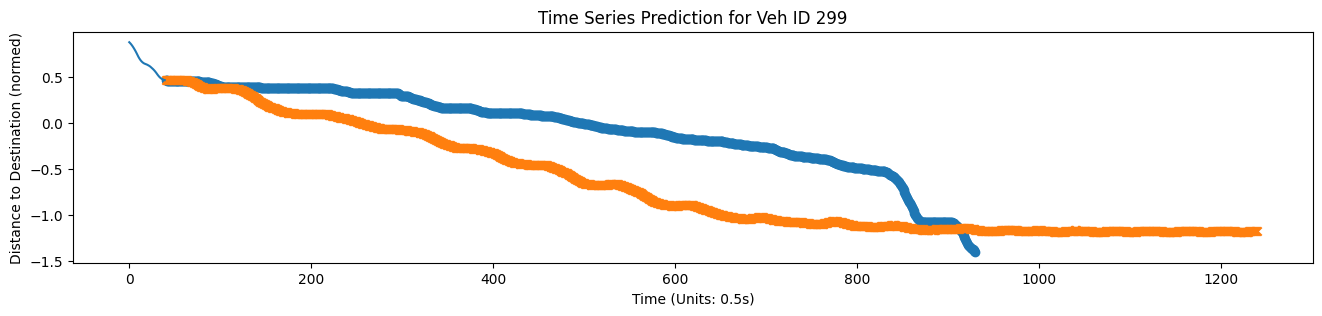




Results for vehicle 2:
Predicted ETA (Units: 0.5s): 2440
Real Eta (Units: 0.5s): 377

Predicted ETA (Units: 1.0s): 1220.0
Real Eta (Units: 1.0s): 188.5

Abs Error (Units: 0.5s): 2063
Abs Error (Units: 1.0s): 1031.5
Percent Error: 5.472148541114058


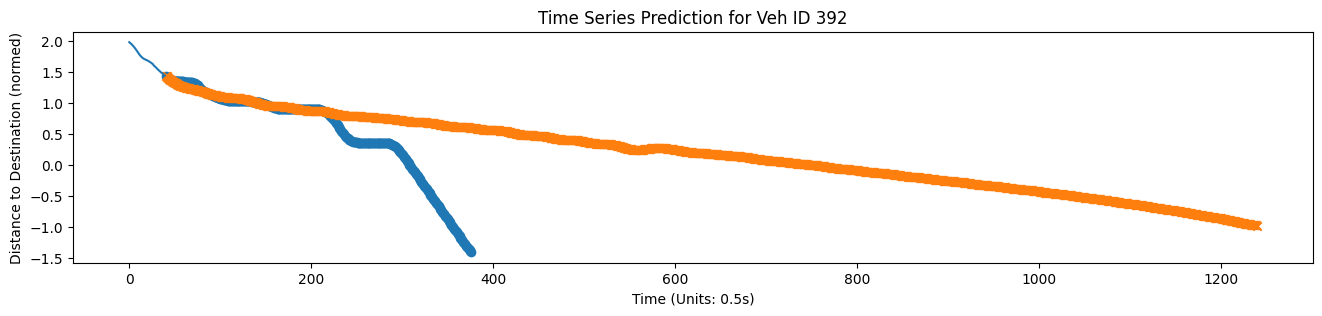




Results for vehicle 3:
Predicted ETA (Units: 0.5s): 1388
Real Eta (Units: 0.5s): 203

Predicted ETA (Units: 1.0s): 694.0
Real Eta (Units: 1.0s): 101.5

Abs Error (Units: 0.5s): 1185
Abs Error (Units: 1.0s): 592.5
Percent Error: 5.83743842364532


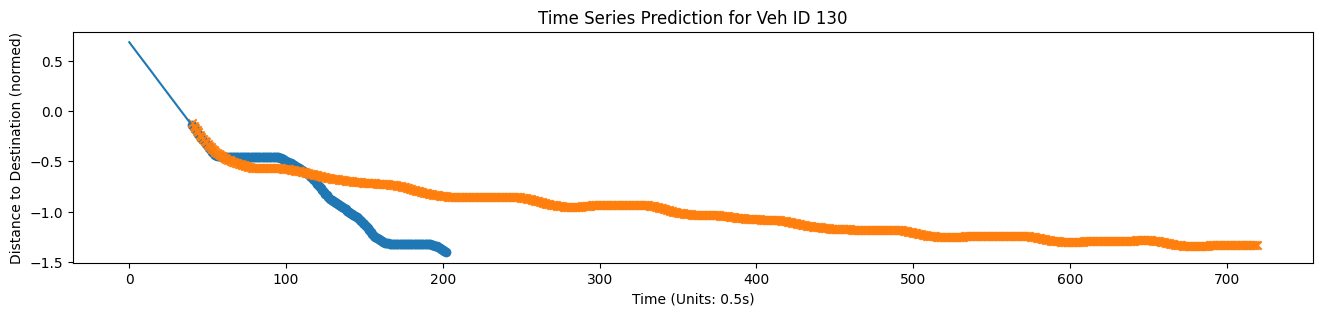




Results for vehicle 4:
Predicted ETA (Units: 0.5s): 1281
Real Eta (Units: 0.5s): 403

Predicted ETA (Units: 1.0s): 640.5
Real Eta (Units: 1.0s): 201.5

Abs Error (Units: 0.5s): 878
Abs Error (Units: 1.0s): 439.0
Percent Error: 2.1786600496277915


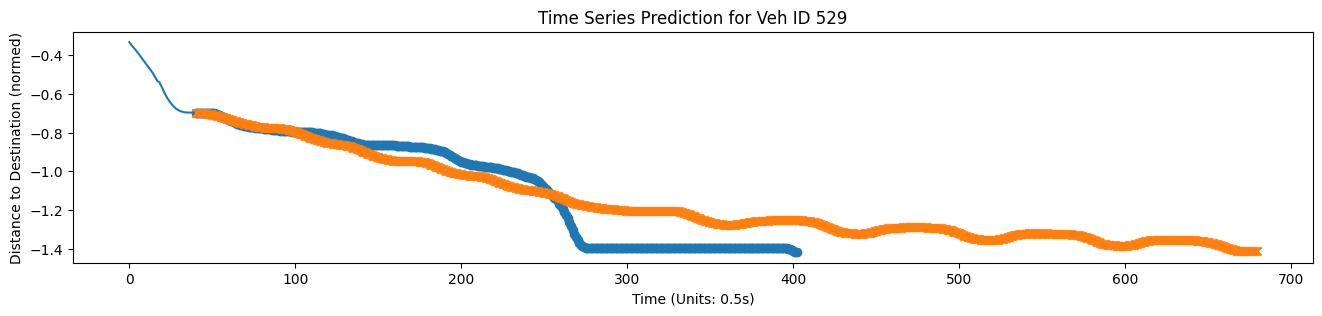




Results for vehicle 5:
Predicted ETA (Units: 0.5s): 1041
Real Eta (Units: 0.5s): 592

Predicted ETA (Units: 1.0s): 520.5
Real Eta (Units: 1.0s): 296.0

Abs Error (Units: 0.5s): 449
Abs Error (Units: 1.0s): 224.5
Percent Error: 0.7584459459459459


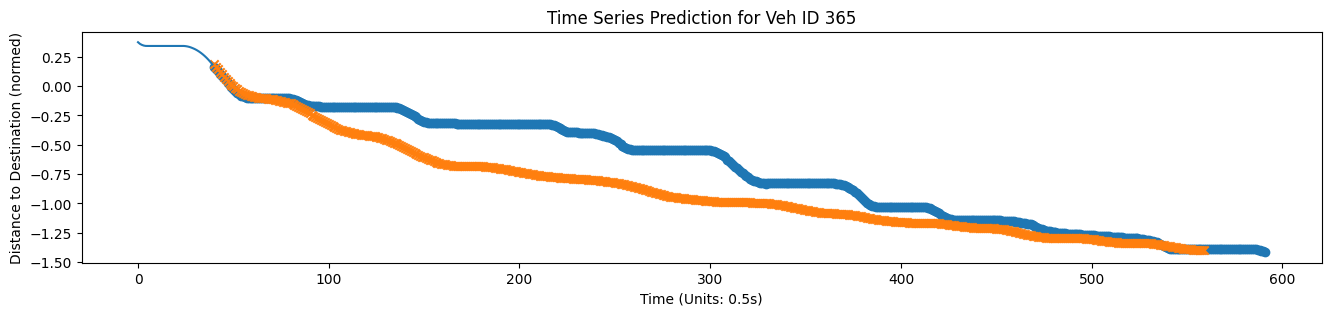




Results for vehicle 6:
Predicted ETA (Units: 0.5s): 2440
Real Eta (Units: 0.5s): 504

Predicted ETA (Units: 1.0s): 1220.0
Real Eta (Units: 1.0s): 252.0

Abs Error (Units: 0.5s): 1936
Abs Error (Units: 1.0s): 968.0
Percent Error: 3.8412698412698414


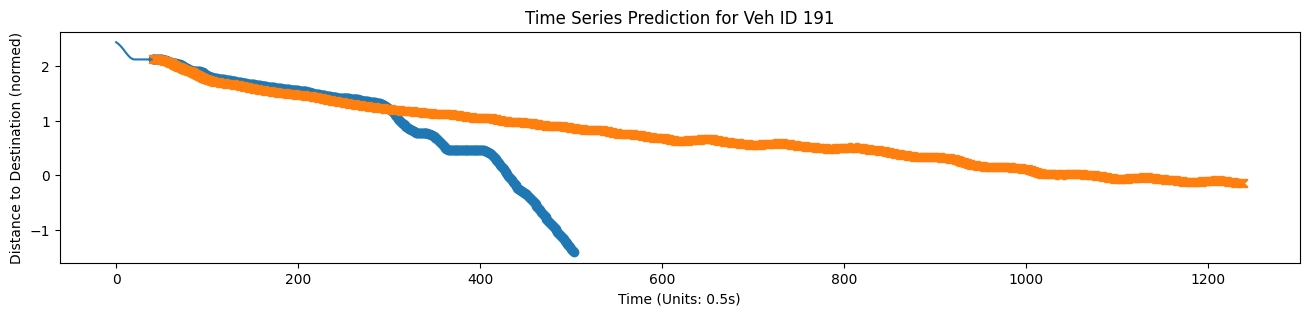




Results for vehicle 7:
Predicted ETA (Units: 0.5s): 2431
Real Eta (Units: 0.5s): 265

Predicted ETA (Units: 1.0s): 1215.5
Real Eta (Units: 1.0s): 132.5

Abs Error (Units: 0.5s): 2166
Abs Error (Units: 1.0s): 1083.0
Percent Error: 8.173584905660377


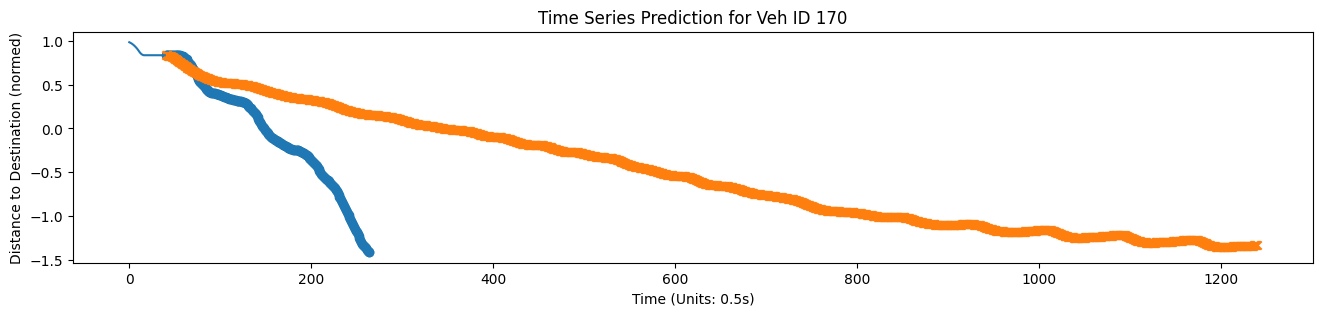




Results for vehicle 8:
Predicted ETA (Units: 0.5s): 2440
Real Eta (Units: 0.5s): 192

Predicted ETA (Units: 1.0s): 1220.0
Real Eta (Units: 1.0s): 96.0

Abs Error (Units: 0.5s): 2248
Abs Error (Units: 1.0s): 1124.0
Percent Error: 11.708333333333334


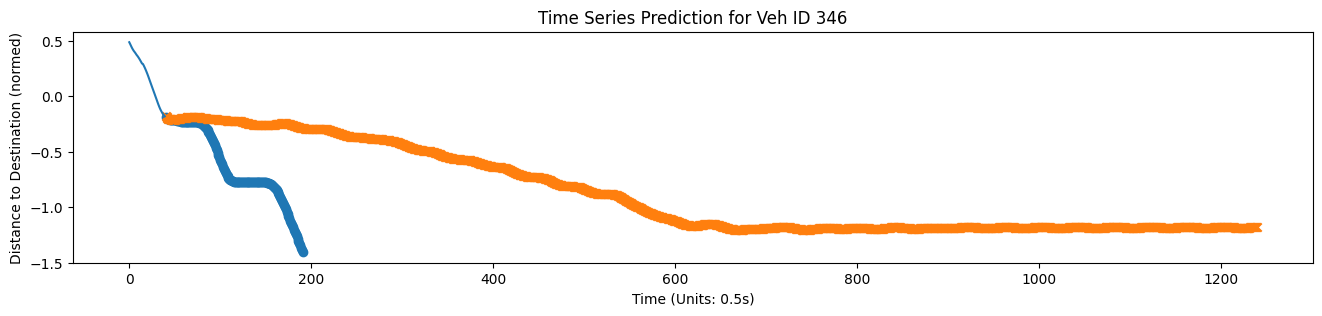




Results for vehicle 9:
Predicted ETA (Units: 0.5s): 2440
Real Eta (Units: 0.5s): 248

Predicted ETA (Units: 1.0s): 1220.0
Real Eta (Units: 1.0s): 124.0

Abs Error (Units: 0.5s): 2192
Abs Error (Units: 1.0s): 1096.0
Percent Error: 8.838709677419354


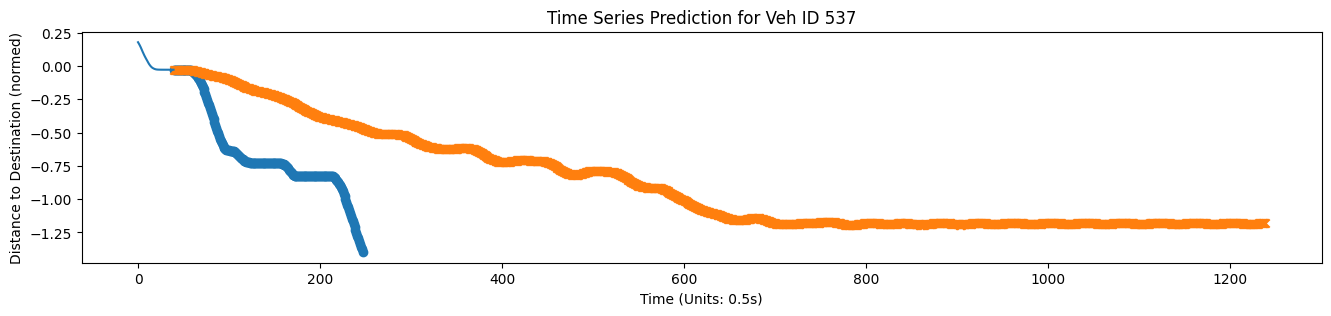




Results for vehicle 10:
Predicted ETA (Units: 0.5s): 1281
Real Eta (Units: 0.5s): 369

Predicted ETA (Units: 1.0s): 640.5
Real Eta (Units: 1.0s): 184.5

Abs Error (Units: 0.5s): 912
Abs Error (Units: 1.0s): 456.0
Percent Error: 2.4715447154471546


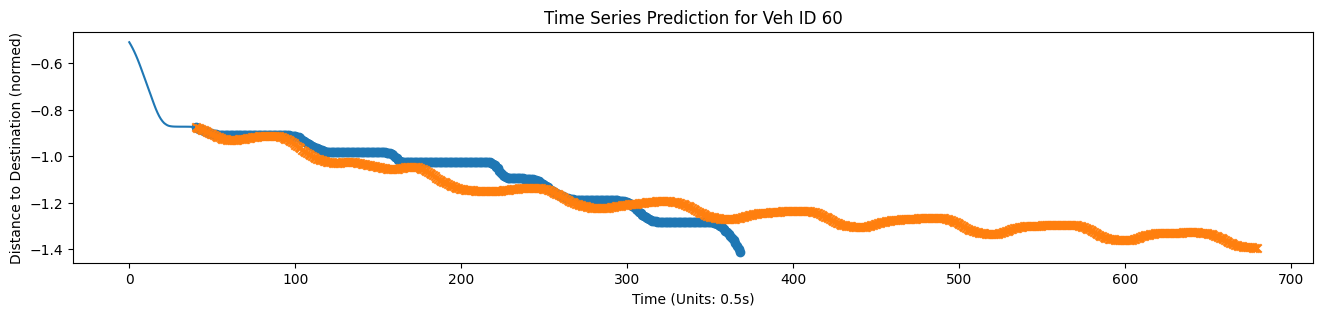




Results for vehicle 11:
Predicted ETA (Units: 0.5s): 1541
Real Eta (Units: 0.5s): 210

Predicted ETA (Units: 1.0s): 770.5
Real Eta (Units: 1.0s): 105.0

Abs Error (Units: 0.5s): 1331
Abs Error (Units: 1.0s): 665.5
Percent Error: 6.338095238095238


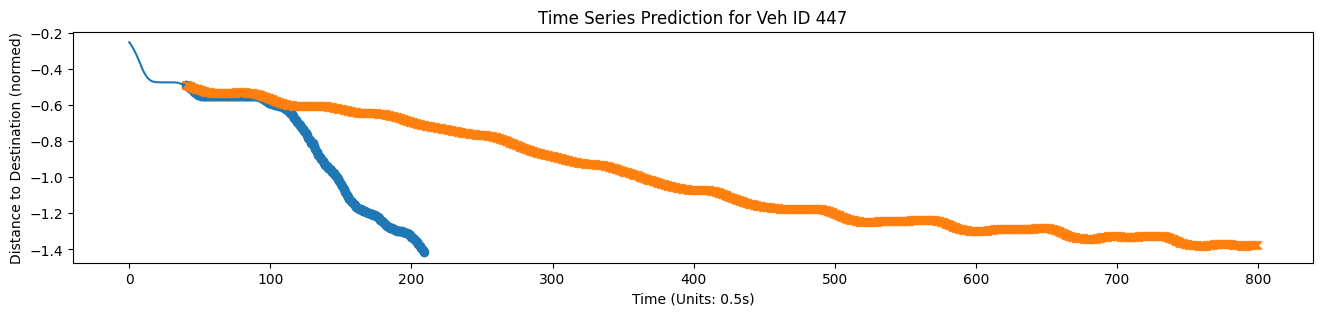




Results for vehicle 12:
Predicted ETA (Units: 0.5s): 2440
Real Eta (Units: 0.5s): 318

Predicted ETA (Units: 1.0s): 1220.0
Real Eta (Units: 1.0s): 159.0

Abs Error (Units: 0.5s): 2122
Abs Error (Units: 1.0s): 1061.0
Percent Error: 6.672955974842767


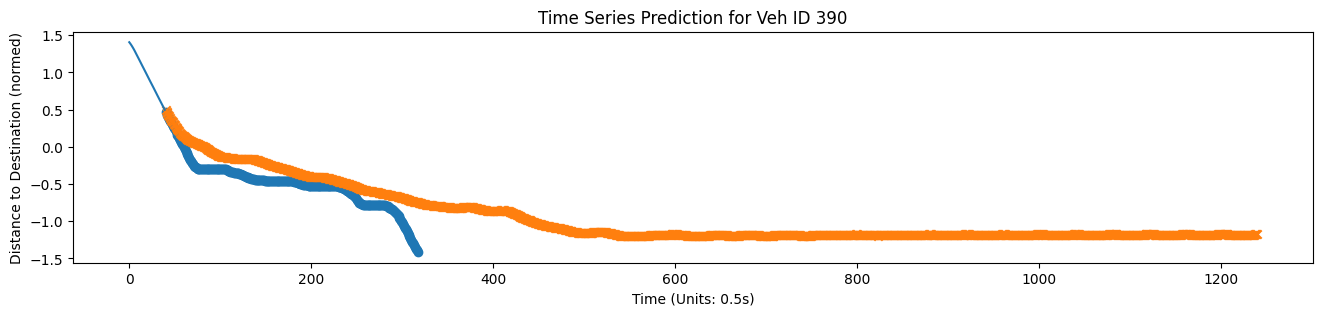




Results for vehicle 13:
Predicted ETA (Units: 0.5s): 2440
Real Eta (Units: 0.5s): 418

Predicted ETA (Units: 1.0s): 1220.0
Real Eta (Units: 1.0s): 209.0

Abs Error (Units: 0.5s): 2022
Abs Error (Units: 1.0s): 1011.0
Percent Error: 4.837320574162679


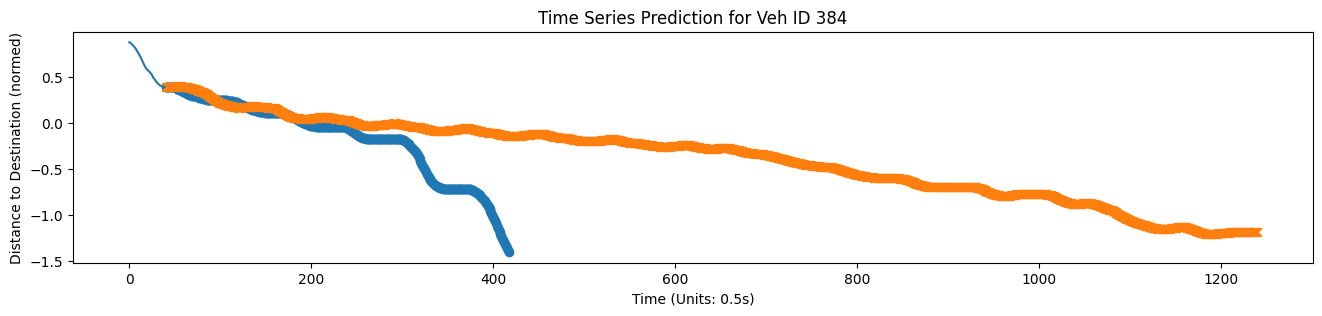




Results for vehicle 14:
Predicted ETA (Units: 0.5s): 2440
Real Eta (Units: 0.5s): 423

Predicted ETA (Units: 1.0s): 1220.0
Real Eta (Units: 1.0s): 211.5

Abs Error (Units: 0.5s): 2017
Abs Error (Units: 1.0s): 1008.5
Percent Error: 4.768321513002364


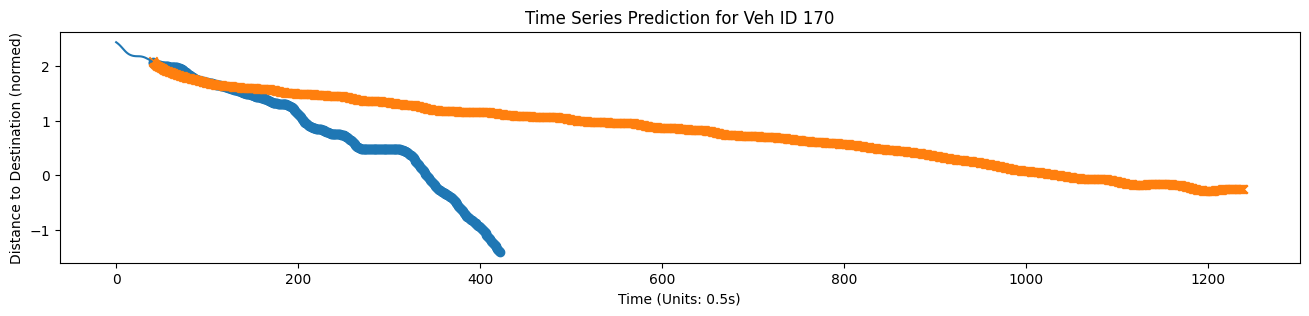




Results for vehicle 15:
Predicted ETA (Units: 0.5s): 2440
Real Eta (Units: 0.5s): 331

Predicted ETA (Units: 1.0s): 1220.0
Real Eta (Units: 1.0s): 165.5

Abs Error (Units: 0.5s): 2109
Abs Error (Units: 1.0s): 1054.5
Percent Error: 6.371601208459214


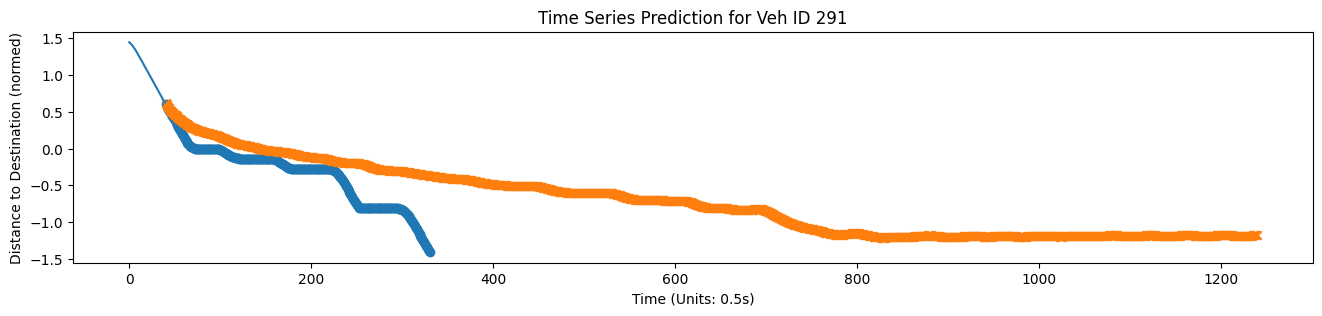




---------- RESULTS FOR 15 VEHICLES----------
Mean Absolute Error (Units: 0.5s): 1675.9333333333334
Mean Absolute Error (Units: 1.0s): 837.9666666666667
Mean Percent Error: 5.325951183388877


In [ ]:
# Running test function
testSingleShotEta(model, num_samples=15, plot_col="Distance to Edge", window=w0, plot=True, verbose=True)

# Testing Auto-regressive Model

## New Class for Removing TL Data

In [ ]:
# Feedback model
class noTlDataFeedback(keras.Model):
  def __init__(self, units, label_output_steps, num_pred_features):
    super().__init__()
    self.units = units
    self.label_output_steps = label_output_steps
    self.lstm_cell = layers.LSTMCell(units)
    self.lstm_rnn = layers.RNN(self.lstm_cell, return_state=True)
    self.dense = layers.Dense(num_pred_features) # Outputs 1 time step at a time

  """
  Warms up the weights of the LSTM

  Params:
    np.ndarray input :
  Ret:
    np.ndarray prediction : the single time step prediction made
    state : the state of the LSTM
  """
  def warmup(self, input):
    prediction, *state = self.lstm_rnn(input)

    # Feed it through the dense model to get output
    prediction = self.dense(prediction)

    return prediction, state

  # Call model on inputs and make predictions
  # This method is for training
  def call(self, input, training=None):
    predictions = []
    # Warm up
    prediction, state = self.warmup(input)
    predictions.append(prediction)


    for _ in range(1, self.label_output_steps):
      tmp = prediction
      tmp, state = self.lstm_cell(tmp, states=state, training=training)

      prediction = self.dense(tmp)
      predictions.append(prediction)

    # (time, batch size, features)
    predictions = tf.stack(predictions)
    # (batch size, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])

    return predictions

  """
  Variable length output call to the model. Stops when destination predicted to be reached

  Params:
    Tensor input : input example
    float threshold : value to determine when to round a predicted value for "Destination Reached" or "Distance to Edge" label
    int patience : the number of prediction steps before the prediction is cut off. Default is 2400, the number of time steps in a simulation
  Ret:
    Tensor predictions : the resulting predictions (time steps, features)
  """
  def var_length_call(self, input, patience=2400, tolerance=-1.35):
    predictions = []

    # Warm up
    input = np.array([input])
    prediction, state = self.warmup(input)

    # Keeps track of labels
    distance = prediction.numpy()[:, 15]
    predictions.append(distance)
    while distance > tolerance and patience > 0:
      tmp = prediction
      tmp, state = self.lstm_cell(tmp, states=state)

      prediction = self.dense(tmp)
      distance = prediction.numpy()[:, 15]

      predictions.append(distance[0])
      patience -= 1

    return predictions

  """
  Fills in the missing information in the prediction

  Params:
    np.ndarray input : the input sequence we are making a prediction on.
  Ret:

  """
  def fill_prediction(input, time, prediction):
    return input

## Testing Code

In [ ]:
"""
Function to test the ETA prediction of the autoregressive model.
Picks specified number of random time series, then prints the predicted and actual ETA in both 0.5s units and 1s units
Plots the results.

Params:
  tf.keras.Model model : the model used for predictions
  int numsamples : number of samples to test the model on
  str plot_col : the column to plot results of
  bool plot : Whether to plot the results or not
  bool verbose : whether to show results after every sample
Ret:
  None
"""
def testAutoregressiveEta(model, num_samples=10, plot_col="Distance to Edge", window=None, plot=True, verbose=True):
  plot_col_ind_input = window.input_columns_indices[plot_col]
  plot_col_ind_label = window.label_columns_indices[plot_col]

  chosen_ts = np.rint(np.random.rand(num_samples) * 549).astype(int)
  errors = []
  count = 1
  for el in chosen_ts:
    t = findTrip(all_data[el])
    while type(t) is int: # If the function returns an error (unable to find a time frame that has a wide enough window)
      ind = np.rint(np.random.rand(1) * 549).astype(int)[0]
      t = findTrip(all_data[ind])

    # Filter out the features not needed
    t = removeFeatures(t, window.column_indices, window.input_columns)

    input_t = t[:80]
    label_t = t[80:]

    predicted_ts = model.var_length_call(input_t)
    eta = len(predicted_ts)
    abs_error = abs(eta - len(label_t))
    errors.append(abs_error)

    if verbose:
      print(f"Results for vehicle {count}:")
      print(f"Predicted ETA (Units: 0.5s): {eta}\nReal Eta (Units: 0.5s): {len(t)}\n")
      print(f"Predicted ETA (Units: 1.0s): {eta / 2}\nReal Eta (Units: 1.0s): {len(t) / 2}\n")
      print(f"Abs Error (Units: 0.5s): {abs_error}\nAbs Error (Units: 1.0s): {abs_error / 2}")

    if plot:
      plt.figure(figsize=(16, 3))
      plt.title(f"Time Series Prediction for Veh ID {el}")
      plt.ylabel(f"Distance to Destination (normed)")
      plt.xlabel(f"Time (Units: 0.5s)")
      plt.plot(np.arange(80), input_t[:, plot_col_ind_input])
      plt.scatter(np.arange(80, 80 + len(label_t)), label_t[:, plot_col_ind_input], marker="o")
      plt.scatter(np.arange(80, len(predicted_ts) + 80), predicted_ts, marker="x")
      plt.show()

    if verbose:
      print("\n\n")
    count += 1

  mean_abs_error = sum(errors) / len(errors)
  print(("-" * 10) + f" RESULTS FOR {count - 1} VEHICLES" + ("-" * 10))
  print(f"Mean Absolute Error (Units: 0.5s): {mean_abs_error}\nMean Absolute Error (Units: 1.0s): {mean_abs_error / 2}")

In [ ]:
test_lstm_feedback = noTlDataFeedback(64, OUTPUT_STEPS, num_features)
test_lstm_feedback.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
test_lstm_feedback.load_weights('/content/drive/MyDrive/Colab Notebooks/model/biggerLSTM_80sWind_NoDestorReachedorTLData_AutoReg')

In [ ]:
w1 = WindowGenerator(80, 80, 80, 20, train_ts, validate_ts, test_ts, labels, labels[:-2], labels[:-2])

In [ ]:
w1 = WindowGenerator(80, 80, 80, 20, train_ts, validate_ts, test_ts, labels, output_labels, output_labels)

Results for vehicle 1:
Predicted ETA (Units: 0.5s): 2401
Real Eta (Units: 0.5s): 723

Predicted ETA (Units: 1.0s): 1200.5
Real Eta (Units: 1.0s): 361.5

Abs Error (Units: 0.5s): 1758
Abs Error (Units: 1.0s): 879.0


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


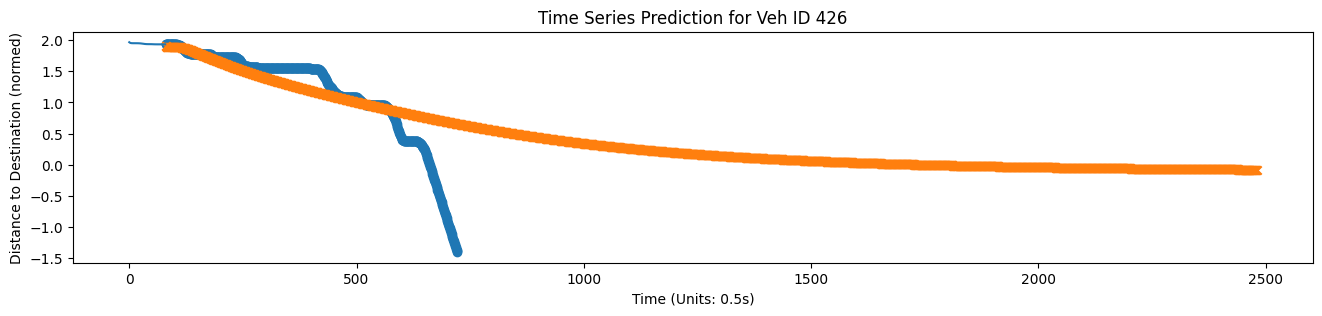




Results for vehicle 2:
Predicted ETA (Units: 0.5s): 2401
Real Eta (Units: 0.5s): 592

Predicted ETA (Units: 1.0s): 1200.5
Real Eta (Units: 1.0s): 296.0

Abs Error (Units: 0.5s): 1889
Abs Error (Units: 1.0s): 944.5


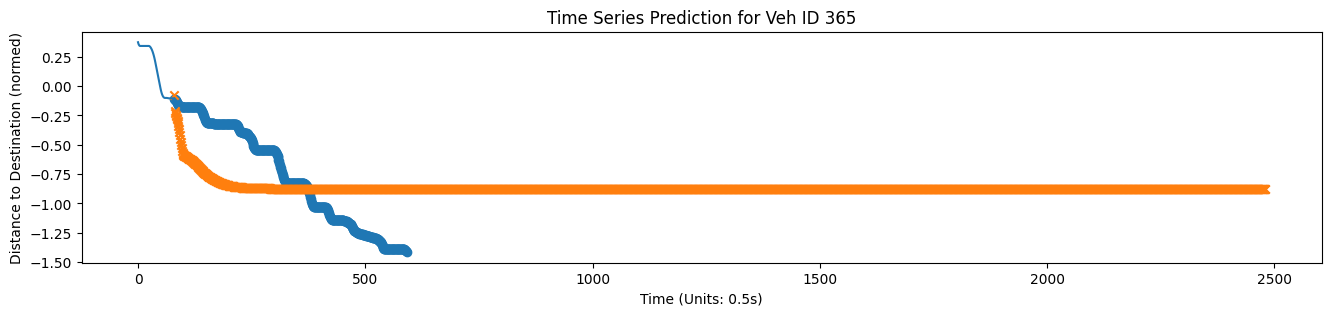




Results for vehicle 3:
Predicted ETA (Units: 0.5s): 2401
Real Eta (Units: 0.5s): 290

Predicted ETA (Units: 1.0s): 1200.5
Real Eta (Units: 1.0s): 145.0

Abs Error (Units: 0.5s): 2191
Abs Error (Units: 1.0s): 1095.5


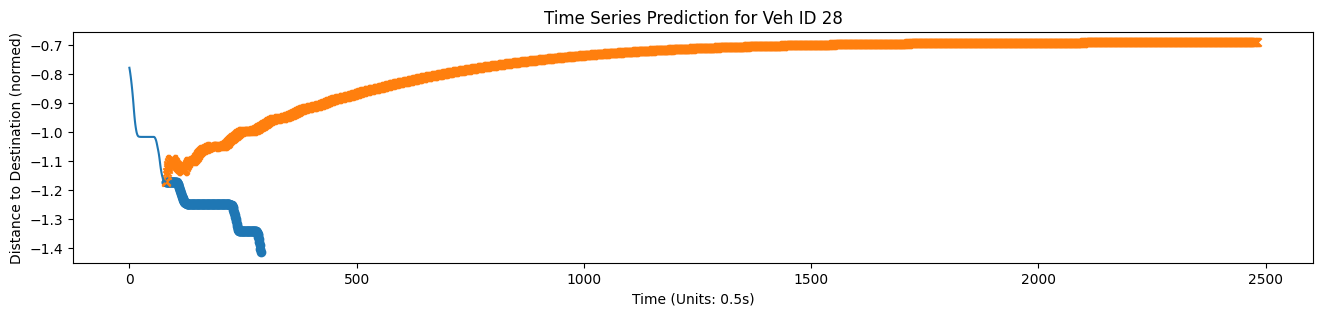




Results for vehicle 4:
Predicted ETA (Units: 0.5s): 2401
Real Eta (Units: 0.5s): 312

Predicted ETA (Units: 1.0s): 1200.5
Real Eta (Units: 1.0s): 156.0

Abs Error (Units: 0.5s): 2169
Abs Error (Units: 1.0s): 1084.5


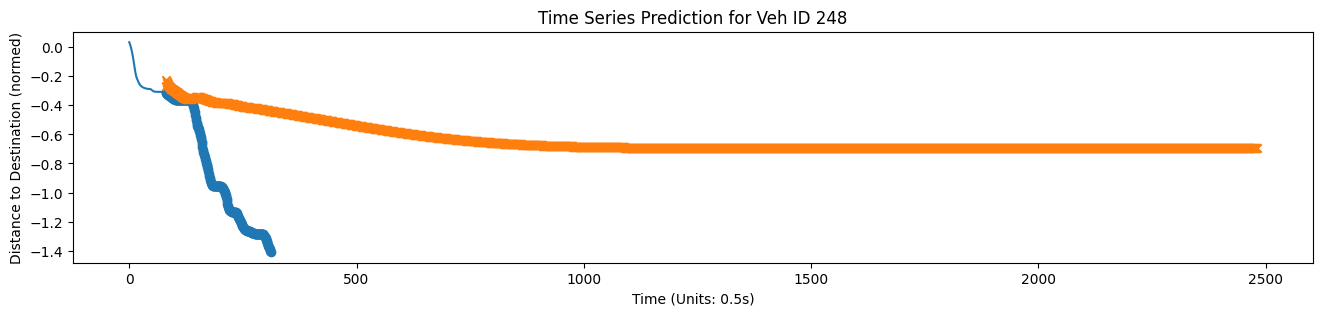




Results for vehicle 5:
Predicted ETA (Units: 0.5s): 2401
Real Eta (Units: 0.5s): 318

Predicted ETA (Units: 1.0s): 1200.5
Real Eta (Units: 1.0s): 159.0

Abs Error (Units: 0.5s): 2163
Abs Error (Units: 1.0s): 1081.5


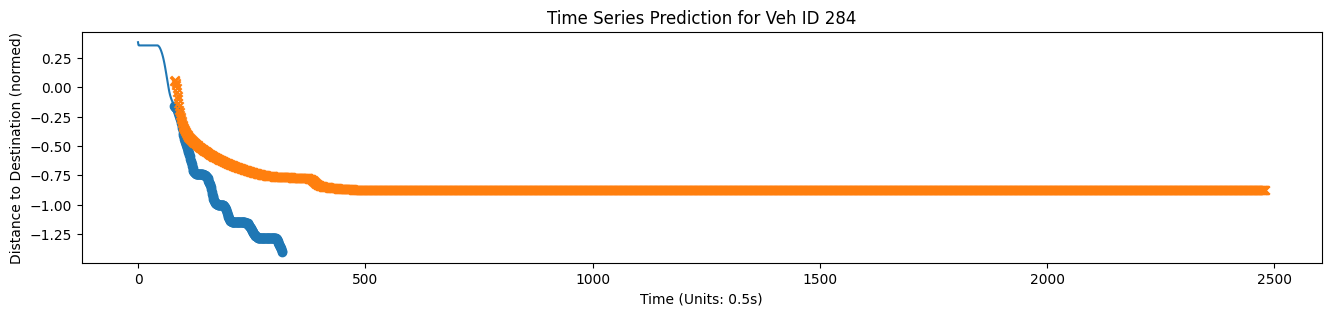




Results for vehicle 6:
Predicted ETA (Units: 0.5s): 2401
Real Eta (Units: 0.5s): 331

Predicted ETA (Units: 1.0s): 1200.5
Real Eta (Units: 1.0s): 165.5

Abs Error (Units: 0.5s): 2150
Abs Error (Units: 1.0s): 1075.0


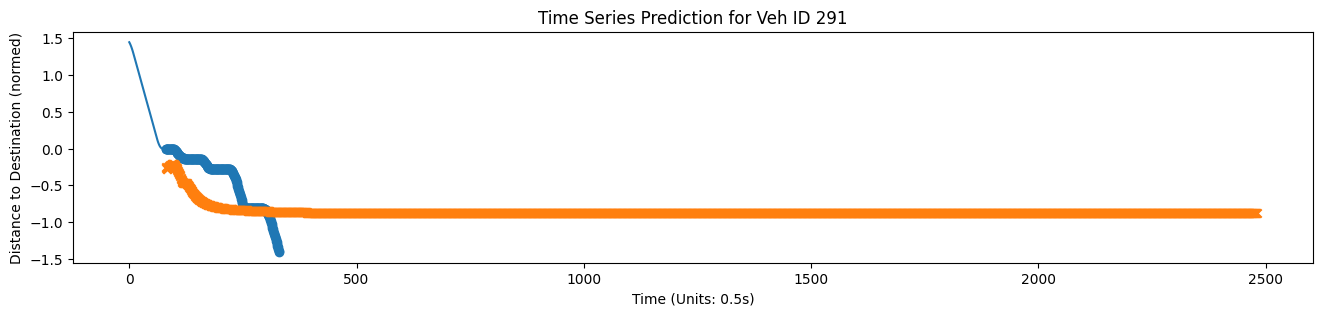




Results for vehicle 7:
Predicted ETA (Units: 0.5s): 2401
Real Eta (Units: 0.5s): 326

Predicted ETA (Units: 1.0s): 1200.5
Real Eta (Units: 1.0s): 163.0

Abs Error (Units: 0.5s): 2155
Abs Error (Units: 1.0s): 1077.5


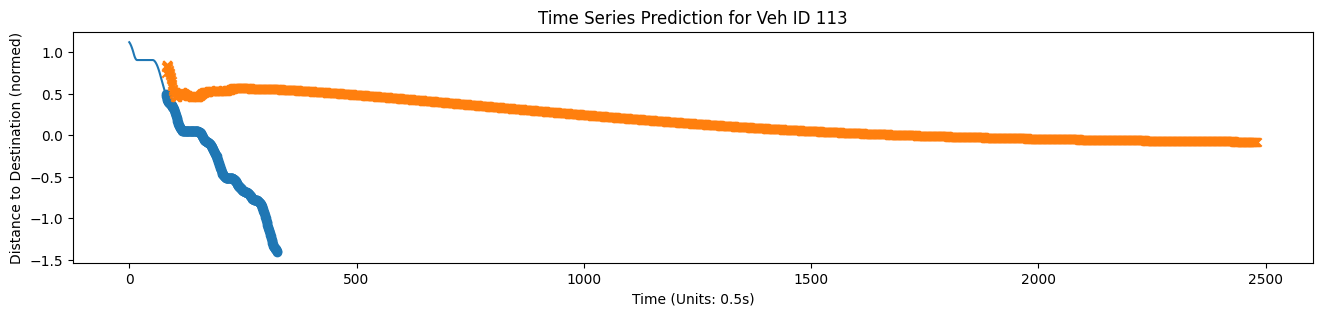




Results for vehicle 8:
Predicted ETA (Units: 0.5s): 2401
Real Eta (Units: 0.5s): 424

Predicted ETA (Units: 1.0s): 1200.5
Real Eta (Units: 1.0s): 212.0

Abs Error (Units: 0.5s): 2057
Abs Error (Units: 1.0s): 1028.5


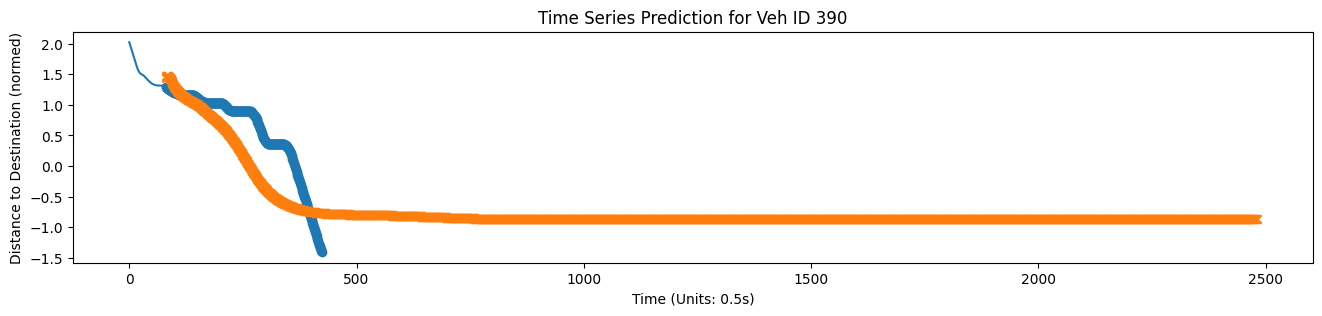




Results for vehicle 9:
Predicted ETA (Units: 0.5s): 2401
Real Eta (Units: 0.5s): 161

Predicted ETA (Units: 1.0s): 1200.5
Real Eta (Units: 1.0s): 80.5

Abs Error (Units: 0.5s): 2320
Abs Error (Units: 1.0s): 1160.0


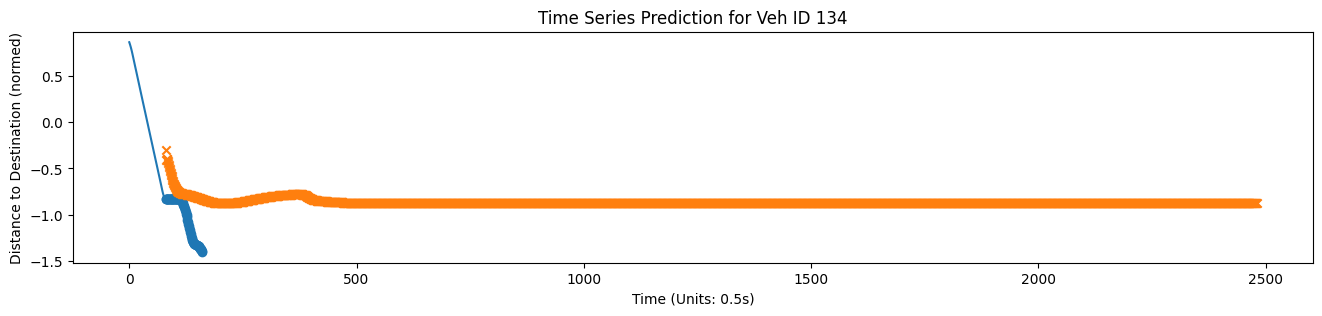




Results for vehicle 10:
Predicted ETA (Units: 0.5s): 2401
Real Eta (Units: 0.5s): 426

Predicted ETA (Units: 1.0s): 1200.5
Real Eta (Units: 1.0s): 213.0

Abs Error (Units: 0.5s): 2055
Abs Error (Units: 1.0s): 1027.5


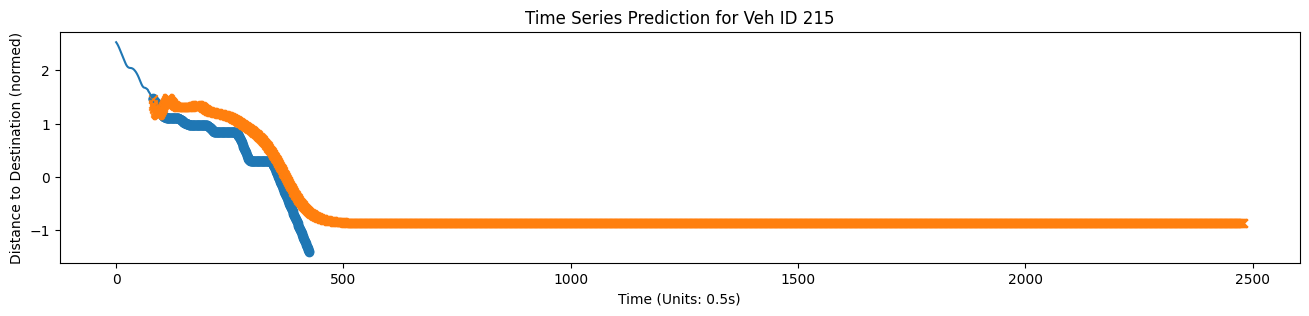




---------- RESULTS FOR 10 VEHICLES----------
Mean Absolute Error (Units: 0.5s): 2090.7
Mean Absolute Error (Units: 1.0s): 1045.35


In [ ]:
testAutoregressiveEta(test_lstm_feedback, window=w1)

# Model to Assist Single Shot Prediction

<ins>Problem:</ins> Due to slight errors in how far we have traveled, the predicted vehicle trajectory may show that it has been stopped by a traffic light where the real vehicle has not (or vice versa). This error cascades in future windows and throws off the prediction by a large amount.

<ins>Goal:</ins> We want to use a second neural network to predict for a given 40 second predicted window, will our model have predicted incorreclty if we have passed an intersection or not.

<ins> Some Details: </ins>
* The model will only read in 10 second windows
* The model will take in the same parameters as our original prediction model

## Create Data

### Idea 1 - Include Input Data to the model and output probability of crossing in predicted 40 seconds
We have all input batches, just need the corresponding labels. The model will return a probability of how likely our single-shot model will predict passing an intersection correctly.

This involves having to go through all training examples and running our model through it, then comparing it to the data.

### Idea 2 - Same as above, but the output has additional index of where the error occurs.

### Idea 3 - Return a difference in time for the output. When it is correct, the difference is 0, otherwise it will be at most 80 (default if one predicts crossing an intersection, but the other doesn't).

<ins> Edge Case </ins> There are more than 2 intersection crossings in 1 time window: I will ignore that for now.

In [ ]:
"""
Create new dataset for the second neural network

Params:
  Dataset ds : the Tensorflow dataset to make a new dataset out of
  Tensorflow Model model : the model used to make predictions
Ret:
  Dataset new_ds : the new dataset formed
"""
def make_new_model_ds(ds, model):
  j = 1
  size = ds.cardinality().numpy()

  ds_inputs = -1
  ds_labels = -1

  for batch in ds.as_numpy_iterator():
    # Nice printing for progress
    progress = int(30 * j / size)
    print(f"\rBatch {j}/{size}: (" + (progress * "=") + ">" + (30 - progress) * "." + ")", end="")
    j += 1

    # Grab batch
    inputs = batch[0]
    labels = batch[1]
    batch_size = inputs.shape[0]

    # Run the single-shot model on the input batch
    predicted_labels = model(inputs)

    # Go through each label and see if our model predicted correctly or not
    new_labels = [] # Shape (32, 1)
    for i in range(batch_size):
      input = inputs[i]
      correct = labels[i]
      predicted = predicted_labels[i]

      # Get the last distance to destination and distance to Traffic Light to figure out how far along route the traffic light is
      dist_to_dest = input[-1, -1]
      dist_to_tl = ((input[-1, 3] * num_std[3] + num_mean[3]) - num_mean[-1]) / num_std[-1]
      intersection_dist_to_dest = dist_to_dest - dist_to_tl

      # See where the vehicle passes an intersection
      intersection_index_pred, intersection_index_correct = -1, -1 # Default index
      for k in range(len(correct)):
        if correct[k, -1] <= intersection_dist_to_dest and intersection_index_correct == -1:
          intersection_index_correct = k
        if predicted[k, -1] <= intersection_dist_to_dest and intersection_index_pred == -1:
          intersection_index_pred = k

        # Early breaking - ignoring edge case where there are two intersection crossings
        if intersection_index_pred != -1 and intersection_index_correct != -1:
          break

      # Get the delta error
      print(intersection_index_pred, intersection_index_correct)
      intersection_index_err = 0 # Default: both predict that the car doesn't cross the intersection
      if intersection_index_pred != -1 or intersection_index_correct != -1:
        if intersection_index_pred != -1 and intersection_index_correct == -1: # Predicted crossing when there wasn't one
          intersection_index_err = 80
        elif intersection_index_pred == -1 and intersection_index_correct != -1: # Predicted not crossing when there was a crossing
          intersection_index_err = 80 - intersection_index_correct
        else: # Find the error in when the vehicle crosses
          print("hello")
          intersection_index_err = intersection_index_correct - intersection_index_pred

      # Add to the new labels
      new_labels.append([intersection_index_err])

    # Append the input and labels to the new ds
    # Case: hasn't been initialized:
    if type(ds_inputs) is int:
      ds_inputs = inputs
      ds_labels = new_labels
    ds_inputs = np.append(ds_inputs, inputs, axis=0)
    ds_labels = np.append(ds_labels, new_labels, axis=0)

  return tf.data.Dataset.from_tensor_slices((ds_inputs, ds_labels)).batch(32)

In [ ]:
# Making the training dataset
train_ds_secondary = make_new_model_ds(train_ds, bigger_LSTM)

Batch 825/825: (==============================>)

In [ ]:
# Making the validation dataset
val_ds_secondary = make_new_model_ds(val_ds, bigger_LSTM)

Batch 183/183: (==============================>)

In [ ]:
# Making the test dataset
test_ds_secondary = make_new_model_ds(test_ds, bigger_LSTM)

Batch 1/56: (>..............................)-1 -1
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
14 20
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
-1 -1
0 0
hello
56 -1
0 0
hello
3 15
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
Batch 2/56: (=>.............................)0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
-1 39
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 -1
46 -1
-1 -1
0 0
hello
-1 -1
0 0
hello
0 0
hello
0 0
hello
44 36
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
Batch 3/56: (=>.............................)0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
-1 -1
-1 -1
-1 -1
-1 -1
-1 -1
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0
hello
0 0

KeyboardInterrupt: ignored

In [ ]:
tf.data.Dataset.save(train_ds_secondary, "/content/drive/MyDrive/Colab Notebooks/train_ds_secondary")

In [ ]:
tf.data.Dataset.save(val_ds_secondary, "/content/drive/MyDrive/Colab Notebooks/val_ds_secondary")

In [ ]:
tf.data.Dataset.save(test_ds_secondary, "/content/drive/MyDrive/Colab Notebooks/test_ds_secondary")

In [ ]:
train_ds_secondary = tf.data.Dataset.load("/content/drive/MyDrive/Colab Notebooks/train_ds_secondary")
val_ds_secondary = tf.data.Dataset.load("/content/drive/MyDrive/Colab Notebooks/val_ds_secondary")
test_ds_secondary = tf.data.Dataset.load("/content/drive/MyDrive/Colab Notebooks/test_ds_secondary")

In [ ]:
# Creating a model
secondary_model = keras.Sequential([
    layers.Flatten(input_shape=(80, 23)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='relu') # Output
])

secondary_model.compile(
    optimizer=keras.optimizers.Adam(0.1),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError()]
)

In [ ]:
history = secondary_model.fit(train_ds_secondary,
                             epochs=10,
                             validation_data=val_ds_secondary)

Epoch 1/10
826/826 [==============================] - 14s 14ms/step - loss: 32.4599 - mean_squared_error: 32.4599 - val_loss: 52.2625 - val_mean_squared_error: 52.2625
Epoch 2/10
826/826 [==============================] - 5s 6ms/step - loss: 32.4598 - mean_squared_error: 32.4598 - val_loss: 52.2625 - val_mean_squared_error: 52.2625
Epoch 3/10
826/826 [==============================] - 6s 8ms/step - loss: 32.4598 - mean_squared_error: 32.4598 - val_loss: 52.2625 - val_mean_squared_error: 52.2625
Epoch 4/10
826/826 [==============================] - 10s 12ms/step - loss: 32.4598 - mean_squared_error: 32.4598 - val_loss: 52.2625 - val_mean_squared_error: 52.2625
Epoch 5/10
826/826 [==============================] - 11s 13ms/step - loss: 32.4598 - mean_squared_error: 32.4598 - val_loss: 52.2625 - val_mean_squared_error: 52.2625
Epoch 6/10
826/826 [==============================] - 7s 8ms/step - loss: 32.4598 - mean_squared_error: 32.4598 - val_loss: 52.2625 - val_mean_squared_error: 52.262

In [ ]:
secondary_model.evaluate(test_ds_secondary)

57/57 [==============================] - 1s 6ms/step - loss: 77.7141 - mean_squared_error: 77.7141


[77.71412658691406, 77.71412658691406]

In [ ]:
for batch in test_ds_secondary.as_numpy_iterator():
  input = batch[0]
  label = batch[1]
  pred = secondary_model(input)
  # print(input[0])
  # print('Correct Output: ', label[0])
  # print('Predicted Classifier Output: ', pred)
  error = np.mean(sum((label - pred)**2) / 32)
  for i in range(len(label)):
    if abs(label[i] - pred[i]) > 0:
      print("Correct", label[i], " Prediction: ", pred[i])
  print("MSE: ", error)

Correct [80]  Prediction:  tf.Tensor([0.], shape=(1,), dtype=float32)
Correct [80]  Prediction:  tf.Tensor([0.], shape=(1,), dtype=float32)
MSE:  400.0
Correct [80]  Prediction:  tf.Tensor([0.], shape=(1,), dtype=float32)
Correct [80]  Prediction:  tf.Tensor([0.], shape=(1,), dtype=float32)
MSE:  400.0
Correct [80]  Prediction:  tf.Tensor([0.], shape=(1,), dtype=float32)
Correct [80]  Prediction:  tf.Tensor([0.], shape=(1,), dtype=float32)
Correct [1]  Prediction:  tf.Tensor([0.], shape=(1,), dtype=float32)
Correct [1]  Prediction:  tf.Tensor([0.], shape=(1,), dtype=float32)
Correct [1]  Prediction:  tf.Tensor([0.], shape=(1,), dtype=float32)
MSE:  400.09375
Correct [1]  Prediction:  tf.Tensor([0.], shape=(1,), dtype=float32)
Correct [1]  Prediction:  tf.Tensor([0.], shape=(1,), dtype=float32)
MSE:  0.0625
MSE:  0.0
Correct [1]  Prediction:  tf.Tensor([0.], shape=(1,), dtype=float32)
Correct [1]  Prediction:  tf.Tensor([0.], shape=(1,), dtype=float32)
MSE:  0.0625
Correct [1]  Predicti

In [ ]:
for input, label in train_ds_secondary.as_numpy_iterator():
  if len(label[label > 0]):
    print(label[label > 0])

[80 80]
[1]
[1 1]
[1 1 1]
[1]
[1 1 1 1]
[1]
[1 1]
[1 1]
[1]
[1 1]
[1 1]
[1 1]
[1]
[80]
[1 1 1 1]
[80 80 80  1  1]
[1 1]
[1 1]
[1 1 1]
[1]
[1 1 1 1]
[80  1 80 80 80]
[1 1]
[1]
[80  1  1  1]
[1 1]
[1 1]
[1 1]
[80 80 80 80]
[ 1 80]
[1]
[1 1]
[1 1]
[80 80]
[80]
[1 1 1 1 1]
[1]
[80]
[1]
[1 1 1 1]
[1 1]
[1]
[1]
[1 1]
[80]
[80  1]
[80 80 80]
[1]
[1]
[1]
[80 80  1  1]
[1]
[1 1 1]
[80]
[80]
[80]
[1 1]
[1 1]
[1 1 1]
[1 1]
[ 1 80]
[1]
[80]
[80  1]
[1]
[1]
[1]
[80 80]
[1]
[80]
[1]
[1 1]
[1 1]
[1 1 1]
[80  1]
[1 1 1]
[1 1 1]
[1]
[1 1]
[1]
[1]
[ 1 80]
[80 80]
[1 1]
[80 80]
[80]
[1]
[80]
[1 1]
[80]
[80]
[80  1]
[1 1]
[ 1 80]
[1 1]
[80  1]
[80]
[1 1]
[1]
[ 1  1 80]
[80 80]
[80]
[ 1  1 80]
[1]
[1 1]
[1]
[1 1]
[1]
[80]
[80  1  1]
[80  1]
[80  1]
[1]
[80]
[1]
[80]
[80]
[80]
[1]
[1]
[1 1 1]
[80]
[80 80  1 80]
[ 1 80]
[1]
[ 1 80]
[1 1 1]
[80 80 80  1]
[80 80 80]
[1]
[80]
[1 1]
[80  1 80 80]
[1 1]
[80  1]
[80  1  1  1]
[80]
[1]
[1 1]
[1 1 1 1]
[80]
[1 1 1 1]
[1]
[80]
[80]
[1]
[1 1]
[80]
[80]
[1 1]
[1]
[80  